In [3]:
#Import

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.optimize as opt 
import pandas as pd 

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/danielsb/Documents/GitHub


In [4]:
Srms = pd.DataFrame(np.array([ 0.0, 1.0, 3.0, 5.0, 6.0, 7.3, 10., 23., 40., 70., 100., 150.]), columns=['Srms'])

c_pars = pd.DataFrame(np.array([
    [6.21, 1.72, 0.79, 0.5874, 0.3577],
    [6.55, 2.02, 3.81, 0.4968, 0.7206],
    [6.53, 1.93, 5.22, 0.5302, 0.7809],
    [6.55, 1.93, 6.22, 0.5504, 0.8015],
    [6.58, 1.95, 6.69, 0.5466, 0.8294],
    [6.55, 1.92, 7.08, 0.5623, 0.8233],
    [6.44, 1.83, 7.59, 0.5928, 0.8072],
    [6.02, 1.43, 9.03, 0.6069, 0.8521],
    [5.74, 1.22, 10.58, 0.6280, 0.8442],
    [5.62, 1.11, 13.03, 0.6094, 0.9293],
    [5.63, 1.41, 15.49, 0.6052, 1.0859],
    [5.48, 1.33, 16.62, 0.6365, 0.9650]
]), columns=['c1', 'c2', 'c3', 'b1', 'b2'])

fitting_params = pd.concat([Srms, c_pars], axis=1)

fitting_params.to_csv('fitting_params.csv', index=False)

In [5]:
Ncut = 10.

Sc = fitting_params.iloc[:,0].values * Ncut/10. 

c1 = fitting_params['c1'].values
c2 = fitting_params['c2'].values
c3 = fitting_params['c3'].values

In [6]:
c1_int = interp.interp1d(Sc, c1, kind='cubic', fill_value='extrapolate')
c2_int = interp.interp1d(Sc, c2, kind='cubic', fill_value='extrapolate')
c3_int = interp.interp1d(Sc, c3, kind='cubic', fill_value='extrapolate')

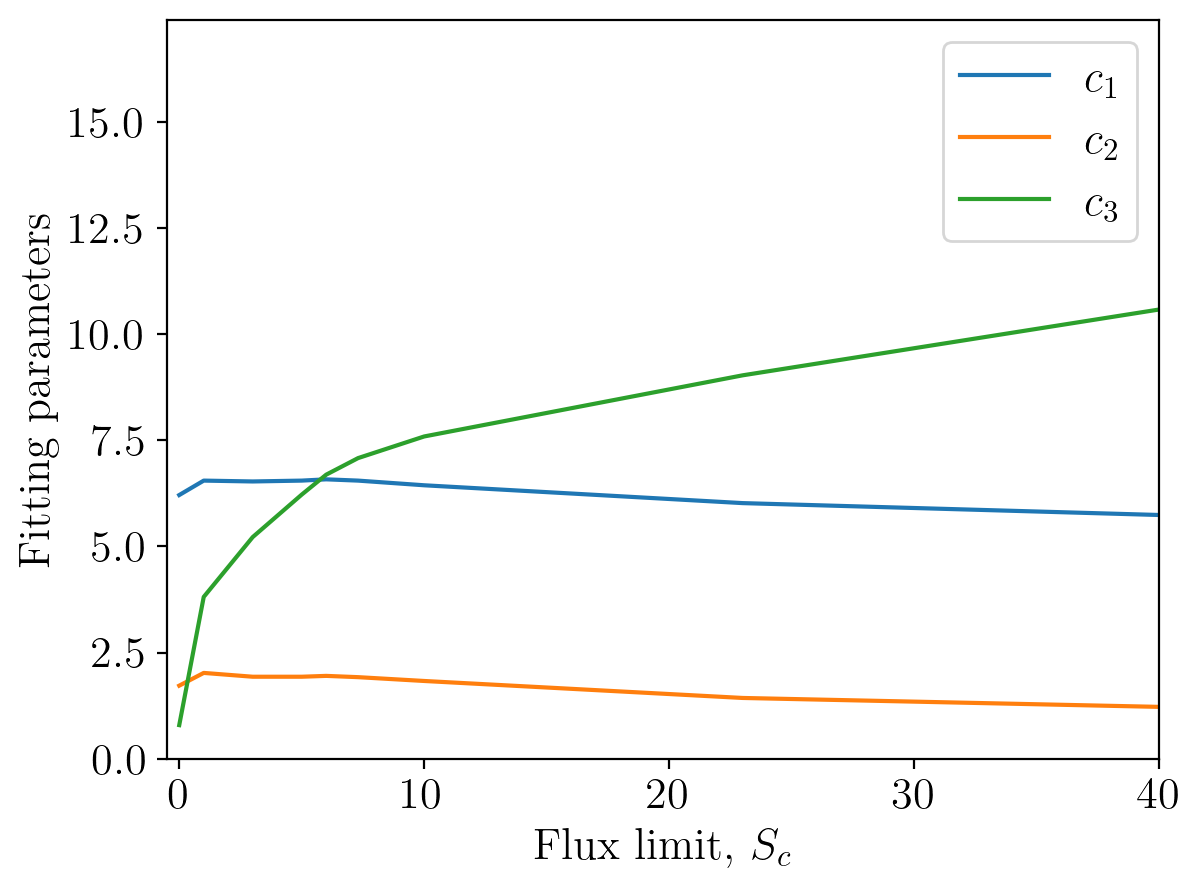

In [7]:
plt.plot(Sc, c1, label=r'$c_1$')
plt.plot(Sc, c2, label=r'$c_2$')
plt.plot(Sc, c3, label=r'$c_3$')

plt.xlabel(r'Flux limit, $S_{c}$')
plt.ylabel(r'Fitting parameters')
plt.xlim((-0.5,40))
plt.legend();

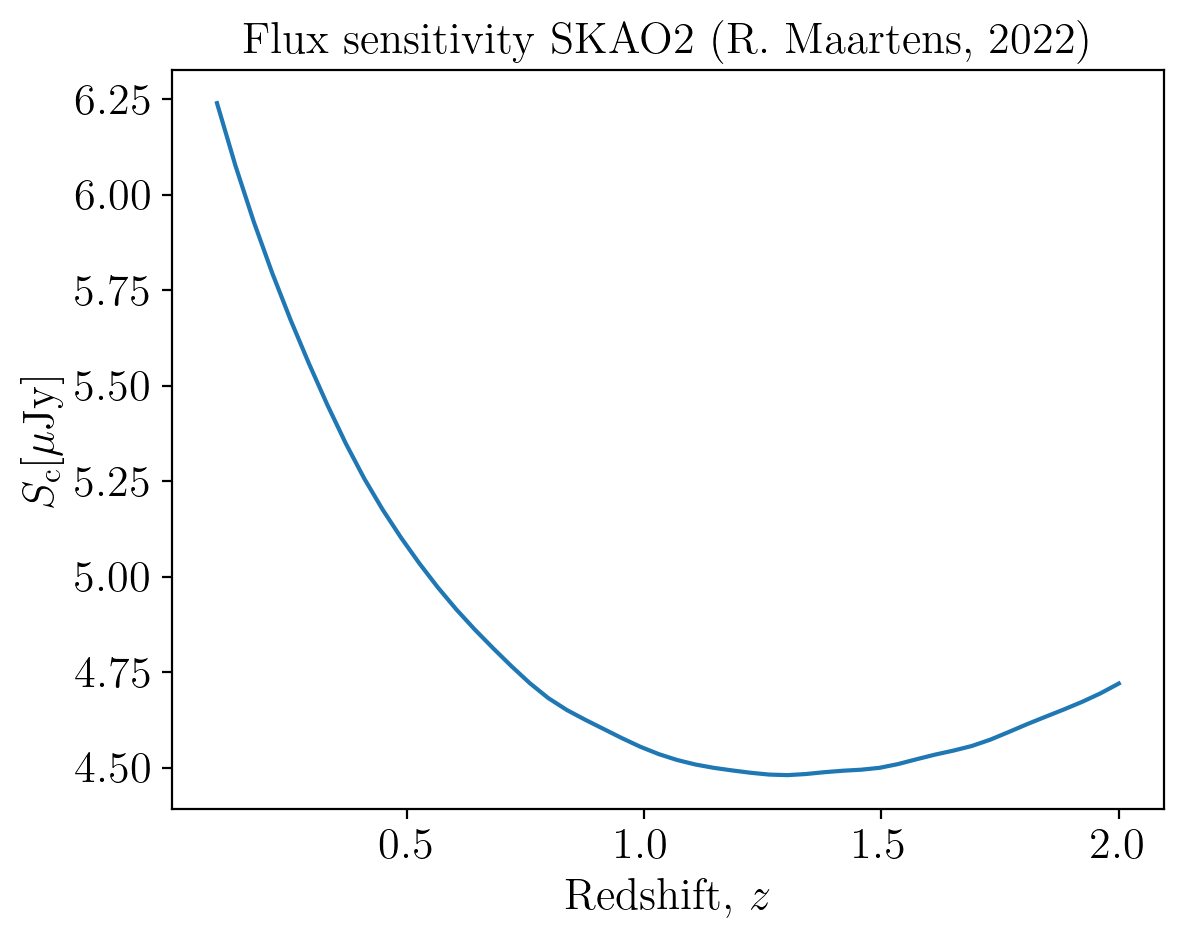

In [8]:
# From R. Maartens et a.l. (2022)

zSKA = np.linspace(0.1, 2.0)

z_data = np.linspace(0.1, 2.0, 20)

Srms_Roy = np.array([6.24, 5.85, 5.54, 5.28, 5.08, 4.92, 4.79, 4.68, 4.61, 4.55, 4.51, 4.49, 4.48, 4.49, 4.5, 4.53, 4.56, 4.61, 4.66, 4.72])

Srms_fitz = interp.interp1d(z_data, Srms_Roy, kind='cubic', fill_value='extrapolate')

plt.plot(zSKA, Srms_fitz(zSKA))
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$S_\mathrm{c}[\mu\mathrm{Jy}]$')
plt.title(r'Flux sensitivity SKAO2 (R. Maartens, 2022)')
plt.show()

In [9]:
z_data

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [226]:
# Fitting function for N

def N_g(z, Sc):
    return 10**c1_int(Sc) * z**c2_int(Sc) * np.exp(-c3_int(Sc)*z)

# Fitting functions in P. Bull (2016)

def N_g_fit(z, c1=6.319, c2=1.736, c3=5.423):
    return 10**c1 * z**c2 * np.exp(-c3*z)

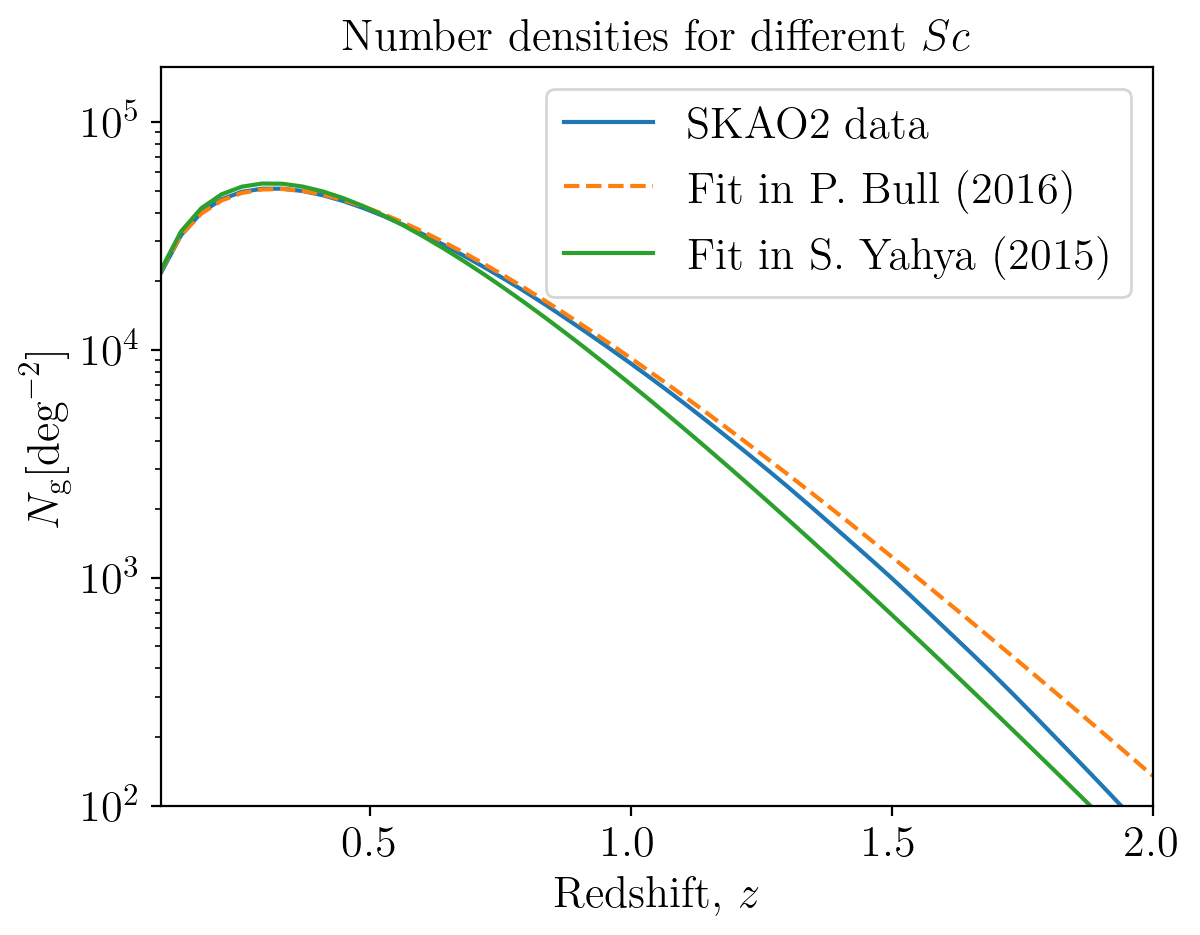

In [227]:
Ncut=10

Sc_fit = Srms_fitz(zSKA) * Ncut/10

plt.plot(zSKA, N_g(zSKA, Sc=Sc_fit), label='SKAO2 data')
plt.plot(zSKA, N_g_fit(zSKA), '--', label='Fit in P. Bull (2016)')
plt.plot(zSKA, N_g(zSKA, Sc=5.0), label='Fit in S. Yahya (2015)')

plt.ylim(bottom = 100, top = 175000)
plt.xlim(0.1, 2.0)
plt.yscale('log')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}}[\mathrm{deg}^{-2}]$')
plt.title(r'Number densities for different $Sc$')
plt.legend()


## Magnification bias

We try to apply the same approach as in the biasfuncs.py script. 

For the magnification bias, we take $\log{N_{g}}$ and numerically solve for the flux cuts of the bright population so that we have the same amount of bright and faint galaxies per redshift bin. We take the information of the full SKA Phase 2 survey in this case. 

Now, the $s_{\mathrm{model}}$ is not taken from the fitting function in [S. Camera et a.l. (2016)](https://arxiv.org/abs/1409.8286), but the numerical derivative of $\log{N_{g}}$. 

$$s_{\mathrm{model}} = - \frac{2}{5} \frac{\partial\log{N_{\mathrm{g}}(z, S_{\mathrm{c}})}}{\partial\log{S_{\mathrm{c}}}} = \frac{2}{5}\,\mathcal{Q}$$

In [228]:
# Define the functions

def stencil_derivative(fun, x, h=0.001):
    if type(x) == list:
        x=np.array(x)    
    d = (-fun(x+2*h) + 8*fun(x+h) - 8*fun(x-h) + fun(x-2*h))/(12*h)
    return d

def LogN_g(z, Sc):
    #return np.log(10**c1_int(Sc) * z**c2_int(Sc) * np.exp(-c3_int(Sc)*z))
    return np.log(N_g(z,Sc))

def sc_equation(x, z, Sc, n_split=2):
    return np.log(n_split) + LogN_g(z, x) - LogN_g(z, Sc)

def sc_solver(z, Sc, n_split, guess):
        sol = opt.fsolve(sc_equation, guess, args=(z,Sc,n_split))
        return sol


In [229]:
# Calculate the flux cuts for the bright population

Ncut = 10

Sc_data = Srms_fitz(z_data) * Ncut/10

n_split = 2.

guess = np.array([1.]*len(z_data))

Sc_bright = sc_solver(z=z_data, Sc=Sc_data, n_split=n_split, guess=guess)

print(np.log(Sc_bright))

[3.79200477 2.82129841 2.49756396 2.32140605 2.19284828 2.08988111
 2.00513361 1.93368815 1.87680415 1.82772122 1.78800271 1.75735487
 1.73304632 1.71658474 1.70282105 1.69565301 1.69020909 1.69055349
 1.6920217  1.69658188]


In [230]:
print(np.log(Sc_data))

[1.83098018 1.76644166 1.7119945  1.6639261  1.62531126 1.59330853
 1.56653041 1.54329811 1.52822786 1.51512723 1.50629715 1.5018527
 1.49962305 1.5018527  1.5040774  1.51072194 1.51732262 1.52822786
 1.53901545 1.5518088 ]


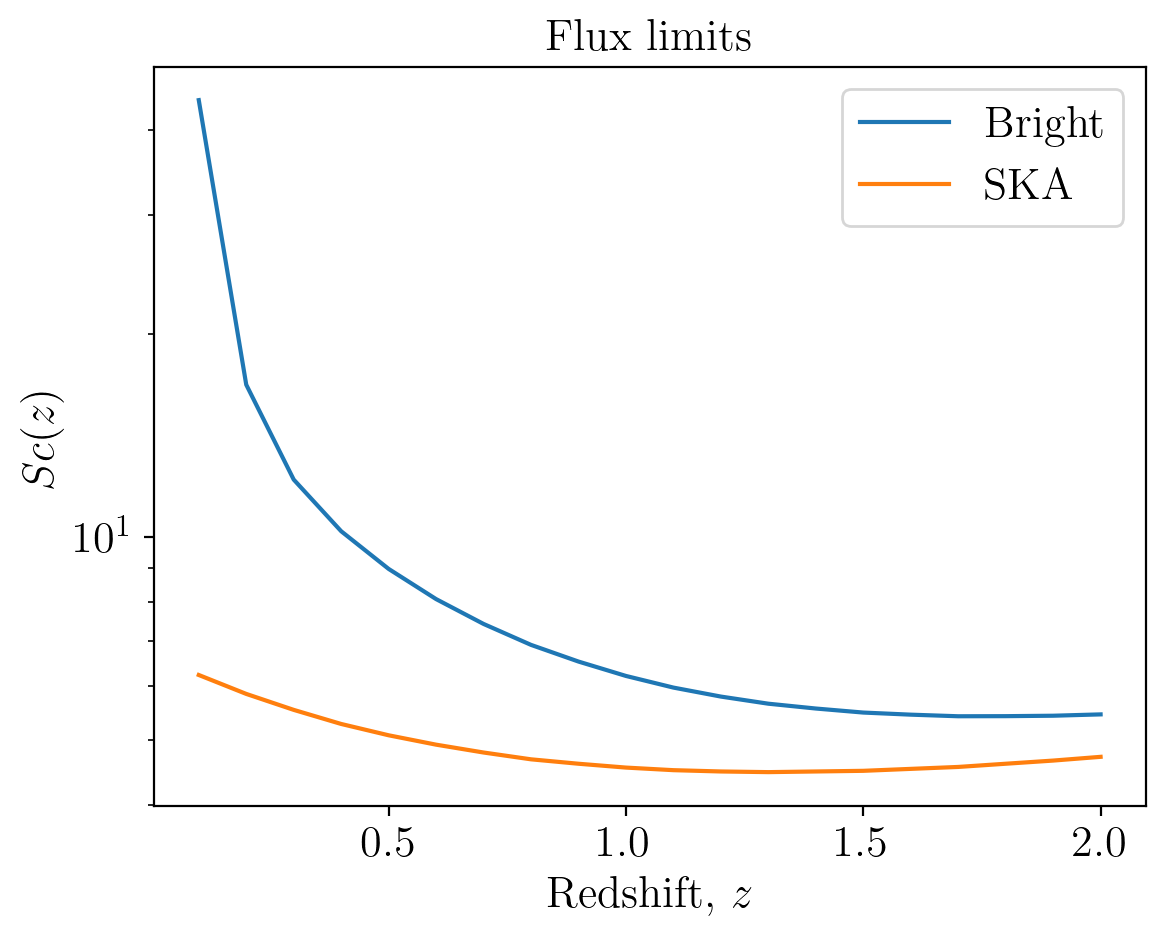

In [231]:
plt.plot(z_data, Sc_bright, label='Bright')
plt.plot(z_data, Sc_data, label='SKA')

plt.title(r'Flux limits')
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$Sc(z)$')
plt.yscale('log')
plt.legend()

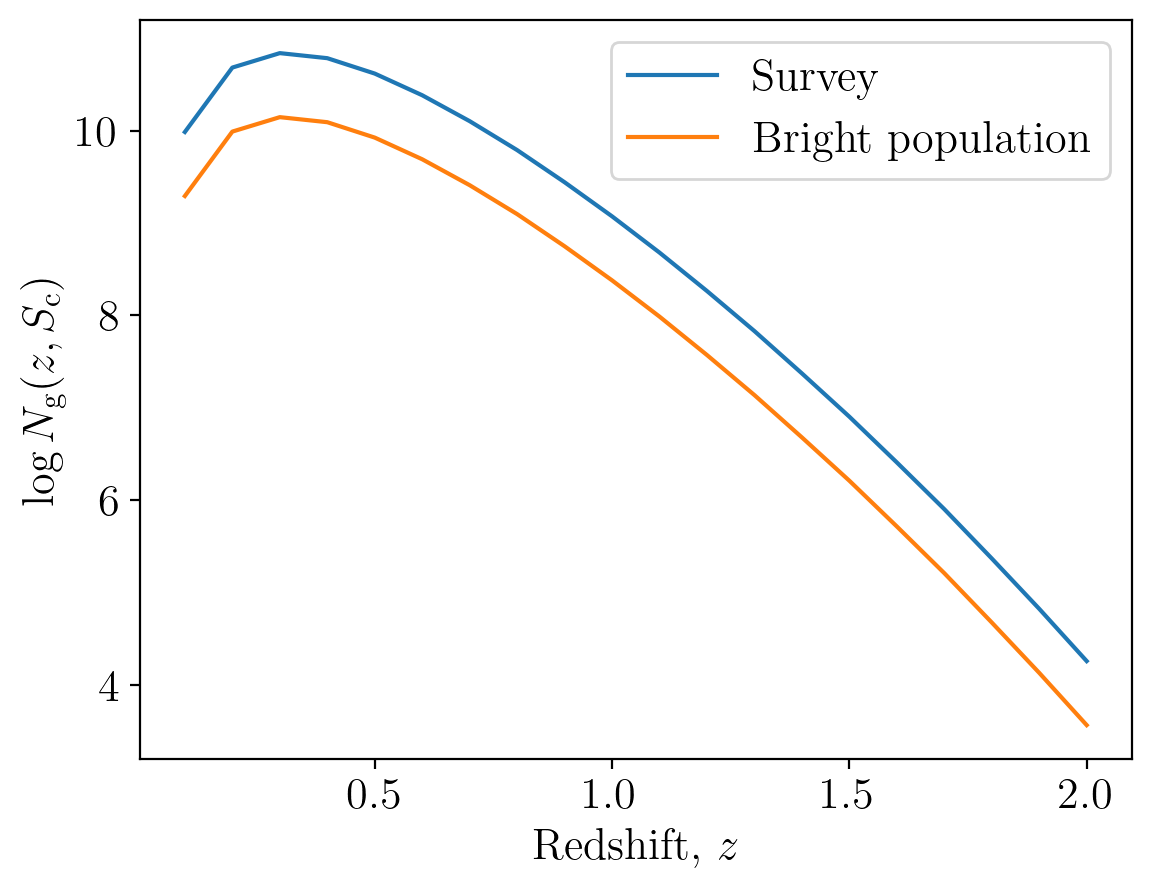

In [232]:
plt.plot(z_data, LogN_g(z_data, Sc_data), label='Survey')
plt.plot(z_data, LogN_g(z_data, Sc_bright), label='Bright population')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$\log{N_{\mathrm{g}}(z, S_{\mathrm{c}})}$')
plt.legend();

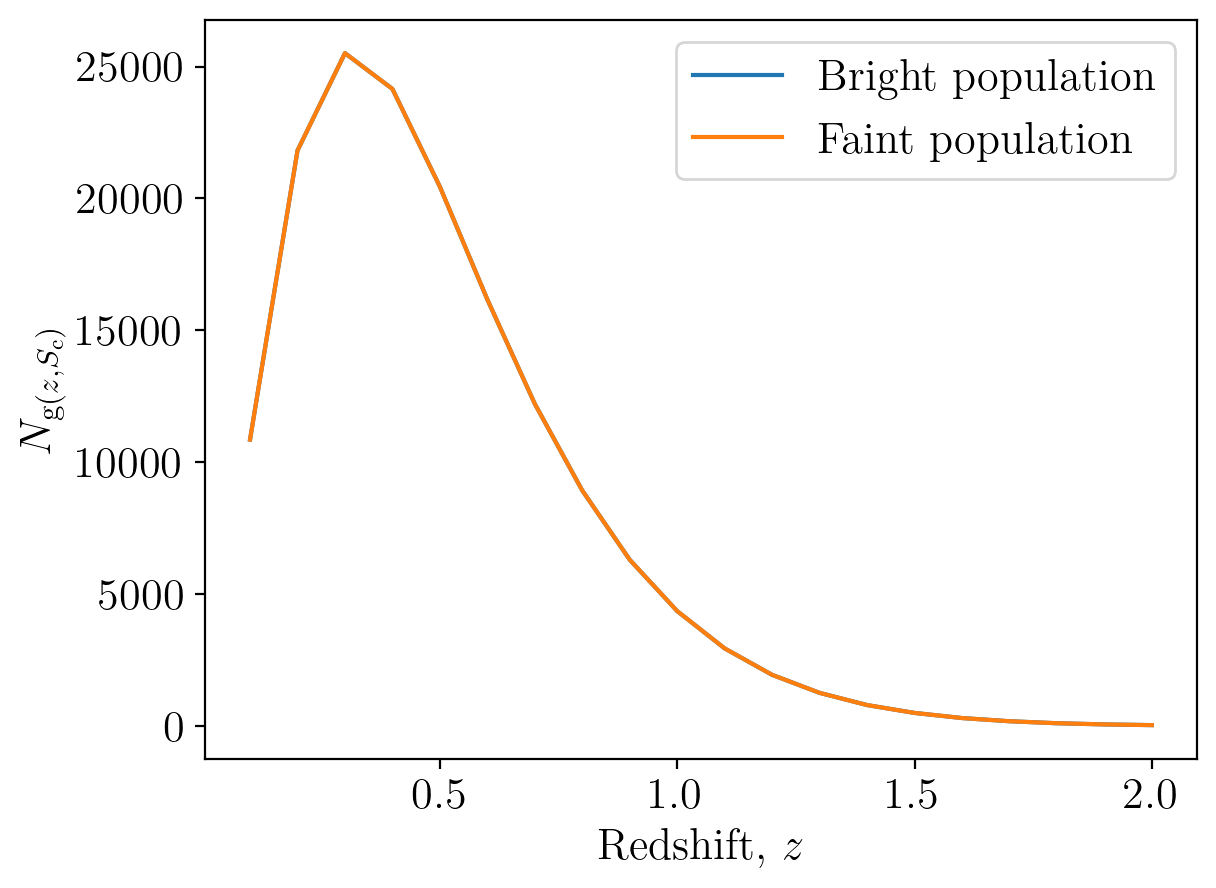

In [233]:
#plt.plot(z_data, np.exp(LogN_g(z_data, Sc_data)), label='Survey')
plt.plot(z_data, N_g(z_data, Sc_bright), label='Bright population')
plt.plot(z_data, N_g(z_data, Sc_data) - N_g(z_data, Sc_bright), label='Faint population')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}(z, S_{\mathrm{c}})}$')
plt.legend();

Using the fittin formula for $N_{\mathrm{g}}(z, S_{\mathrm{c}})$ of [S. Yahya et a.l. (2015)](https://arxiv.org/abs/1412.4700), it is convenient to find te logarithm of it:

$$ \log{N_{\mathrm{g}}(z, S_{\mathrm{c}})} = c_1(S_{\mathrm{c}})\,\log{10} + c_2(S_{\mathrm{c}})\,\log{z} - c_3(S_{\mathrm{c}})\,z$$

In [234]:
# Derivative of Qmodel as Log N_g with respect to log Sc

def Qmodel(z, Sc):
    res = - Sc * ( stencil_derivative(c1_int, x=Sc)*np.log(10) + stencil_derivative(c2_int, x=Sc)*np.log(z) - stencil_derivative(c3_int, x=Sc)*z )
    return res

# Magnification bias

def s_model(z, Sc):
    return 2/5 * Qmodel(z, Sc)

In [235]:
zSKA = np.array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95])

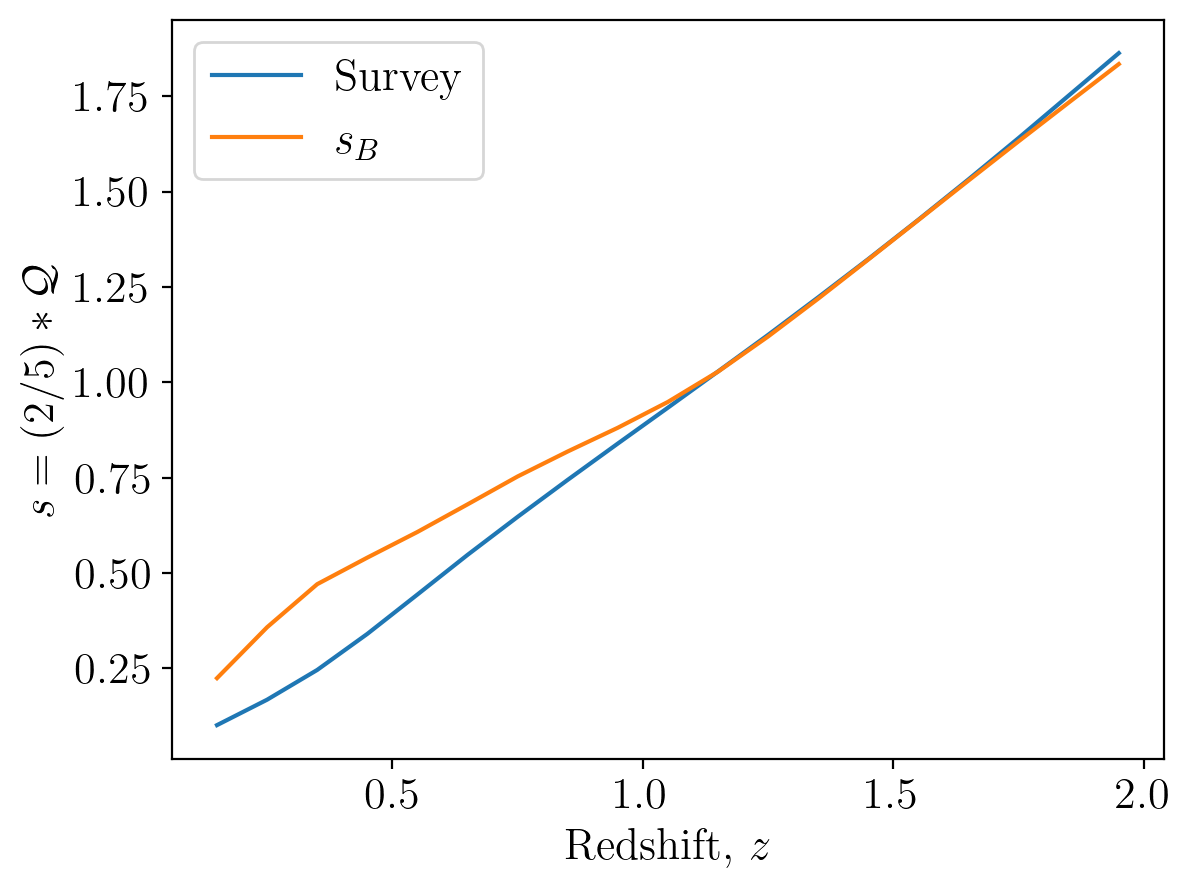

In [236]:
smodel_data = s_model(z_data, Sc_data)
smodelB_data = s_model(z_data, Sc_bright)

smodel = interp.interp1d(z_data, smodel_data, kind='cubic', fill_value='extrapolate')
smodelB = interp.interp1d(z_data, smodelB_data, kind='cubic', fill_value='extrapolate')

plt.plot(zSKA, smodel(zSKA), label='Survey')
plt.plot(zSKA, smodelB(zSKA), label='$s_B$')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$s = (2/5) * \mathcal{Q}$')
plt.legend();

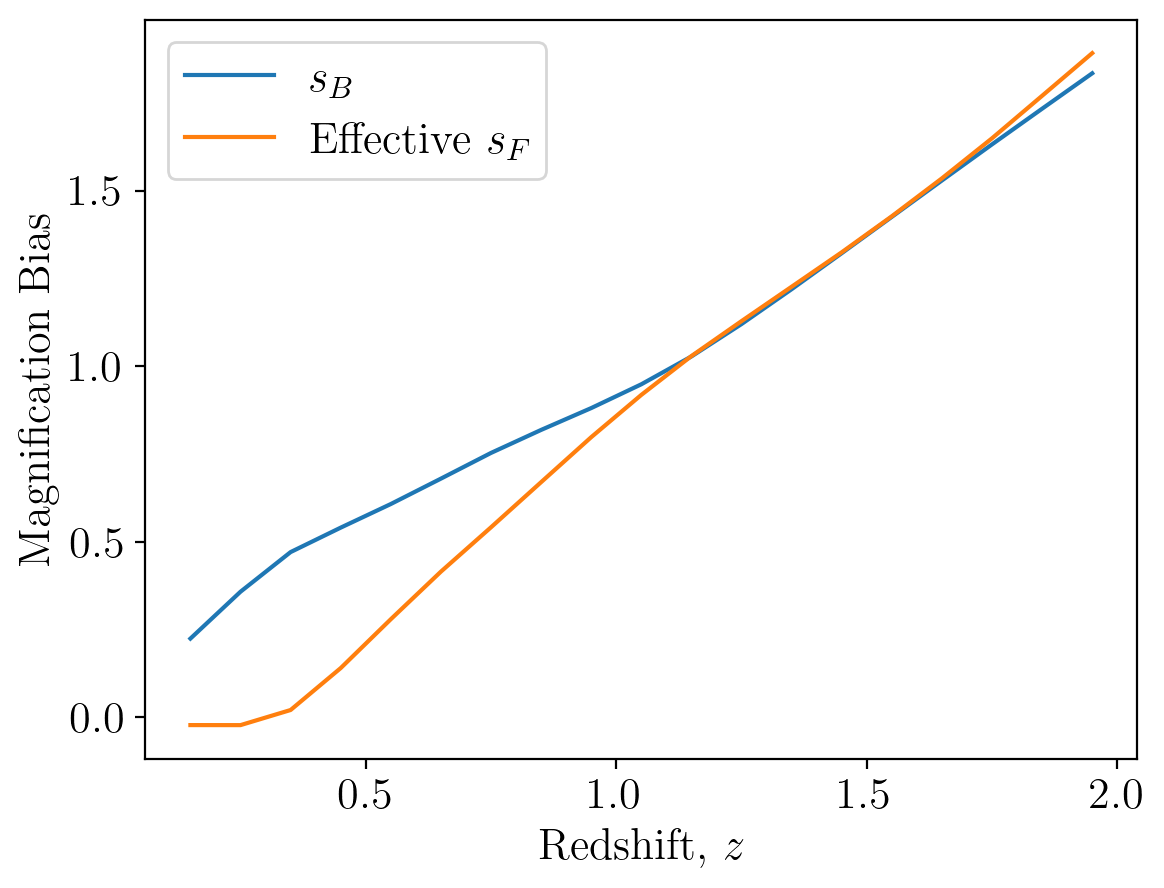

In [237]:
sBright = smodelB(z_data)
sFaint = n_split * smodel(z_data) - smodelB(z_data)

#plt.plot(z_data, sBright, 'r.',label='$s_B$, SKA2')
#plt.plot(z_data, sFaint, 'k.',label='$s_F$ SKA2')

plt.plot(zSKA, smodelB(zSKA), label='$s_B$')
plt.plot(zSKA, n_split*smodel(zSKA) - smodelB(zSKA), label='Effective $s_F$')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'Magnification Bias')
plt.legend();

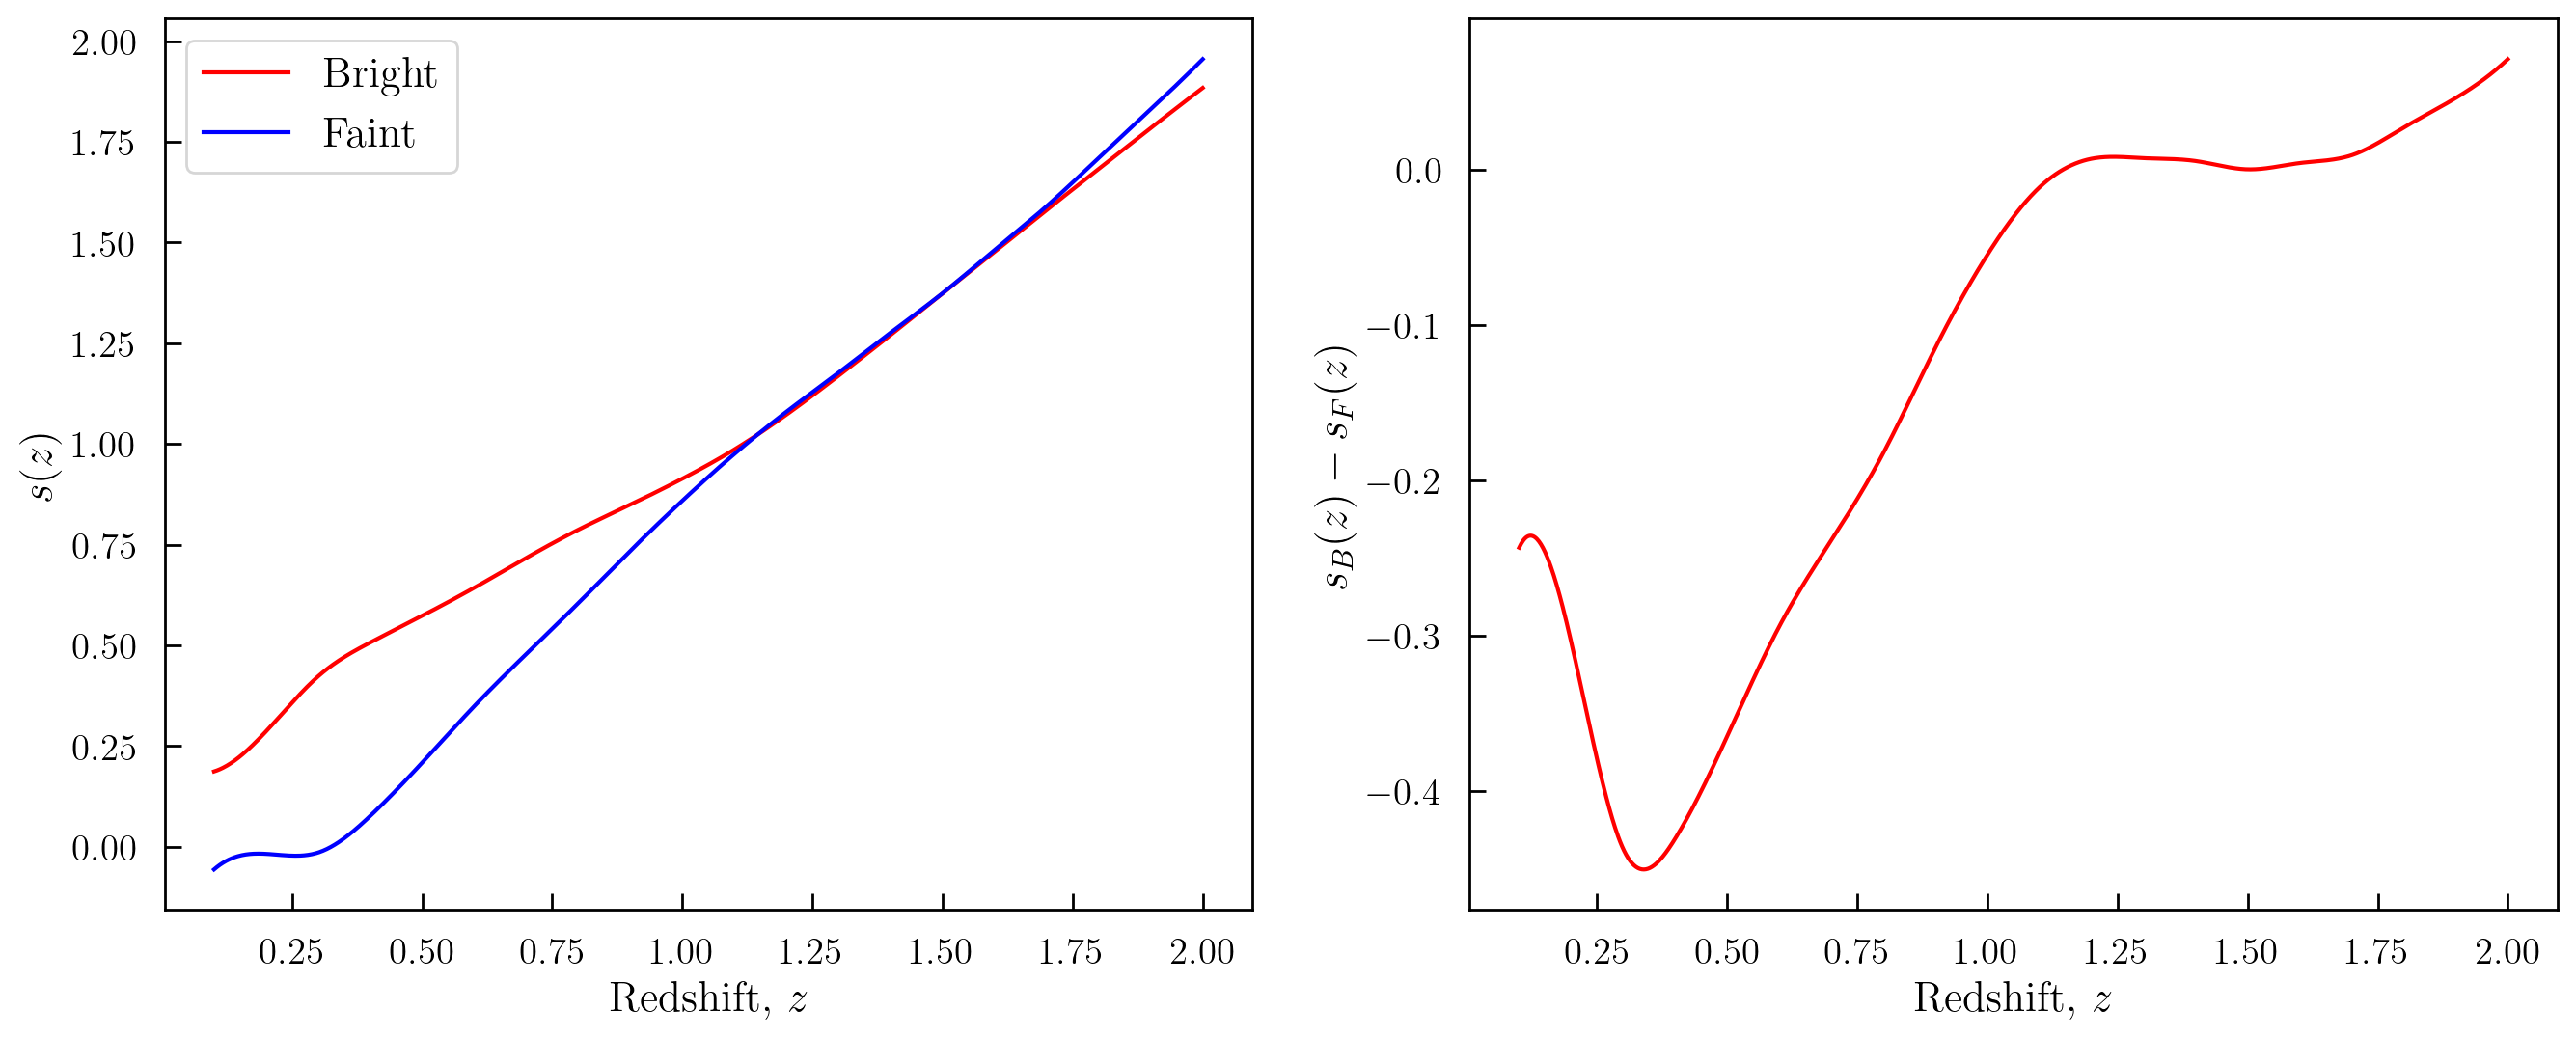

In [238]:
zs = np.linspace(0.1, 2.0, 1000)

sB = smodelB(zs)
sF = n_split * smodel(zs) - smodelB(zs)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zs, sB, color = 'r', label = 'Bright')
ax[0].plot(zs, sF, color = 'b', label = 'Faint')
#ax[0].plot(z_data, smodelF(z_data), '.', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$s(z)$');
ax[0].legend();

ax[1].plot(zs, sF-sB, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$s_{B}(z)-s_{F}(z)$');
ax[1].set_ylim();

## Evolution bias

We want to calculate the evolution bias for the two populations of galaxies. We follow [R. Maartens et a.l. (2022)](https://arxiv.org/abs/2107.13401), where

$$f_\mathrm{model} = -\frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} - \frac{d\log{H}}{d\log{(1+z)}} + 2\,\frac{(1+z)}{r\,H} - \left[2\,\left(1+\frac{1+z}{r\,H}\right) + \frac{d\log{Sc}}{d\log{1+z}}\right]\,\mathcal{Q}$$

Where after splitting the populations, we should use $N_\mathrm{g}$ and $\mathcal{Q}$ of each population. 

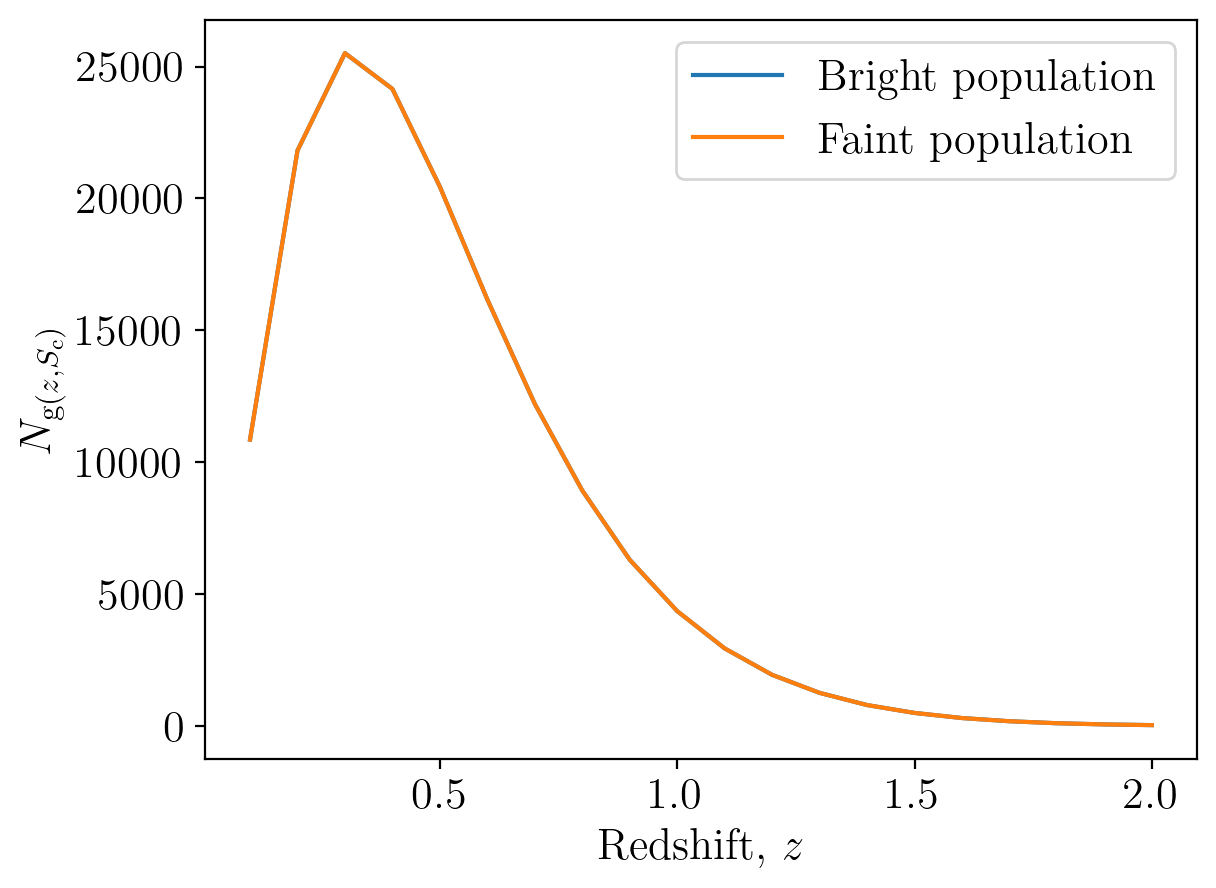

In [239]:
#plt.plot(z_data, np.exp(LogN_g(z_data, Sc_data)), label='Survey')
plt.plot(z_data, N_g(z_data, Sc_bright), label='Bright population')
plt.plot(z_data, N_g(z_data, Sc_data) - N_g(z_data, Sc_bright), label='Faint population')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}(z, S_{\mathrm{c}})}$')
plt.legend();

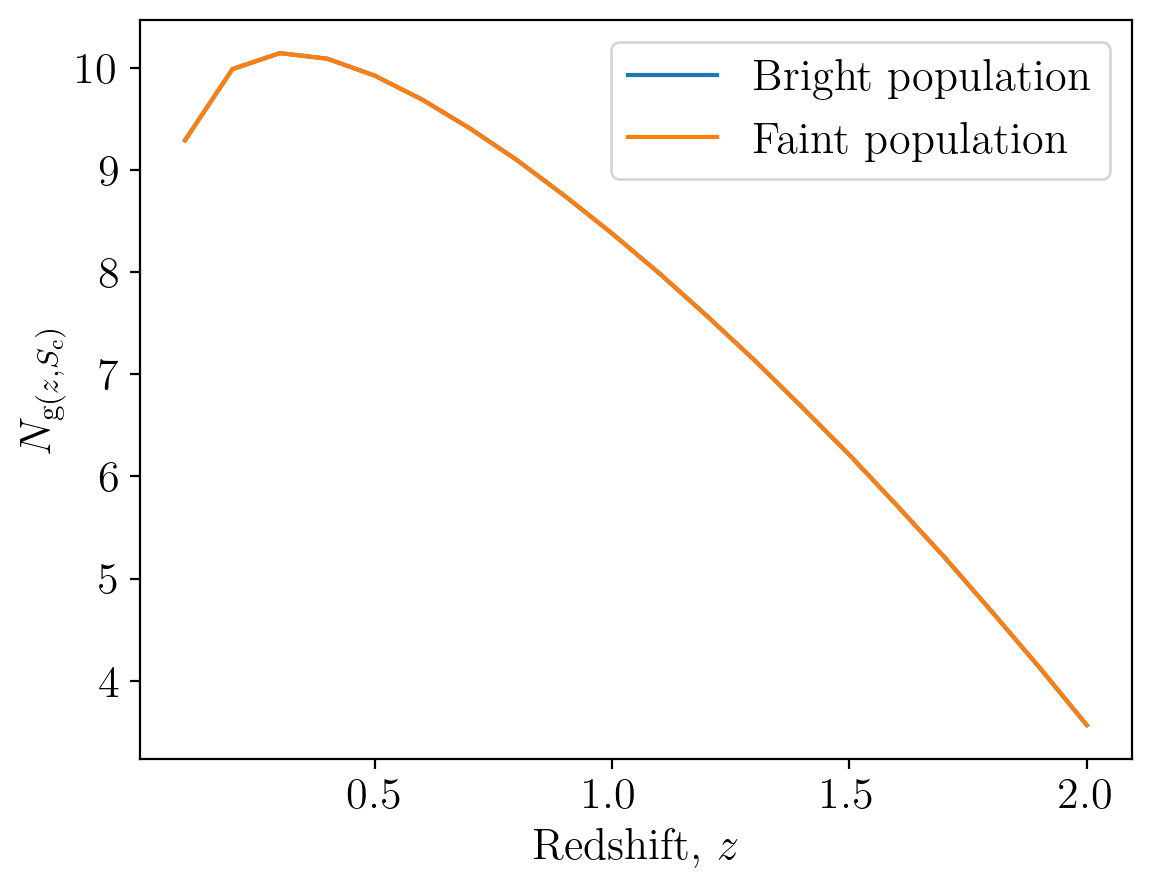

In [240]:
#plt.plot(z_data, np.exp(LogN_g(z_data, Sc_data)), label='Survey')
plt.plot(z_data, np.log(N_g(z_data, Sc_bright)), label='Bright population')
plt.plot(z_data, np.log(N_g(z_data, Sc_data) - N_g(z_data, Sc_bright)), label='Faint population')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}(z, S_{\mathrm{c}})}$')
plt.legend();

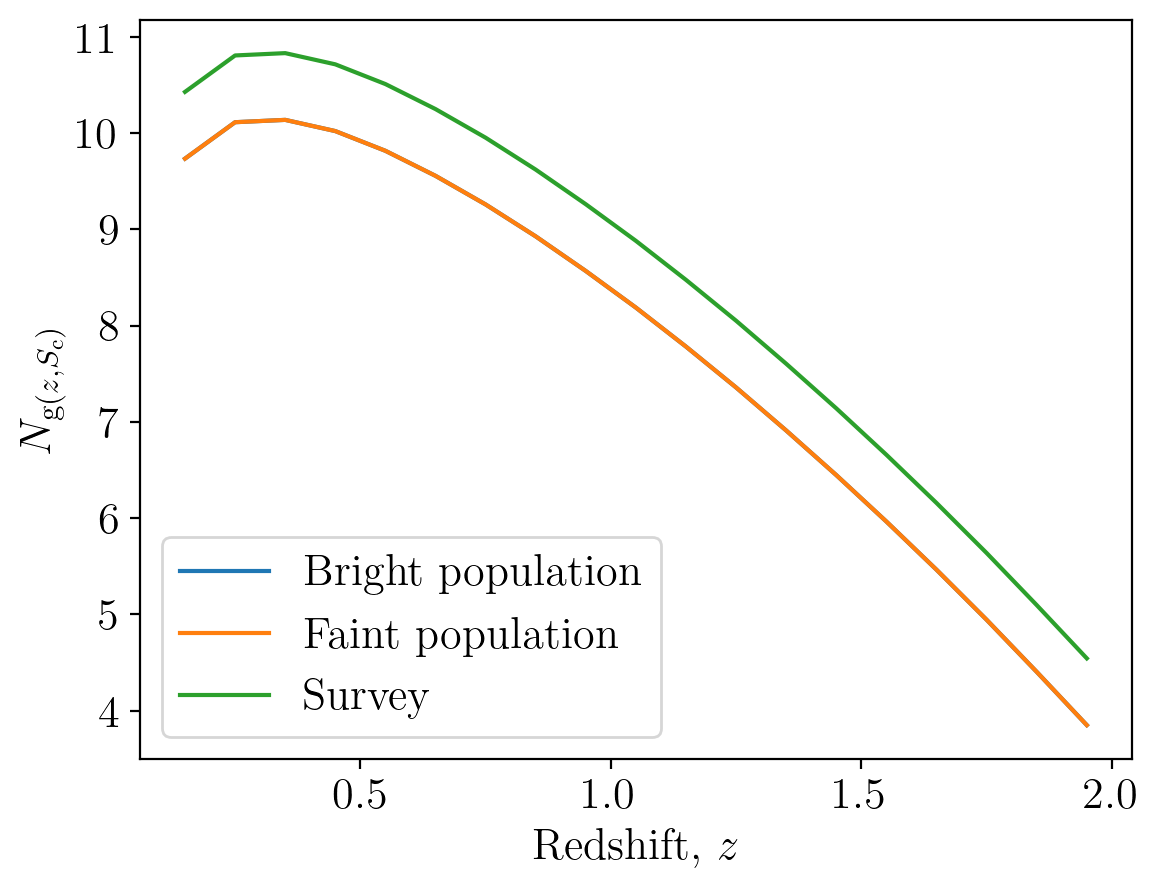

In [241]:
LogN_z = interp.interp1d(z_data, np.log(N_g(z_data, Sc_data)), kind='cubic', fill_value='extrapolate')
LogNB_z = interp.interp1d(z_data, np.log(N_g(z_data, Sc_bright)), kind='cubic', fill_value='extrapolate')
LogNF_z = interp.interp1d(z_data, np.log(N_g(z_data, Sc_data) - N_g(z_data, Sc_bright)), kind='cubic', fill_value='extrapolate')

#plt.plot(z_data, np.exp(LogN_g(z_data, Sc_data)), label='Survey')
plt.plot(zSKA, LogNB_z(zSKA), label='Bright population')
plt.plot(zSKA, LogNF_z(zSKA), label='Faint population')
plt.plot(zSKA, LogN_z(zSKA), label = 'Survey')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}(z, S_{\mathrm{c}})}$')
plt.legend();

In [242]:
# Define the contributions which do not depend on the population

from scipy.integrate import quad

def r_(z, Om = 0.3111, h=0.677):
    if type(z) == list:
        z=np.array(z)
    c = 299792.458
    H0 = 100*h/c # Mpc^{-1} units
    Oml = 1-Om
    # Comoving distance
    result = quad(lambda x: 1/(H0*np.sqrt(Om * (1+x)**3 + Oml)), 0, z)
    value=result[0]
    return np.array(value)

r=np.vectorize(r_)

def H(z, Om = 0.3111, h=0.677):
    if type(z) == list:
        z=np.array(z)
    c = 299792.458
    H0 = 100*h/c
    H = H0 * np.sqrt(Om*(1+np.array(z))**3 + (1-Om))
    return H
    
def dlogH_f(z, Om=0.3111, h=0.677):
    z = np.array(z)
    c = 299792.458
    H0 = 100*h/c
    derivative = H0**2/2 * (3*Om*(1+z)**2) / (H(z)**2)
    return derivative

def stencil_derivative(fun, x, h=0.001):
    if type(x) == list:
        x=np.array(x)    
    d = (-fun(x+2*h) + 8*fun(x+h) - 8*fun(x-h) + fun(x-2*h))/(12*h)
    return d

In [243]:
def Sc_z(z, Ncut=10):
    return Srms_fitz(z) * Ncut/10

def dlogN_dz(z, Sc, eps=0.0001):
    res = (1+z)*(c2_int(Sc)/z - c3_int(Sc) 
                 + (stencil_derivative(c1_int, x=Sc, h=eps)*np.log(10) + stencil_derivative(c2_int, x=Sc, h=eps)*np.log(z) - stencil_derivative(c3_int, x=Sc, h=eps)*z)*stencil_derivative(Sc_z, x=z, h=eps))
    return res

Text(0, 0.5, '$b_e$')

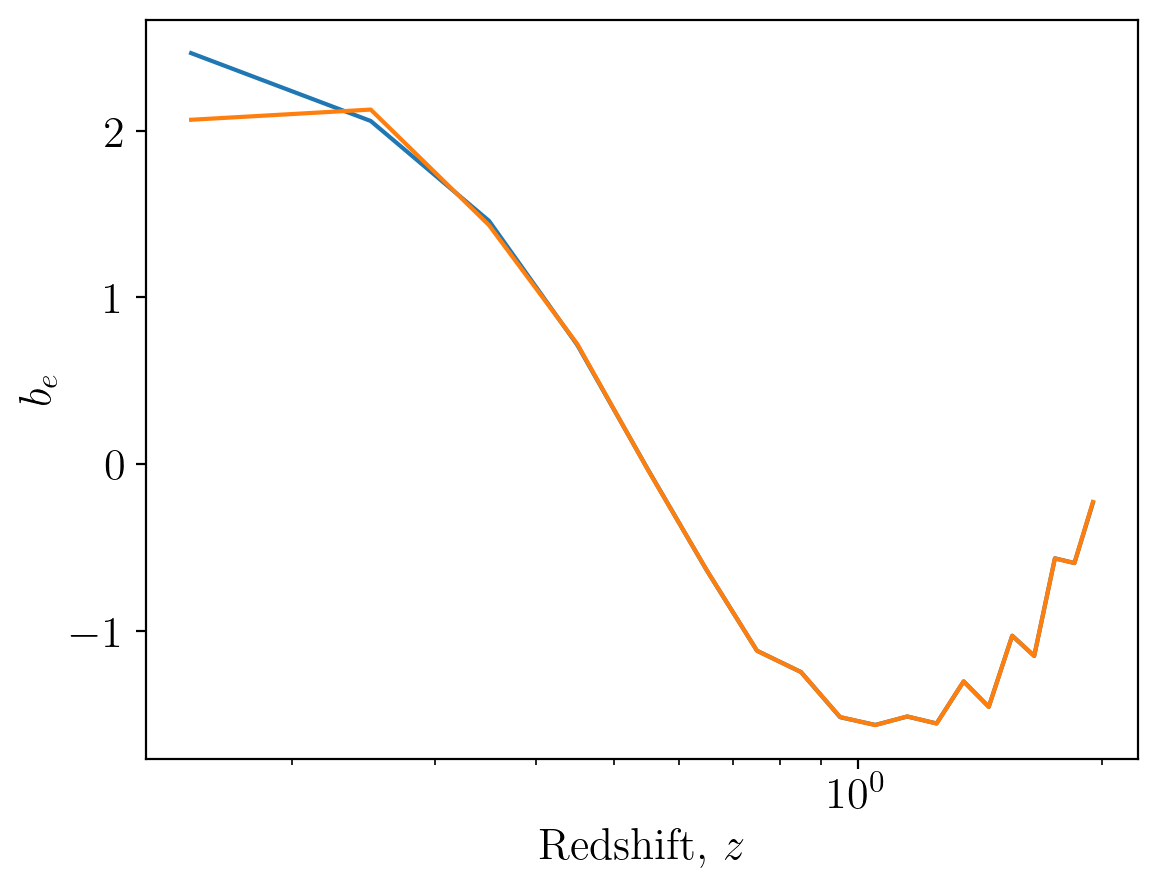

In [244]:
# Check be in R. Maartens et a.l. (2022)

rHterm_ = (1+zSKA)/(r(zSKA) * H(zSKA))

dlogH_ = (1+zSKA) * dlogH_f(zSKA)

Qterm_ = 2 * (1 + rHterm_) * 5/2 * smodel(zSKA)

dLogN = dlogN_dz(zSKA, Sc_z(zSKA), eps=0.0001)

dLogNb = (1+zSKA) * stencil_derivative(fun=LogN_z, x=zSKA, h=0.0001)

fevol = - dLogN - dlogH_ + 2 * rHterm_ - Qterm_
fevolb = - dLogNb - dlogH_ + 2 * rHterm_ - Qterm_

plt.plot(zSKA, fevol)
plt.plot(zSKA, fevolb)
plt.xlabel(r'Redshift, $z$')
plt.xscale('log')
plt.ylabel(r'$b_e$')

Text(0, 0.5, '$b_e$ error')

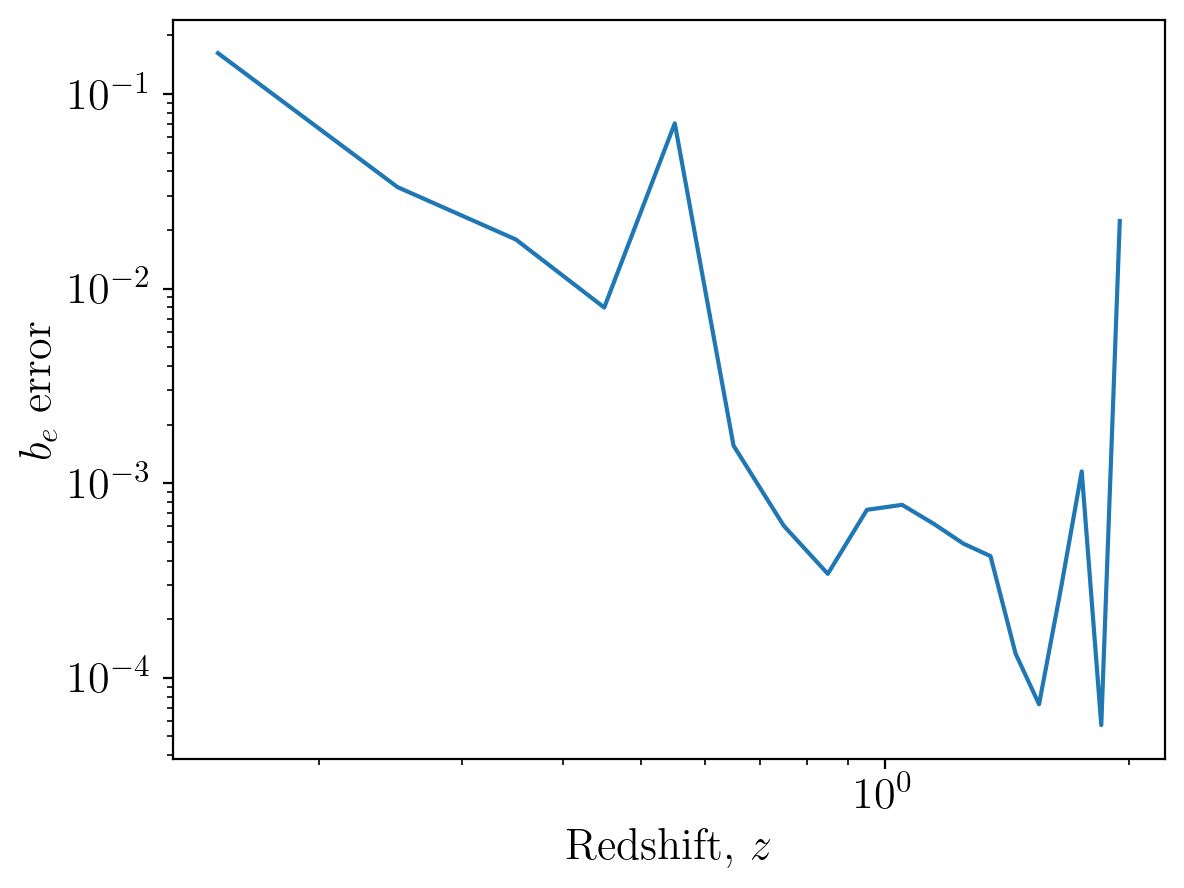

In [245]:
plt.plot(zSKA, np.abs(1-fevolb/fevol))
plt.xlabel(r'Redshift, $z$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$b_e$ error')

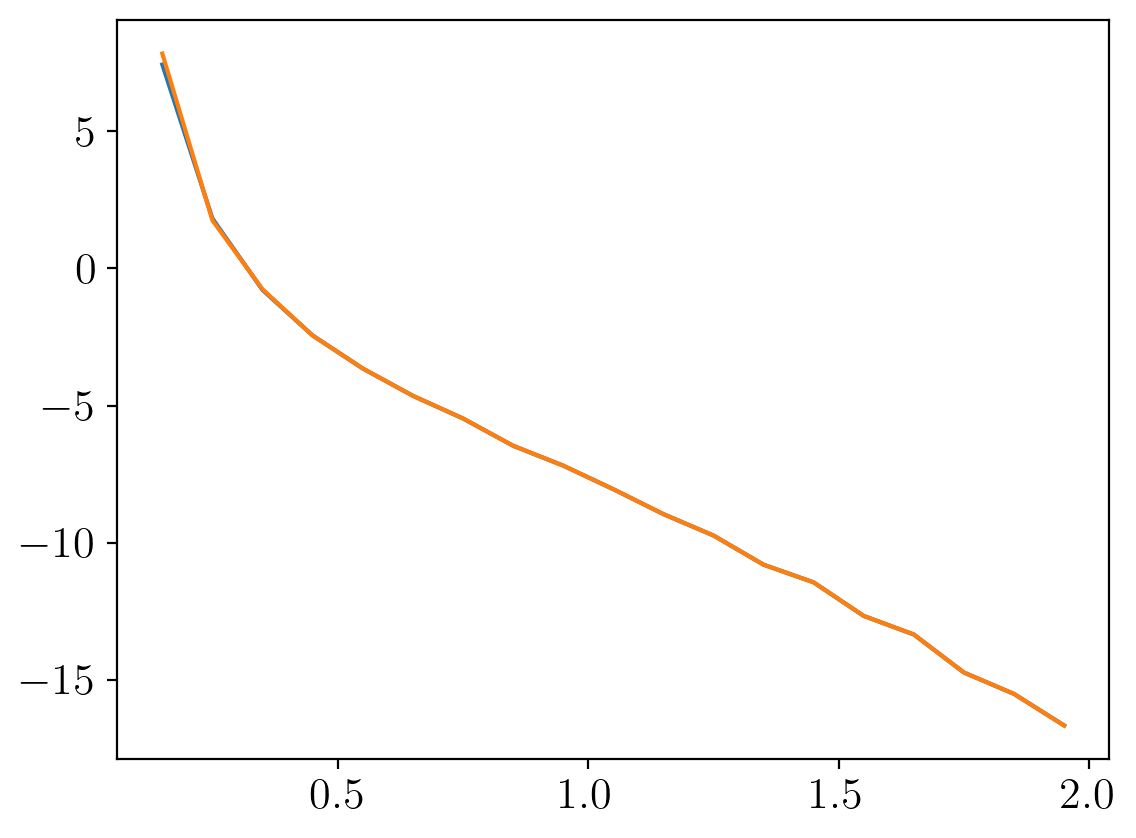

In [246]:
plt.plot(zSKA, dLogN)
plt.plot(zSKA, dLogNb)
#plt.xscale('log')


Text(0, 0.5, '$d\\log{N}$ error')

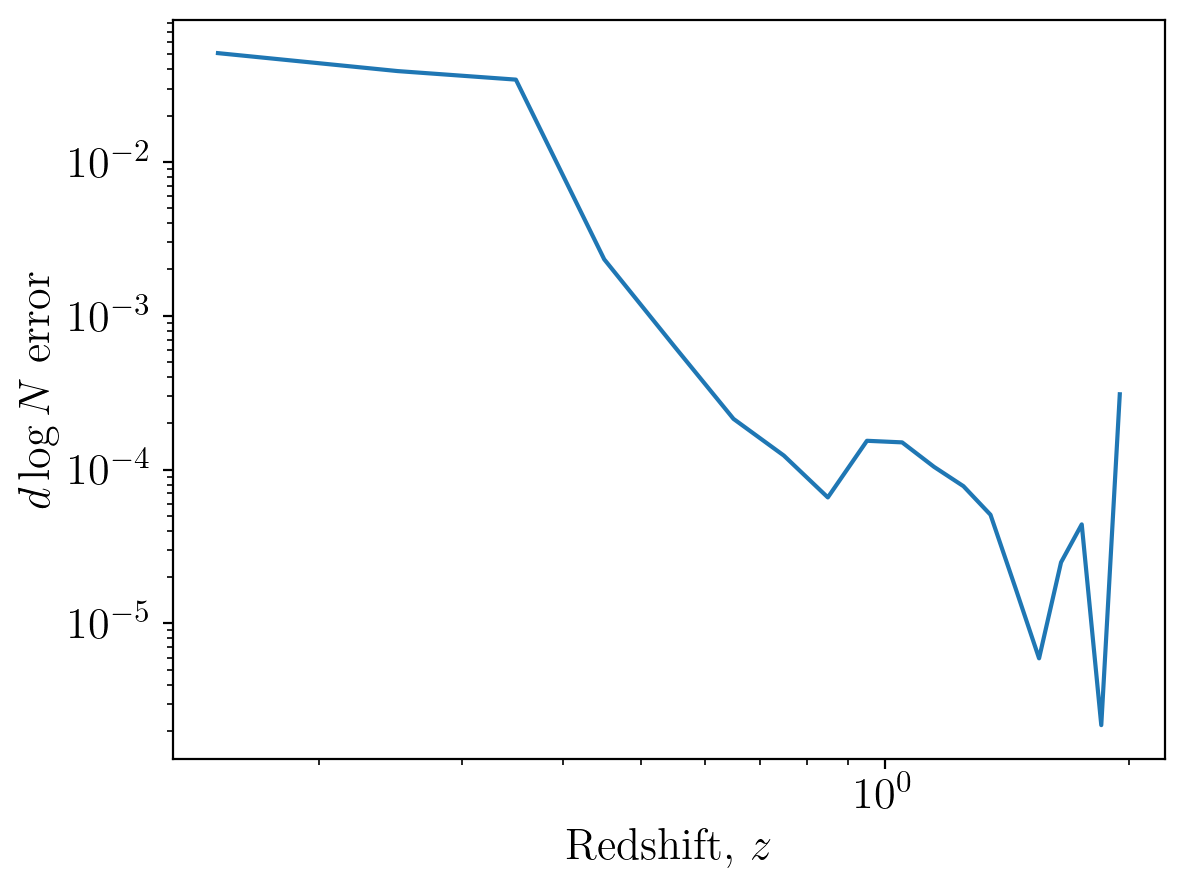

In [247]:
plt.plot(zSKA, np.abs(1 - dLogN/dLogNb))
plt.xlabel(r'Redshift, $z$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$d\log{N}$ error')


In [248]:
dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

dLogNB = (1+zSKA) * stencil_derivative(LogNB_z, zSKA)
dLogNF = (1+zSKA) * stencil_derivative(LogNF_z, zSKA)

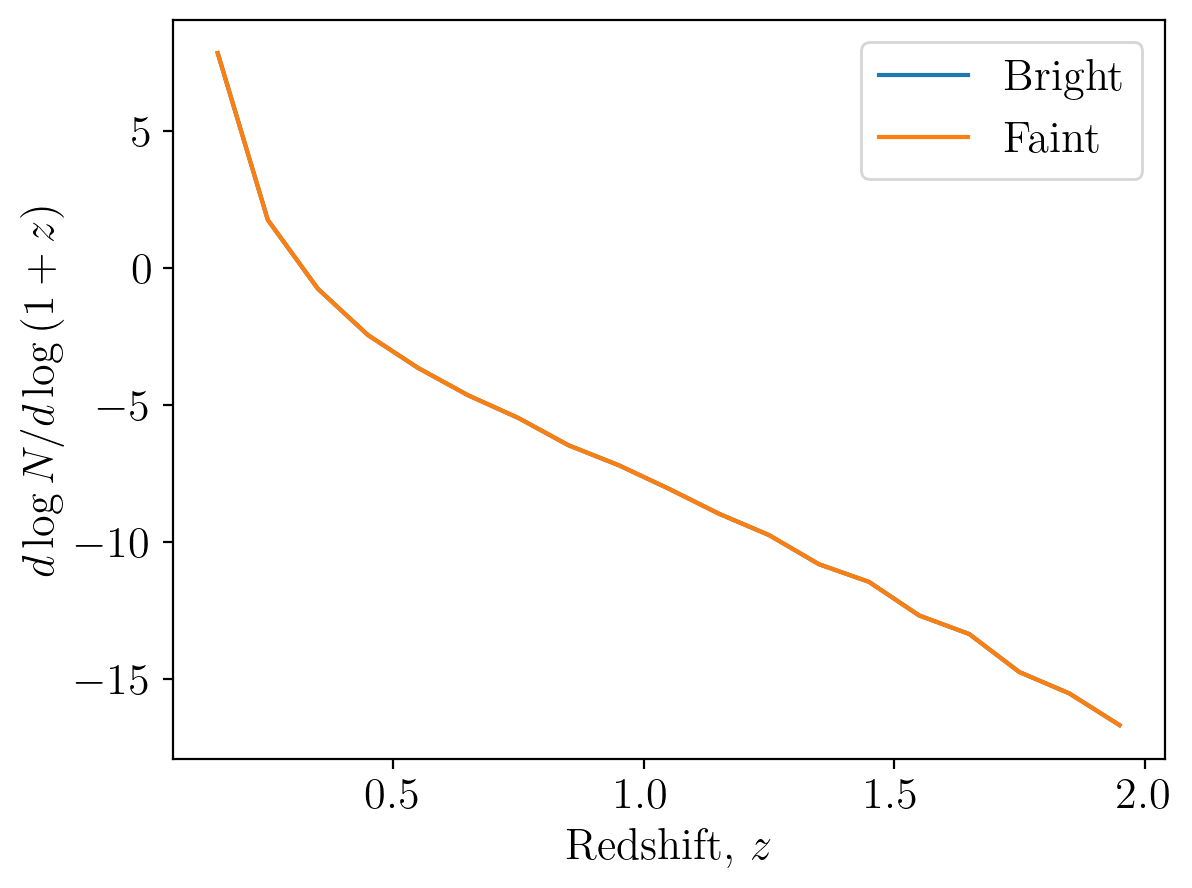

In [249]:
plt.plot(zSKA, dLogNB, label = 'Bright')
plt.plot(zSKA, dLogNF, label = 'Faint')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$d\log{N}/d\log{(1+z)}$')
plt.legend()
plt.show()

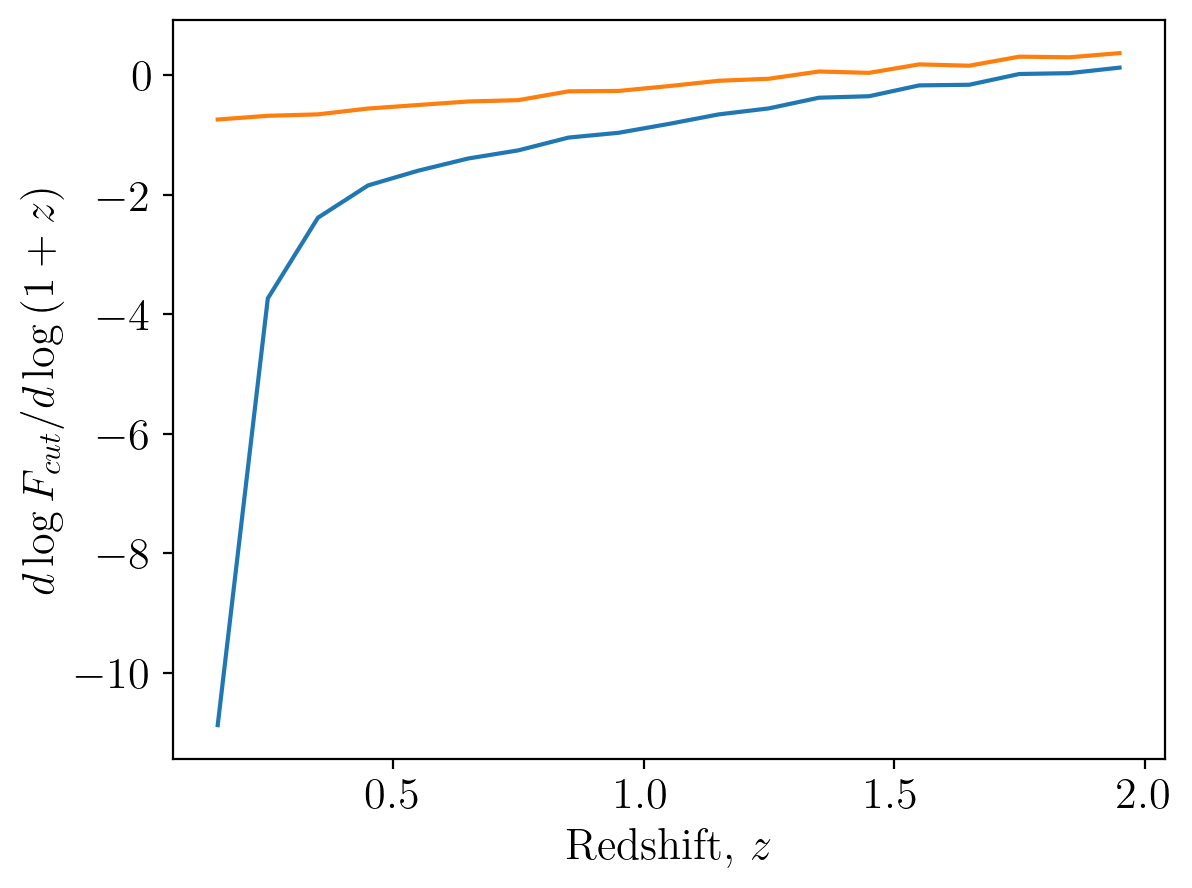

In [250]:
LogFcut = interp.interp1d(z_data, np.log(Sc_bright), kind='cubic', fill_value='extrapolate')
LogFstar = interp.interp1d(z_data, np.log(Sc_data), kind = 'cubic', fill_value='extrapolate')

dLogFcut = (1+zSKA) * stencil_derivative(LogFcut, zSKA)
dLogFstar = (1+zSKA) * stencil_derivative(LogFstar, zSKA)


plt.plot(zSKA, dLogFcut)
plt.plot(zSKA, dLogFstar)

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$d\log{F_{cut}}/d\log{(1+z)}$')
plt.show()

In [251]:
# Evolution bias

sB = smodelB(zSKA)
sF = n_split*smodel(zSKA) - smodelB(zSKA)

dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

dLogNB = (1+zSKA) * stencil_derivative(LogNB_z, zSKA)
dLogNF = (1+zSKA) * stencil_derivative(LogNF_z, zSKA)
dLogN = (1+zSKA) * stencil_derivative(LogN_z, zSKA)

dLogFcut = (1+zSKA) * stencil_derivative(LogFcut, zSKA)
dLogFstar = (1+zSKA) * stencil_derivative(LogFstar, zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB - 5/2*sB*dLogFcut
fevolF = - dLogNF - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar)

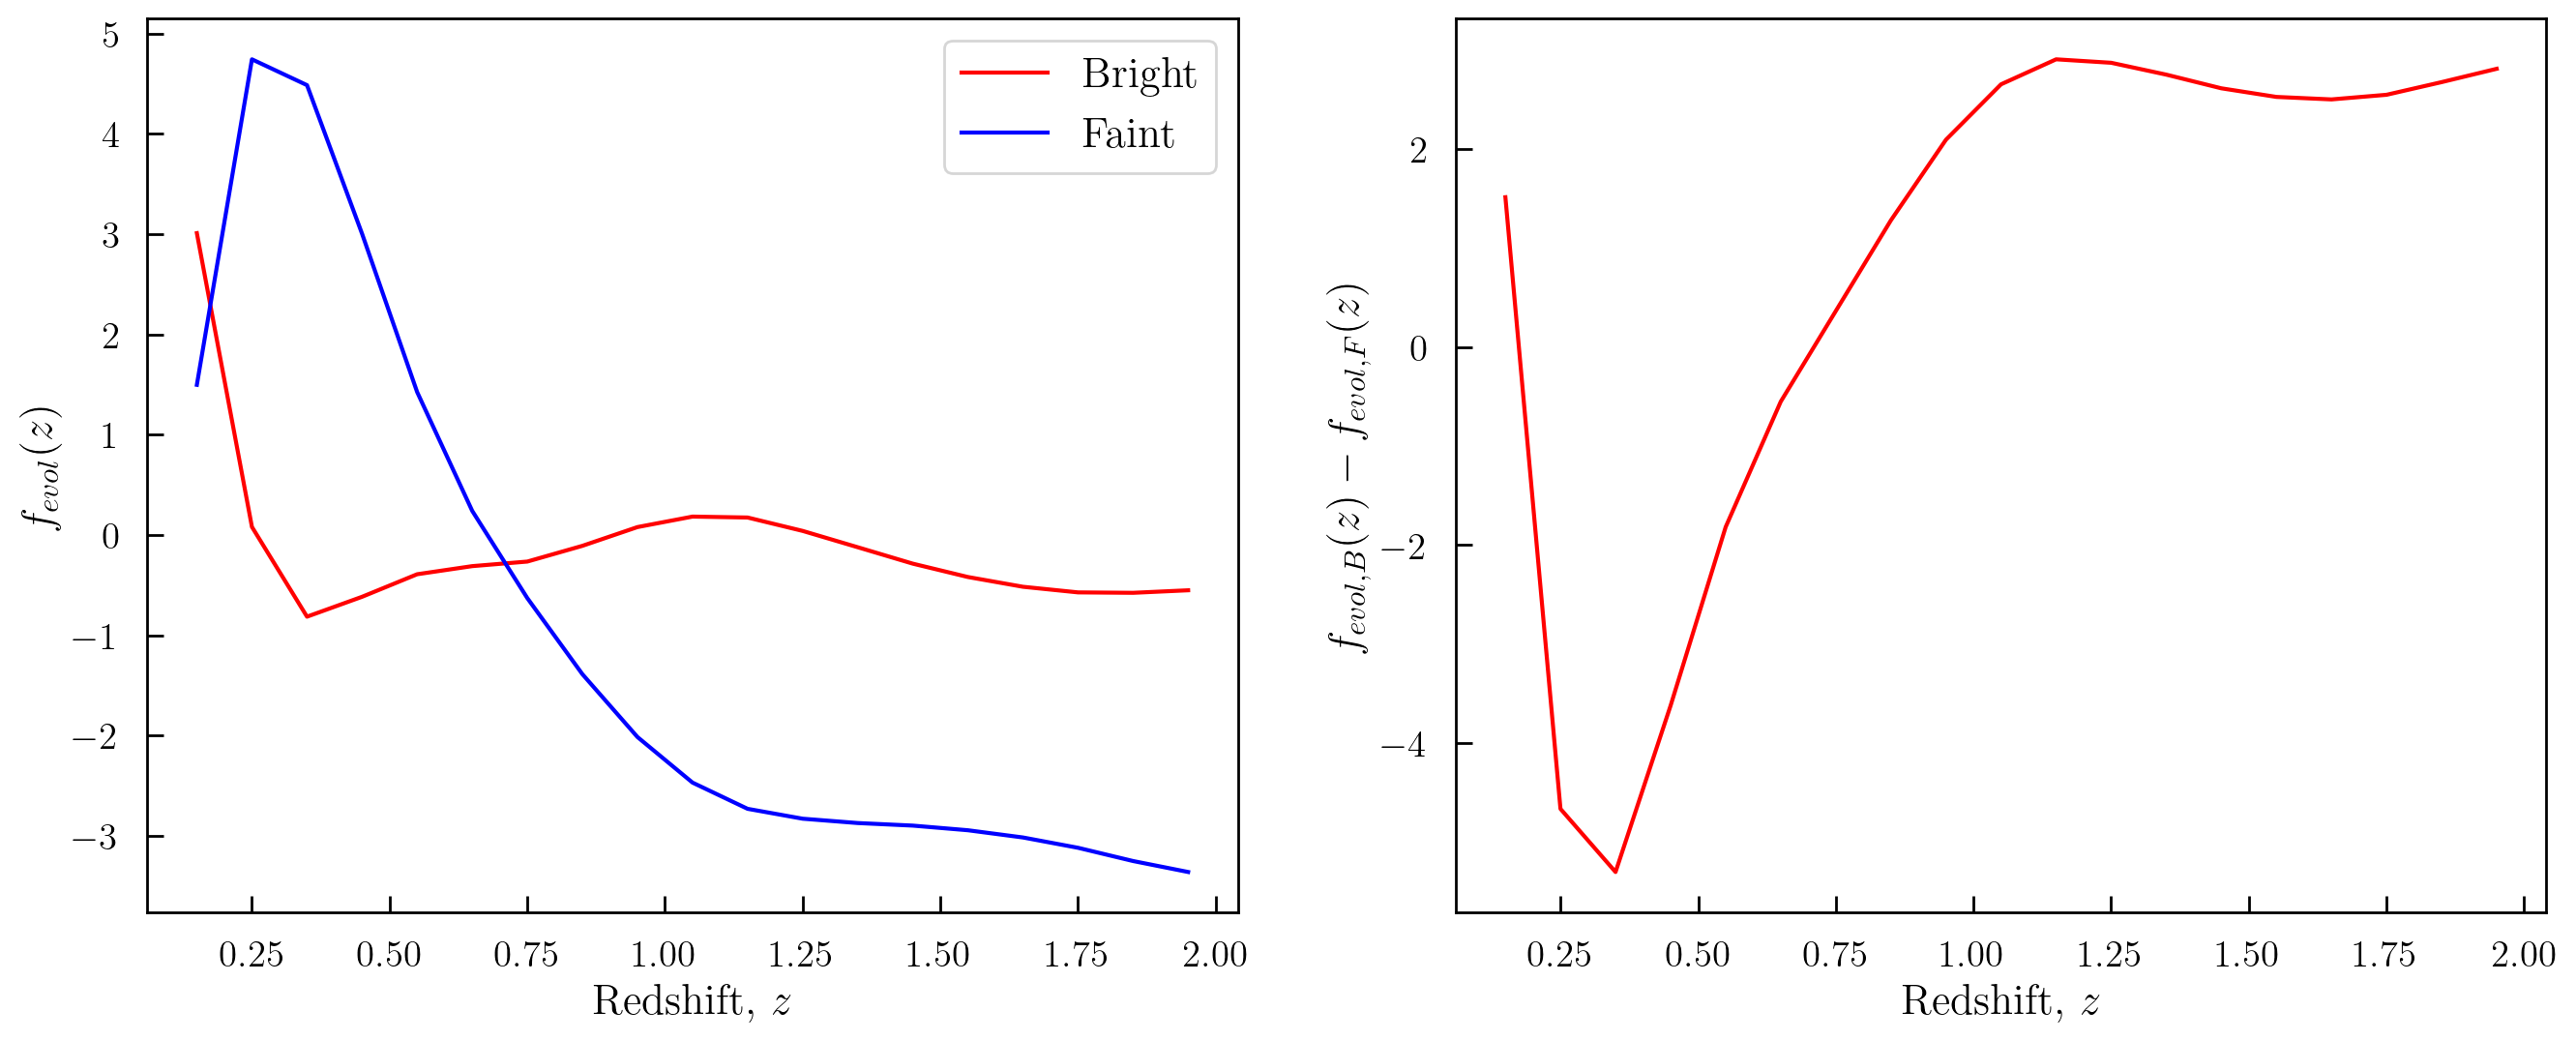

In [252]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fevolB, color = 'r', label = 'Bright')
ax[0].plot(zSKA, fevolF, color = 'b', label = 'Faint')
#ax[0].plot(z_data, smodelF(z_data), '.', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{evol}(z)$');
ax[0].legend();

ax[1].plot(zSKA, fevolB-fevolF, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

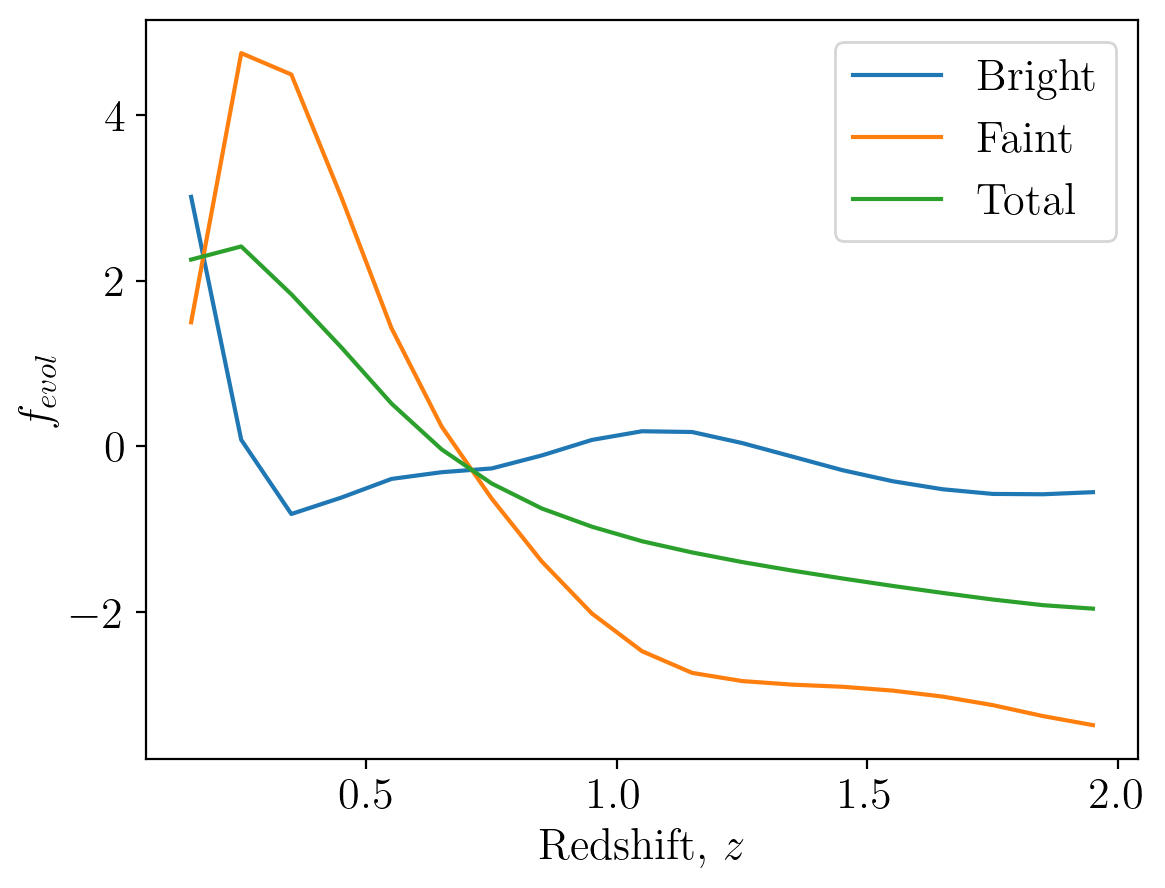

In [253]:
s = smodel(zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB  - 5/2*sB*dLogFcut
fevolF = - dLogNF - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar) 
fevol = - dLogN - dlogH + (2 - 5*s)*rHterm - 5*s - 5/2*s*dLogFstar

plt.plot(zSKA, fevolB, label='Bright')
plt.plot(zSKA, fevolF, label ='Faint')
plt.plot(zSKA, fevol, label='Total')
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$f_{evol}$')
plt.legend();

### Using the total derivative:

In [184]:
def dlogN_dz(z, Sc, eps=0.0001):
    res = (1+z)*(c2_int(Sc)/z - c3_int(Sc) 
                 + (stencil_derivative(c1_int, x=Sc, h=eps)*np.log(10) + stencil_derivative(c2_int, x=Sc, h=eps)*np.log(z) - stencil_derivative(c3_int, x=Sc, h=eps)*z)*stencil_derivative(Sc_z, x=z, h=eps))
    return res

Text(0, 0.5, '$b_e$')

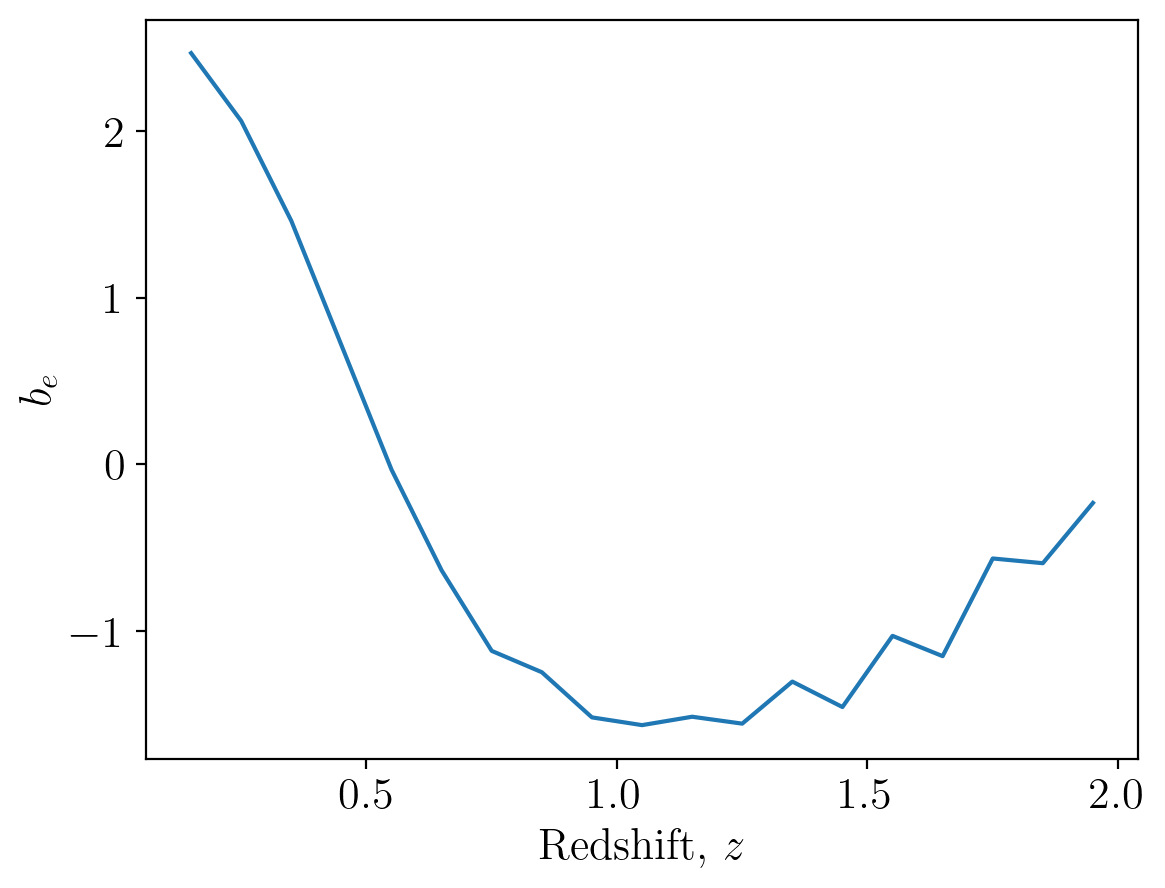

In [185]:
# Check be in R. Maartens et a.l. (2022)

rHterm_ = (1+zSKA)/(r(zSKA) * H(zSKA))

dlogH_ = (1+zSKA) * dlogH_f(zSKA)

Qterm_ = 2 * (1 + rHterm_) * 5/2 * smodel(zSKA)

dLogN = dlogN_dz(zSKA, Sc_z(zSKA), eps=0.0001)

fevol = - dLogN - dlogH_ + 2 * rHterm_ - Qterm_ 

plt.plot(zSKA, fevol)
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$b_e$')

In [186]:
def Sc_z(z, Ncut=10):
    return Srms_fitz(z) * Ncut/10

Sc_bright_z = interp.interp1d(z_data, Sc_bright)

Sc_z(z_data), Sc_bright_z(z_data)

(array([6.24, 5.85, 5.54, 5.28, 5.08, 4.92, 4.79, 4.68, 4.61, 4.55, 4.51,
        4.49, 4.48, 4.49, 4.5 , 4.53, 4.56, 4.61, 4.66, 4.72]),
 array([44.34521298, 16.79864799, 12.15285304, 10.18999187,  8.96069936,
         8.08395398,  7.42708616,  6.91496673,  6.53259425,  6.21969718,
         5.97750172,  5.79708304,  5.65786332,  5.56548838,  5.48941146,
         5.45020385,  5.42061396,  5.42248116,  5.43044833,  5.45526872]))

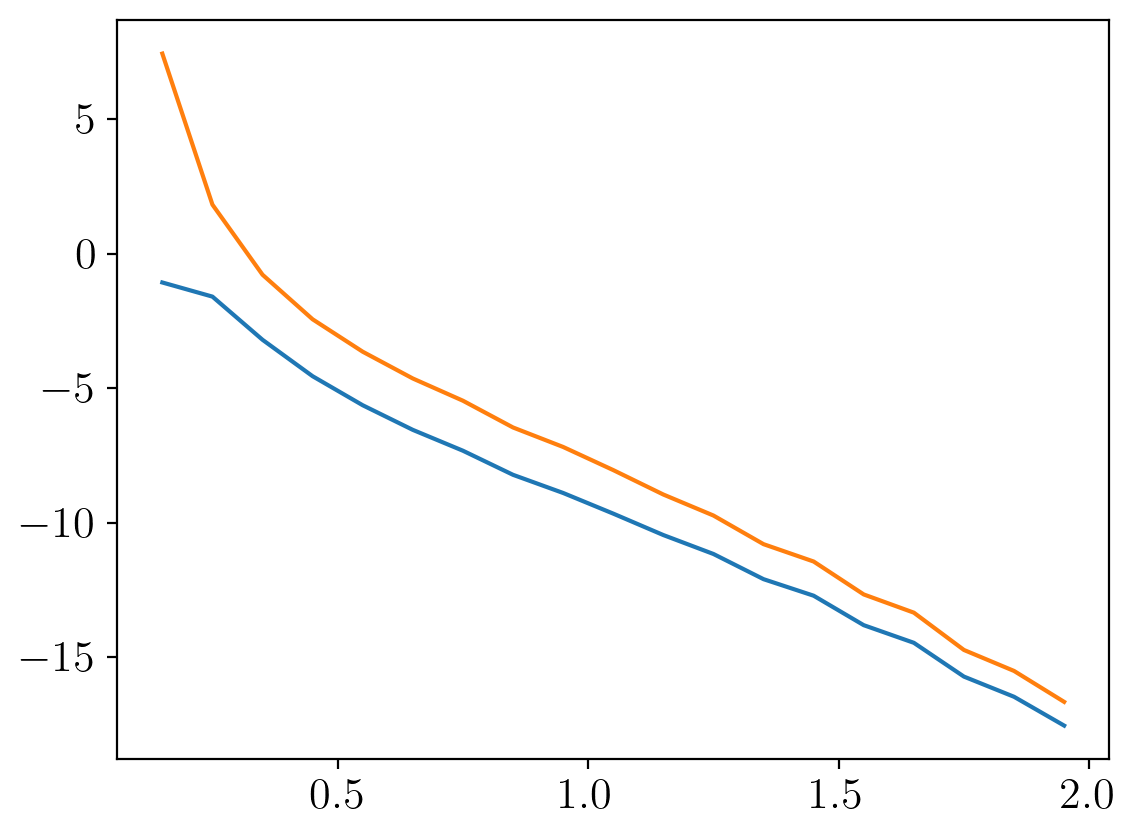

In [187]:
dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

dLogNB = dlogN_dz(z=zSKA, Sc=Sc_bright_z(zSKA))

dLogNF = dlogN_dz(z=zSKA, Sc=Sc_z(zSKA))

dLogN = dlogN_dz(z=zSKA, Sc=Sc_z(zSKA))

plt.plot(zSKA, dLogNB)
plt.plot(zSKA, dLogNF)

In [188]:
LogFcut = interp.interp1d(z_data, np.log(Sc_bright), kind='cubic', fill_value='extrapolate')
LogFstar = interp.interp1d(z_data, np.log(Sc_data), kind = 'cubic', fill_value='extrapolate')

dLogFcut = (1+zSKA) * stencil_derivative(LogFcut, zSKA)
dLogFstar = (1+zSKA) * stencil_derivative(LogFstar, zSKA)

In [189]:
# Evolution bias

sB = smodelB(zSKA)
sF = n_split*smodel(zSKA) - smodelB(zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB + 5/2*sB*dLogFcut
fevolF = - dLogNF - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar)

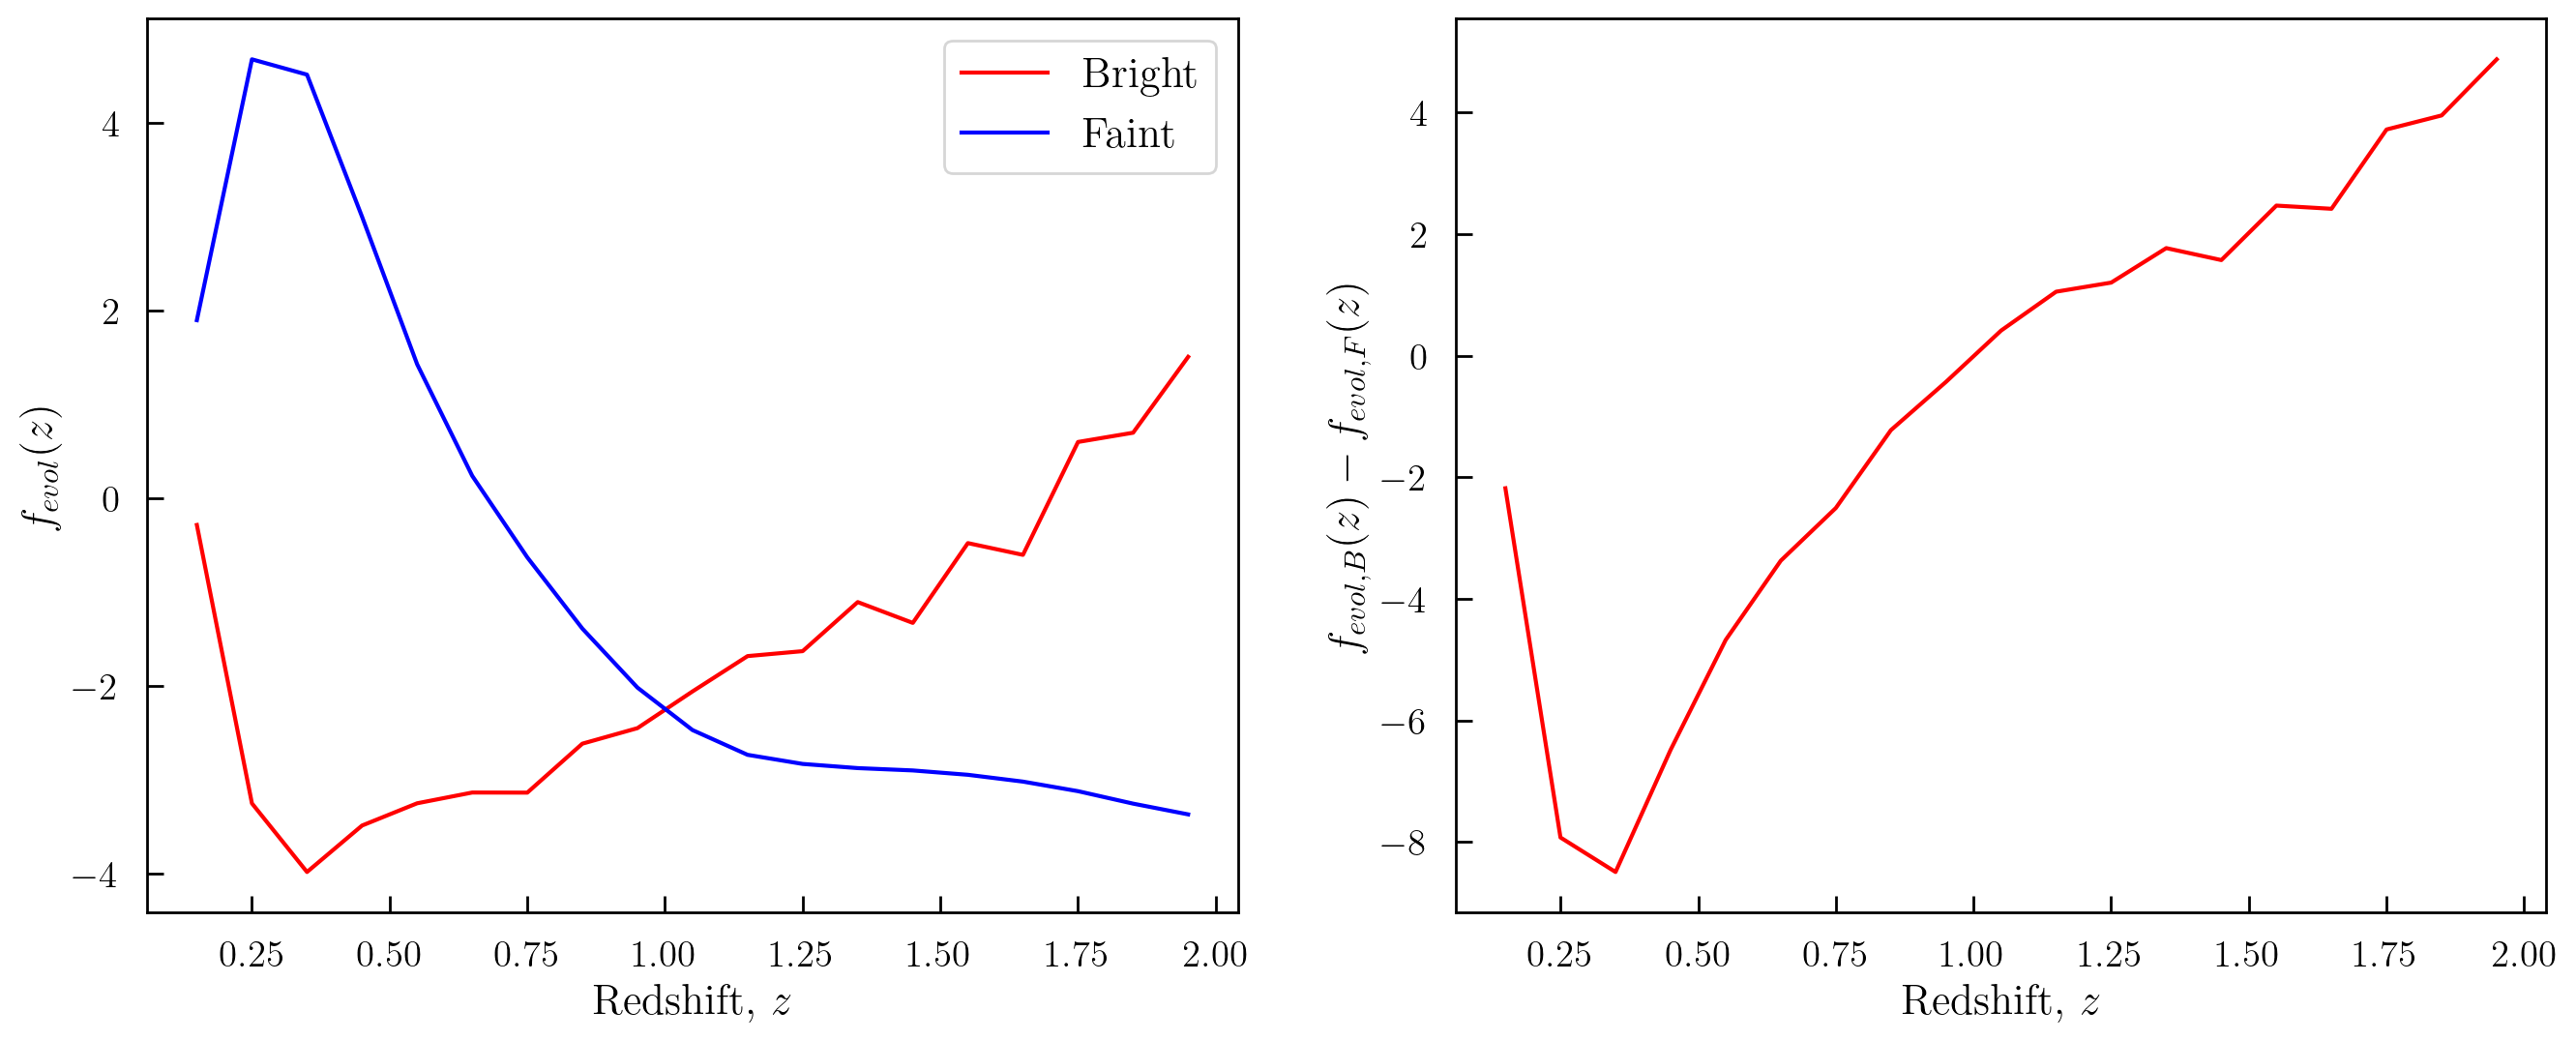

In [190]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fevolB, color = 'r', label = 'Bright')
ax[0].plot(zSKA, fevolF, color = 'b', label = 'Faint')
#ax[0].plot(z_data, smodelF(z_data), '.', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{evol}(z)$');
ax[0].legend();

ax[1].plot(zSKA, fevolB-fevolF, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

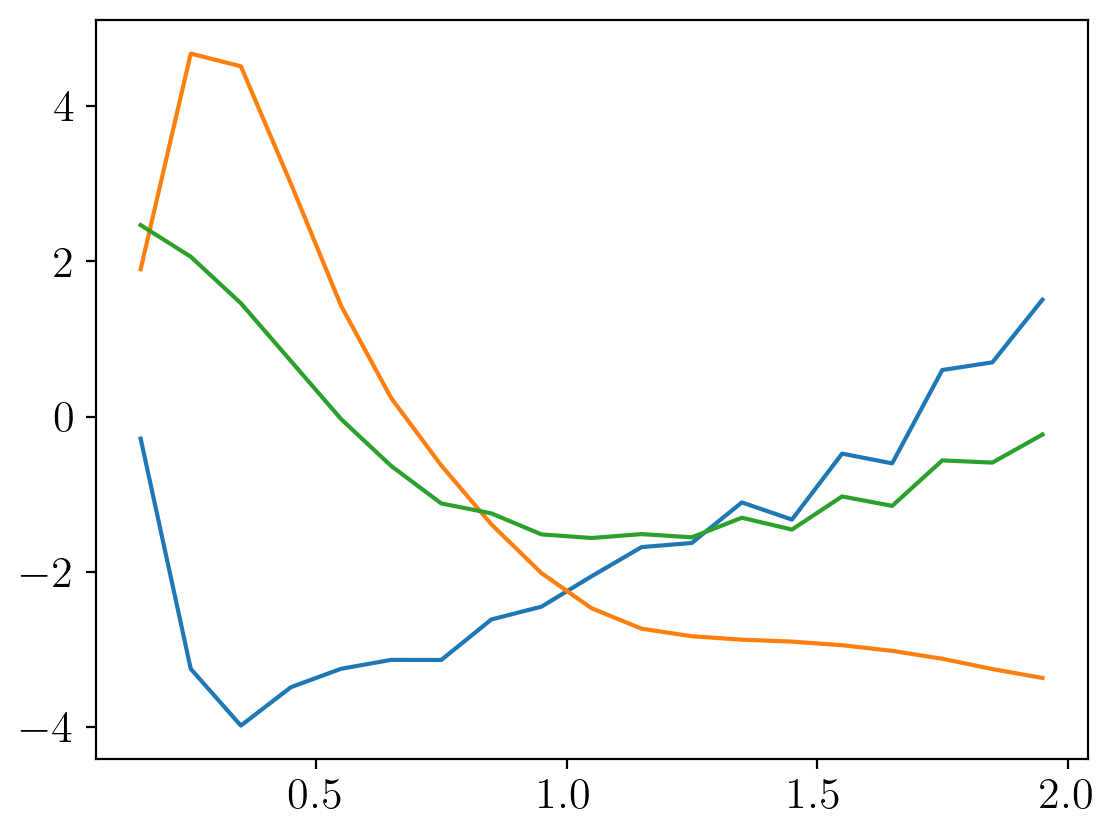

In [191]:
s = smodel(zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB  + 5/2*sB*dLogFcut
fevolF = - dLogNF - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar) 
fevol = - dLogN - dlogH + (2 - 5*s)*rHterm - 5*s 

plt.plot(zSKA, fevolB)
plt.plot(zSKA, fevolF)
plt.plot(zSKA, fevol)

In [192]:
# Survey bins

zSKA = np.array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95])

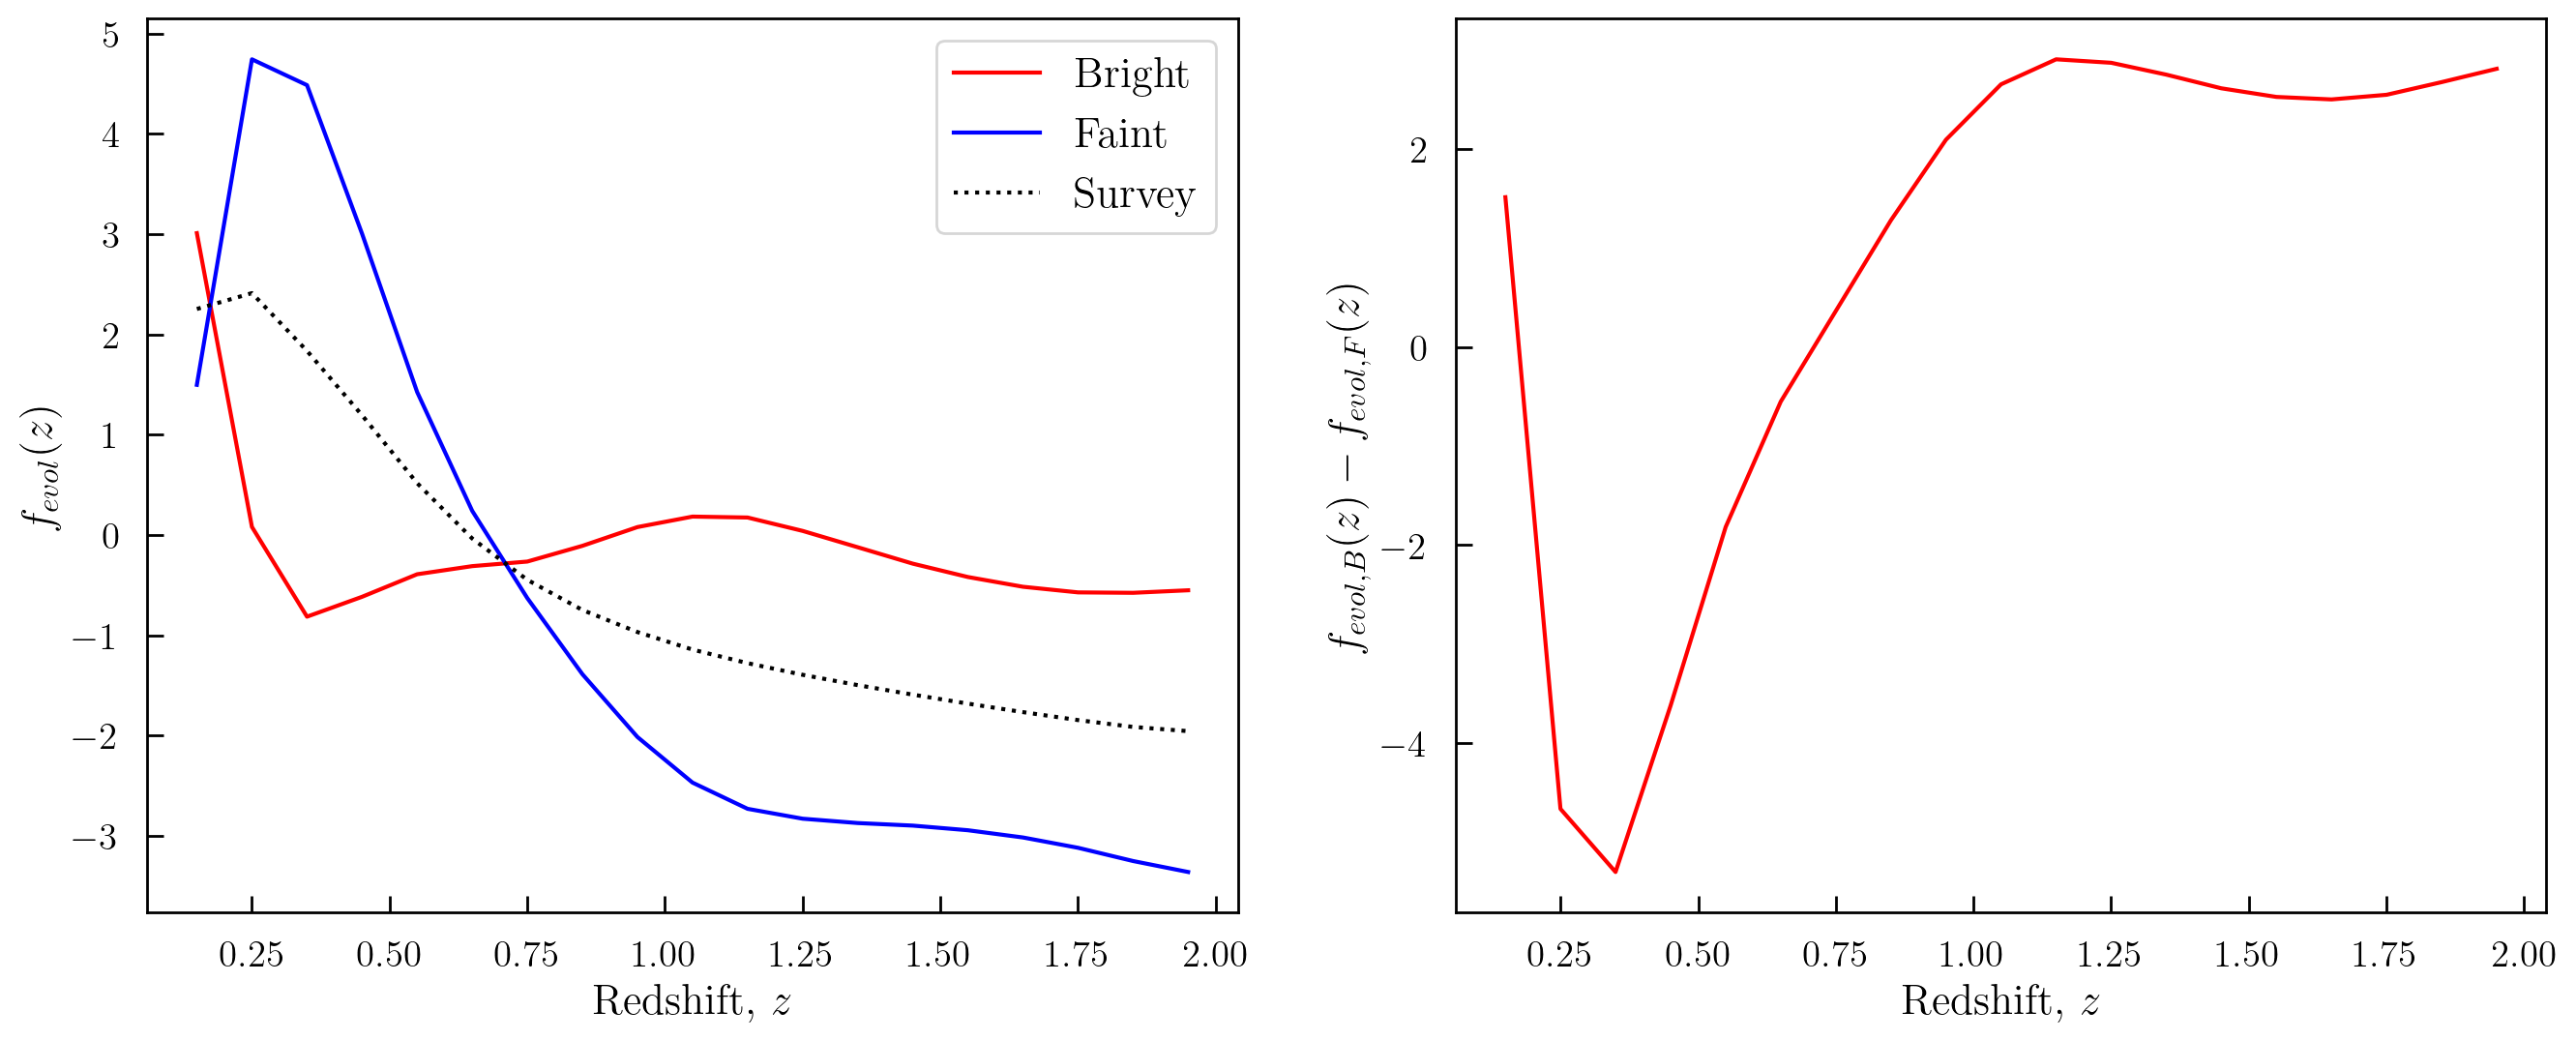

In [193]:
# Evolution bias

sB = smodelB(zSKA)
s = smodel(zSKA)
sF = n_split*smodel(zSKA) - smodelB(zSKA)

dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

dLogNB = (1+zSKA) * stencil_derivative(LogNB_z, zSKA)
dLogNF = (1+zSKA) * stencil_derivative(LogNF_z, zSKA)
dLogN = (1+zSKA) * stencil_derivative(LogN_z, zSKA)

dLogFcut = (1+zSKA) * stencil_derivative(LogFcut, zSKA)
dLogFstar = (1+zSKA) * stencil_derivative(LogFstar, zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB - 5/2*sB*dLogFcut
fevolF = - dLogN - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar)
fevol = - dLogN - dlogH + (2 - 5*s)*rHterm - 5*s - 5/2*(s*dLogFstar)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fevolB, color = 'r', label = 'Bright')
ax[0].plot(zSKA, fevolF, color = 'b', label = 'Faint')
ax[0].plot(zSKA, fevol, ':', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{evol}(z)$');
ax[0].legend();

ax[1].plot(zSKA, fevolB-fevolF, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

# Using constant $F_* = 5.$

## Magnification bias

We try to apply the same approach as in the biasfuncs.py script. 

For the magnification bias, we take $\log{N_{g}}$ and numerically solve for the flux cuts of the bright population so that we have the same amount of bright and faint galaxies per redshift bin. We take the information of the full SKA Phase 2 survey in this case. 

Now, the $s_{\mathrm{model}}$ is not taken from the fitting function in [S. Camera et a.l. (2016)](https://arxiv.org/abs/1409.8286), but the numerical derivative of $\log{N_{g}}$. 

$$s_{\mathrm{model}} = - \frac{2}{5} \frac{\partial\log{N_{\mathrm{g}}(z, S_{\mathrm{c}})}}{\partial\log{S_{\mathrm{c}}}} = \frac{2}{5}\,\mathcal{Q}$$

In [194]:
# Define the functions

def stencil_derivative(fun, x, h=0.001):
    if type(x) == list:
        x=np.array(x)    
    d = (-fun(x+2*h) + 8*fun(x+h) - 8*fun(x-h) + fun(x-2*h))/(12*h)
    return d

def LogN_g(z, Sc):
    #return np.log(10**c1_int(Sc) * z**c2_int(Sc) * np.exp(-c3_int(Sc)*z))
    return np.log(N_g(z,Sc))

def sc_equation(x, z, Sc, n_split=2):
    return np.log(n_split) + LogN_g(z, x) - LogN_g(z, Sc)

def sc_solver(z, Sc, n_split, guess):
        sol = opt.fsolve(sc_equation, guess, args=(z,Sc,n_split))
        return sol


In [195]:
# Calculate the flux cuts for the bright population

Sc_data = np.array([5.] * len(z_data))

n_split = 2.

guess = np.array([1.]*len(z_data))

Sc_bright = sc_solver(z=z_data, Sc=Sc_data, n_split=n_split, guess=guess)

print(Sc_bright)

[41.83835016 15.70635984 11.56282931  9.86939176  8.86353797  8.18463913
  7.69553358  7.32702727  7.0394408   6.8080472   6.61801099  6.45974109
  6.32648749  6.21325412  6.11623103  6.03245853  5.95960929  5.8958419
  5.8396718   5.78989002]


In [196]:
print(Sc_data)

[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


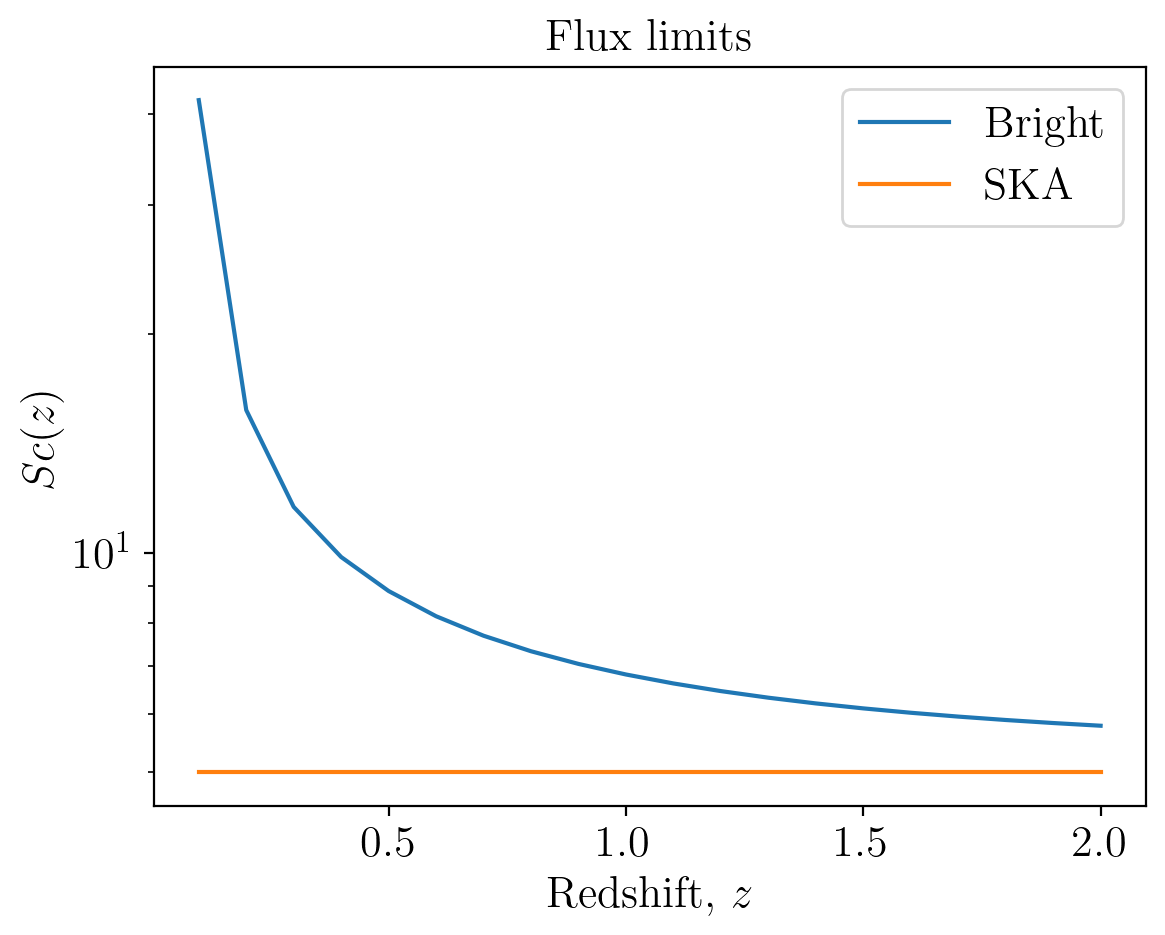

In [197]:
plt.plot(z_data, Sc_bright, label='Bright')
plt.plot(z_data, Sc_data, label='SKA')

plt.title(r'Flux limits')
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$Sc(z)$')
plt.yscale('log')
plt.legend()

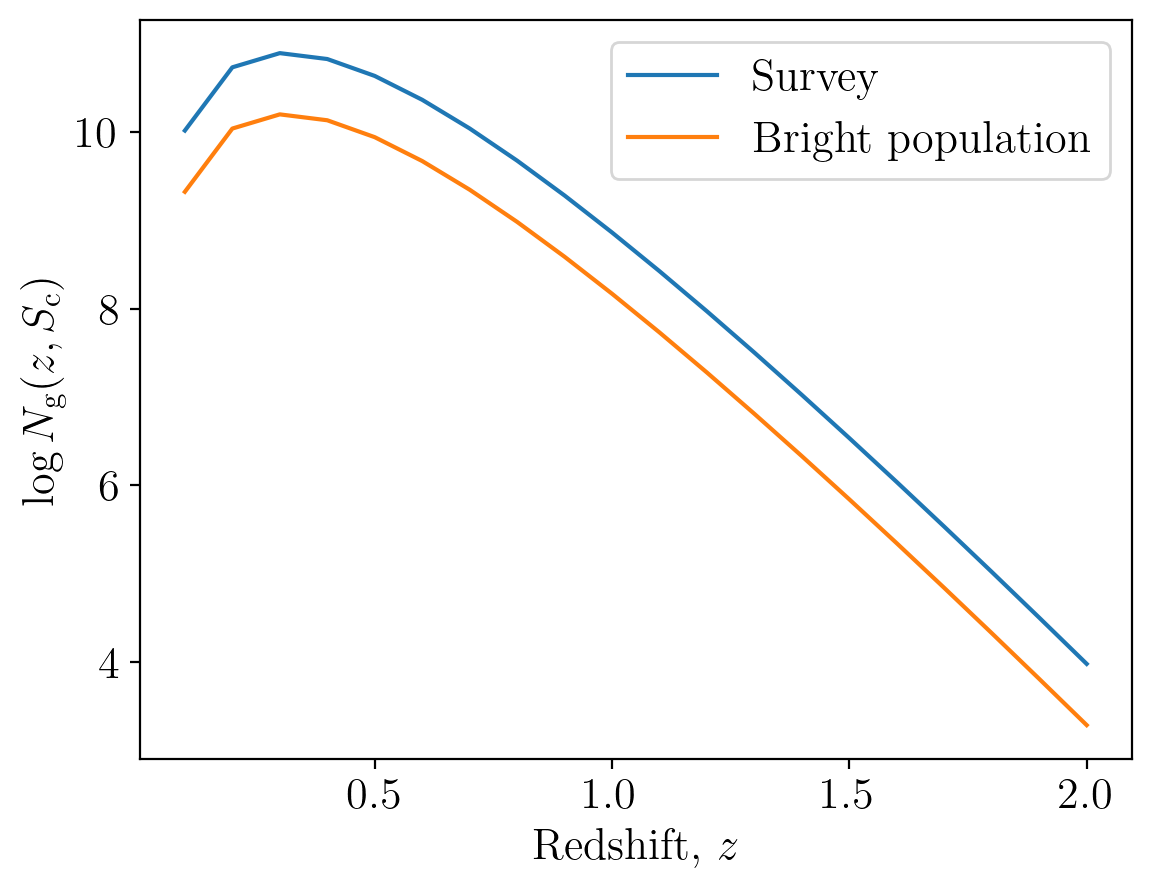

In [198]:
plt.plot(z_data, LogN_g(z_data, Sc_data), label='Survey')
plt.plot(z_data, LogN_g(z_data, Sc_bright), label='Bright population')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$\log{N_{\mathrm{g}}(z, S_{\mathrm{c}})}$')
plt.legend();

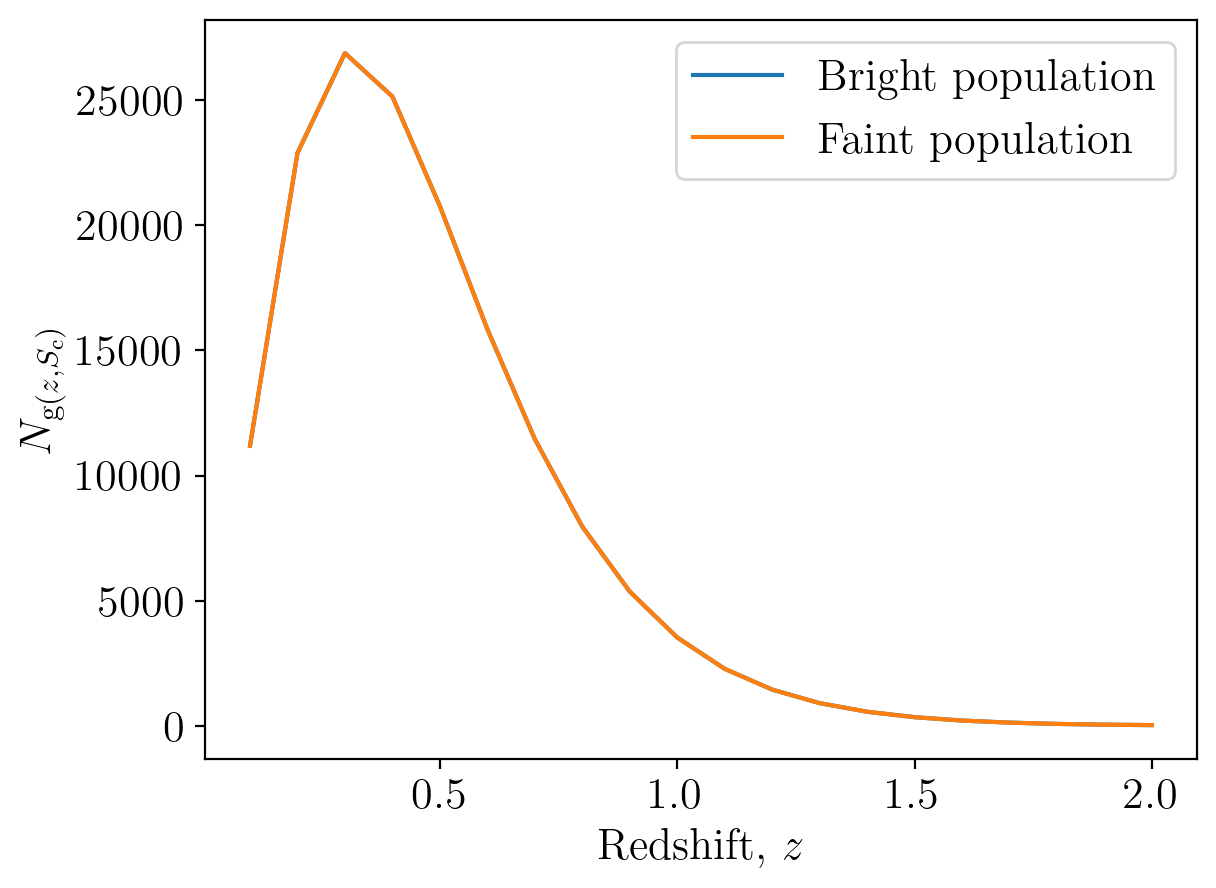

In [199]:
#plt.plot(z_data, np.exp(LogN_g(z_data, Sc_data)), label='Survey')
plt.plot(z_data, N_g(z_data, Sc_bright), label='Bright population')
plt.plot(z_data, N_g(z_data, Sc_data) - N_g(z_data, Sc_bright), label='Faint population')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}(z, S_{\mathrm{c}})}$')
plt.legend();

Using the fittin formula for $N_{\mathrm{g}}(z, S_{\mathrm{c}})$ of [S. Yahya et a.l. (2015)](https://arxiv.org/abs/1412.4700), it is convenient to find te logarithm of it:

$$ \log{N_{\mathrm{g}}(z, S_{\mathrm{c}})} = c_1(S_{\mathrm{c}})\,\log{10} + c_2(S_{\mathrm{c}})\,\log{z} + c_3(S_{\mathrm{c}})\,z$$

In [200]:
# Derivative of Qmodel as Log N_g with respect to log Sc

def Qmodel(z, Sc):
    res = - Sc * ( stencil_derivative(c1_int, x=Sc)*np.log(10) + stencil_derivative(c2_int, x=Sc)*np.log(z) - stencil_derivative(c3_int, x=Sc)*z )
    return res

# Magnification bias

def s_model(z, Sc):
    return 2/5 * Qmodel(z, Sc)

In [201]:
z_data, zSKA

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15,
        1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95]))

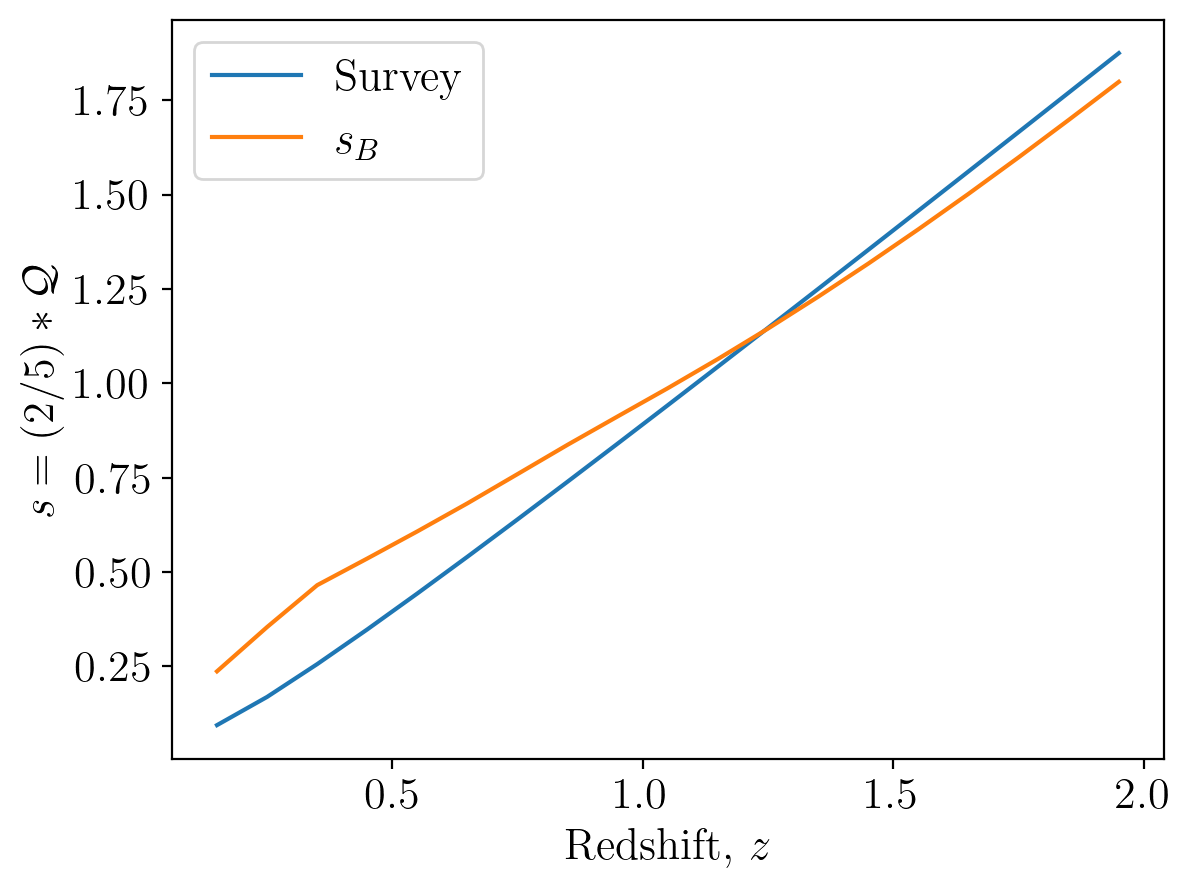

In [202]:
smodel_data = s_model(z_data, Sc_data)
smodelB_data = s_model(z_data, Sc_bright)

smodel = interp.interp1d(z_data, smodel_data, kind='cubic', fill_value='extrapolate')
smodelB = interp.interp1d(z_data, smodelB_data, kind='cubic', fill_value='extrapolate')

plt.plot(zSKA, smodel(zSKA), label='Survey')
plt.plot(zSKA, smodelB(zSKA), label='$s_B$')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$s = (2/5) * \mathcal{Q}$')
plt.legend();

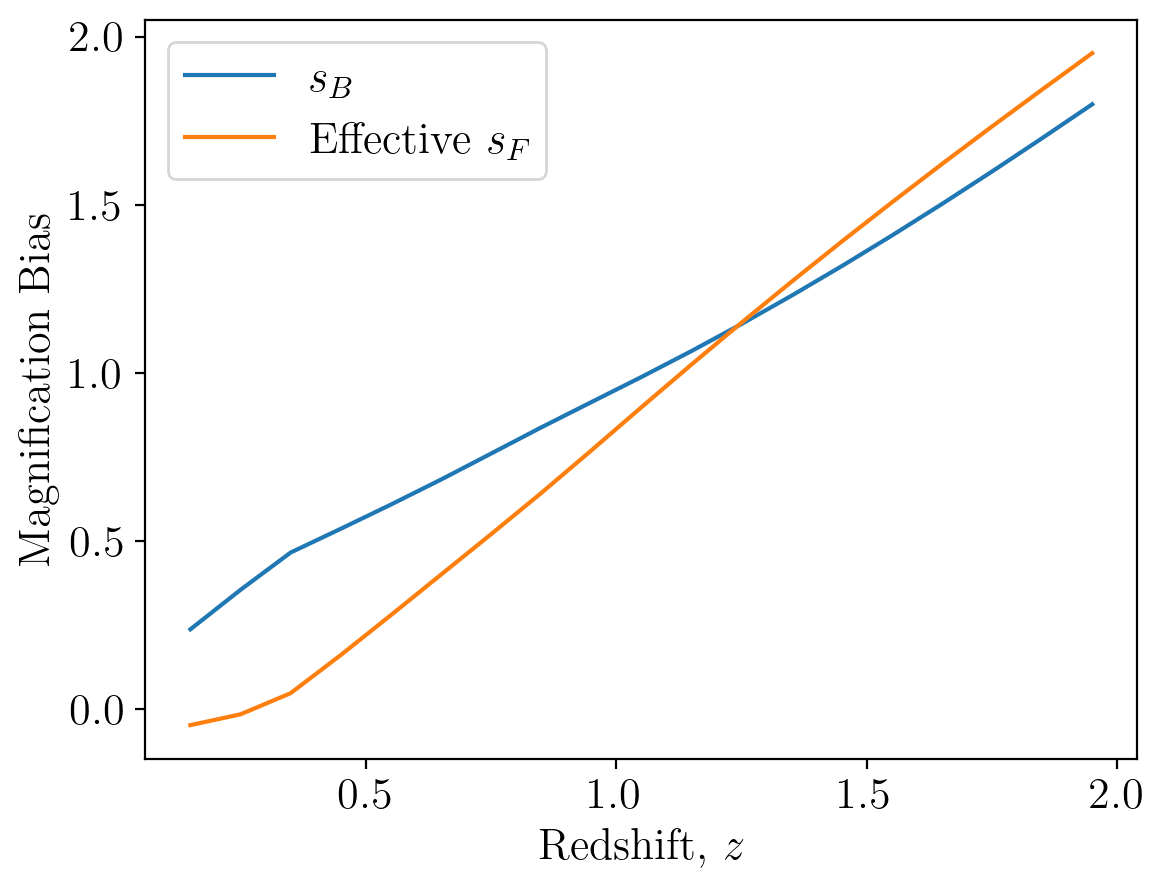

In [203]:
sBright = smodelB(z_data)
sFaint = n_split * smodel(z_data) - smodelB(z_data)

#plt.plot(z_data, sBright, 'r.',label='$s_B$, SKA2')
#plt.plot(z_data, sFaint, 'k.',label='$s_F$ SKA2')

plt.plot(zSKA, smodelB(zSKA), label='$s_B$')
plt.plot(zSKA, n_split*smodel(zSKA) - smodelB(zSKA), label='Effective $s_F$')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'Magnification Bias')
plt.legend();

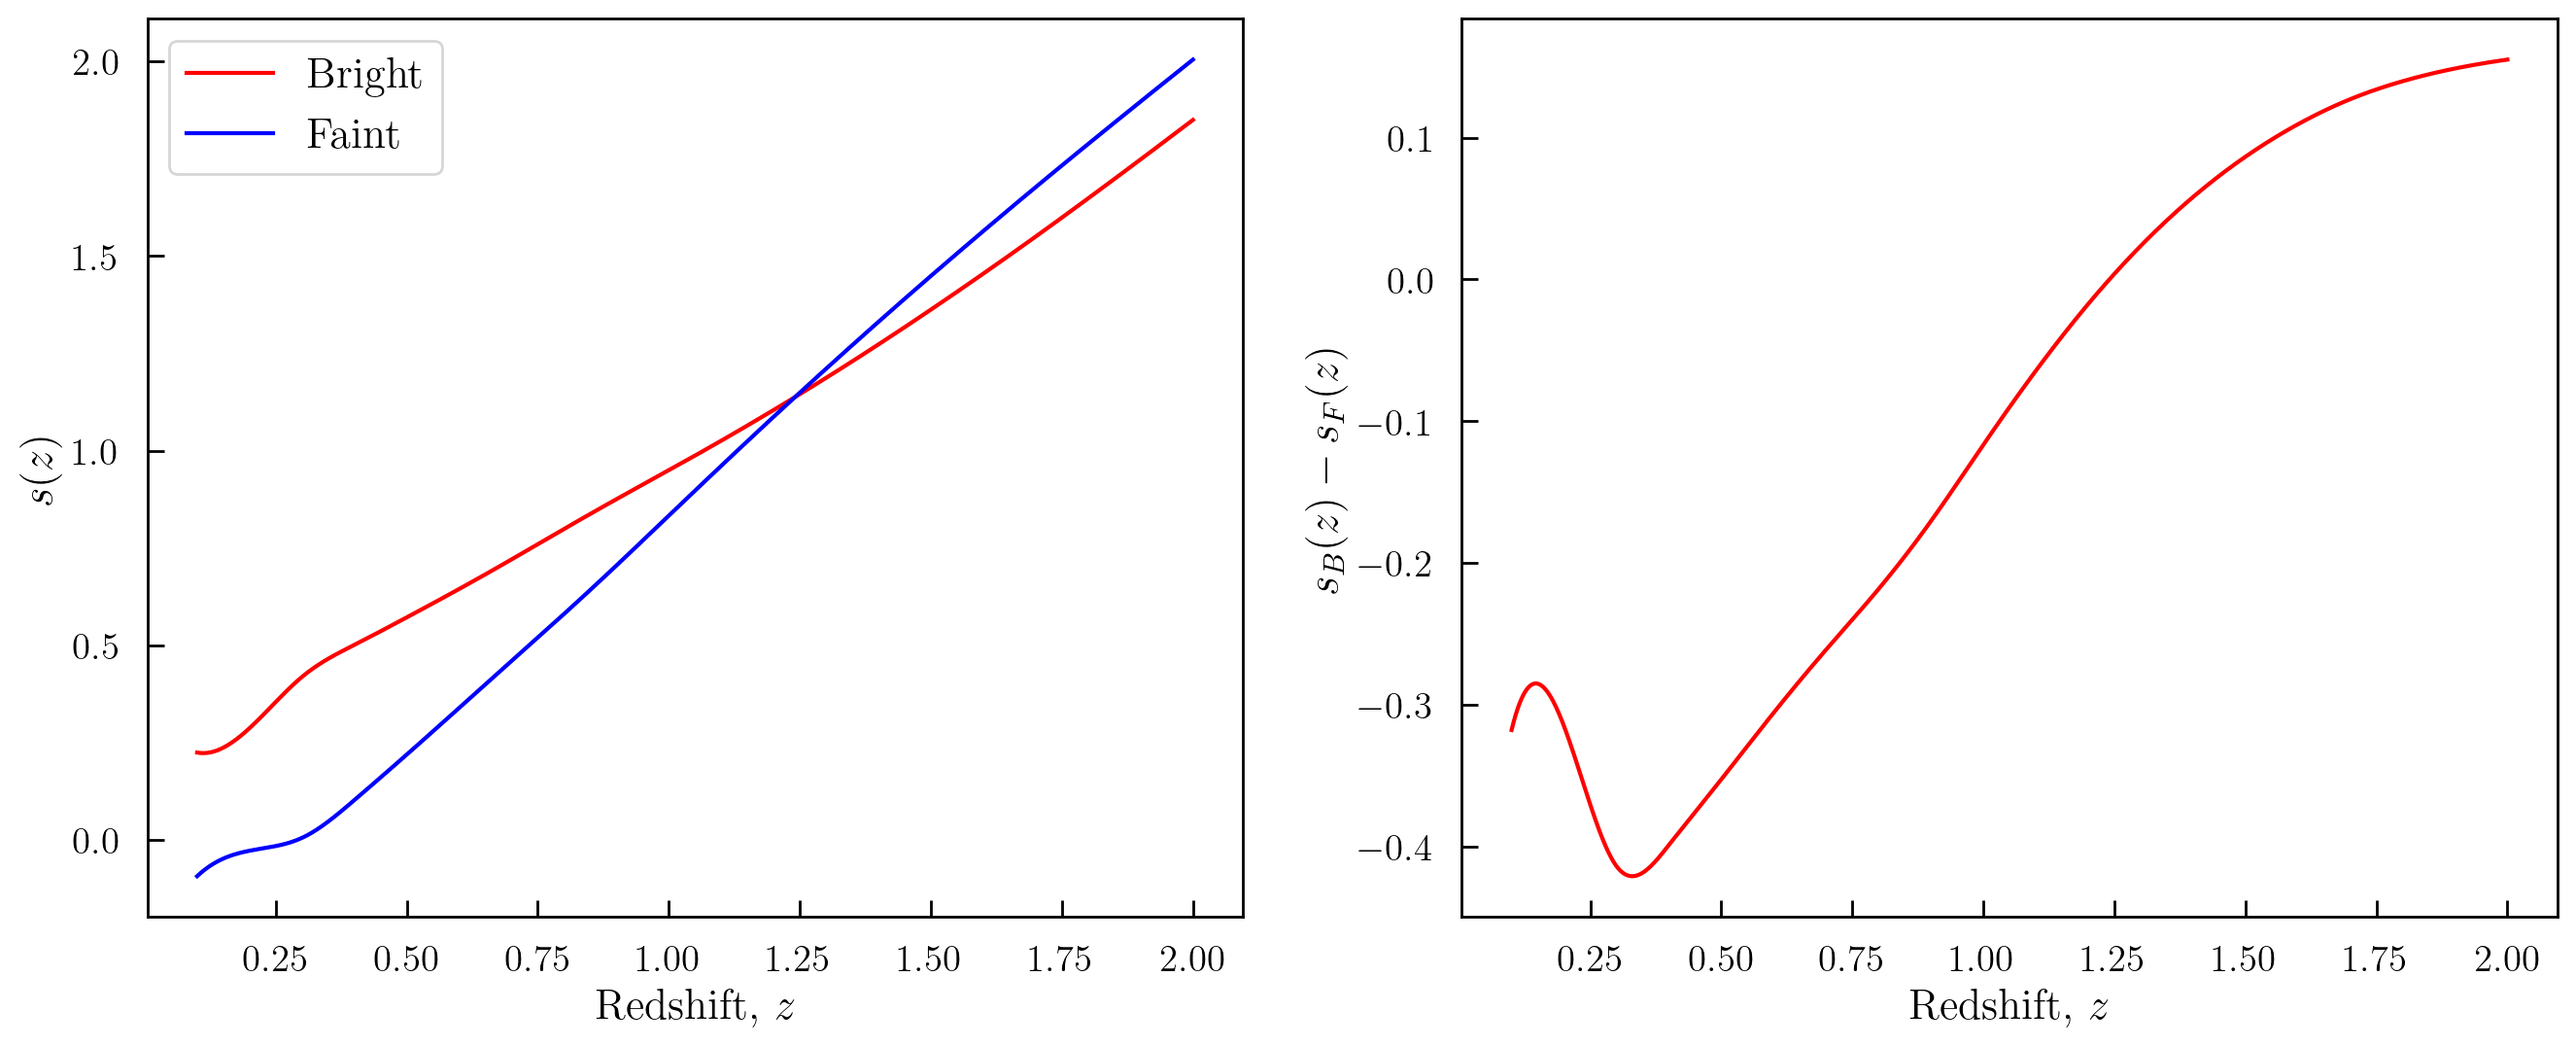

In [204]:
zs = np.linspace(0.1, 2.0, 1000)

sB = smodelB(zs)
sF = n_split * smodel(zs) - smodelB(zs)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zs, sB, color = 'r', label = 'Bright')
ax[0].plot(zs, sF, color = 'b', label = 'Faint')
#ax[0].plot(z_data, smodelF(z_data), '.', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$s(z)$');
ax[0].legend();

ax[1].plot(zs, sF-sB, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$s_{B}(z)-s_{F}(z)$');
ax[1].set_ylim();

## Evolution bias

We want to calculate the evolution bias for the two populations of galaxies. We follow [R. Maartens et a.l. (2022)](https://arxiv.org/abs/2107.13401), where

$$f_\mathrm{model} = -\frac{d\log{N_{\mathrm{g}}}(z, S_{\mathrm{c}})}{d\log{(1+z)}} - \frac{d\log{H}}{d\log{(1+z)}} + 2\,\frac{(1+z)}{r\,H} - \left[2\,\left(1+\frac{1+z}{r\,H}\right) + \frac{d\log{Sc}}{d\log{1+z}}\right]\,\mathcal{Q}$$

Where after splitting the populations, we should use $N_\mathrm{g}$ and $\mathcal{Q}$ of each population. 

In [205]:
zSKA, z_data

(array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15,
        1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]))

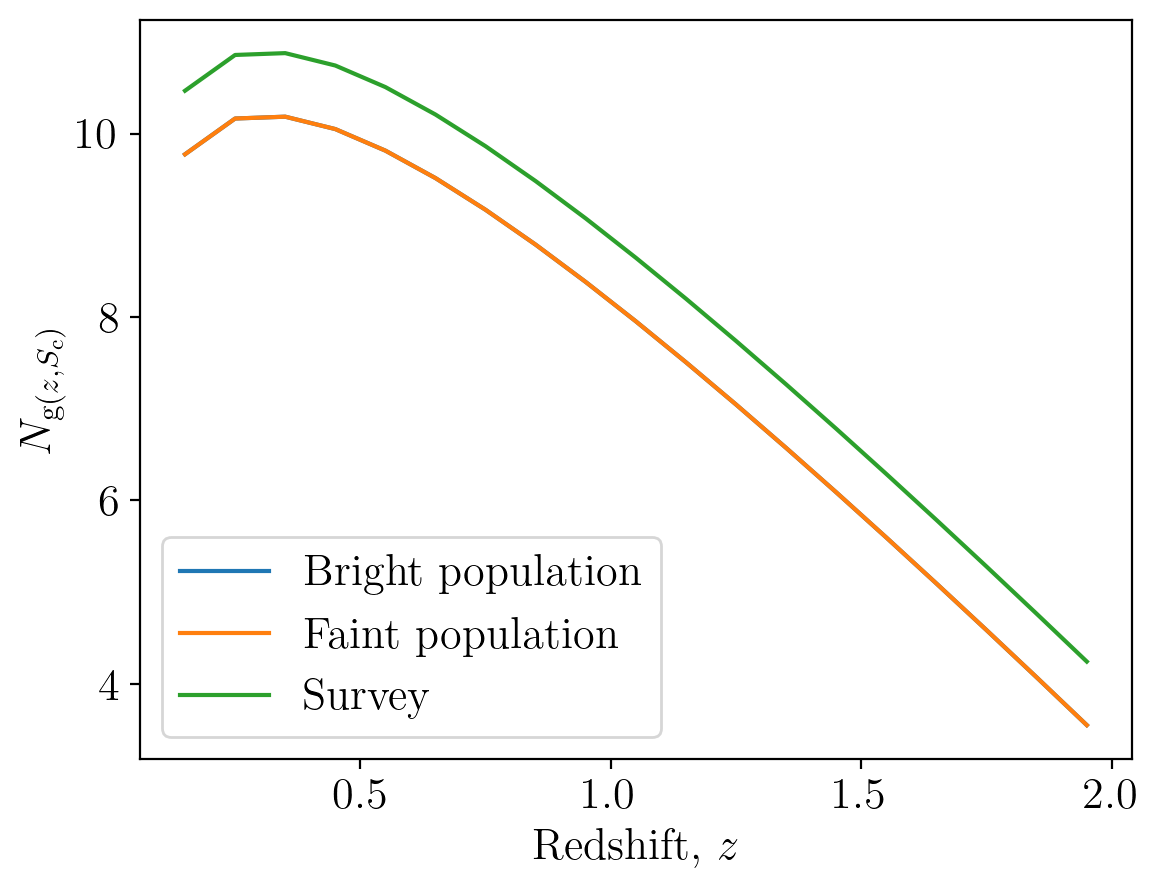

In [206]:
LogN_z = interp.interp1d(z_data, np.log(N_g(z_data, Sc_data)), kind='cubic', fill_value='extrapolate')
LogNB_z = interp.interp1d(z_data, np.log(N_g(z_data, Sc_bright)), kind='cubic', fill_value='extrapolate')
LogNF_z = interp.interp1d(z_data, np.log(N_g(z_data, Sc_data) - N_g(z_data, Sc_bright)), kind='cubic', fill_value='extrapolate')

#plt.plot(z_data, np.exp(LogN_g(z_data, Sc_data)), label='Survey')
plt.plot(zSKA, LogNB_z(zSKA), label='Bright population')
plt.plot(zSKA, LogNF_z(zSKA), label='Faint population')
plt.plot(zSKA, LogN_z(zSKA), label = 'Survey')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$N_{\mathrm{g}(z, S_{\mathrm{c}})}$')
plt.legend();

In [207]:
# Define the contributions which do not depend on the population

from scipy.integrate import quad

def r_(z, Om = 0.3111, h=0.677):
    if type(z) == list:
        z=np.array(z)
    c = 299792.458
    H0 = 100*h/c # Mpc^{-1} units
    Oml = 1-Om
    # Comoving distance
    result = quad(lambda x: 1/(H0*np.sqrt(Om * (1+x)**3 + Oml)), 0, z)
    value=result[0]
    return np.array(value)

r=np.vectorize(r_)

def H(z, Om = 0.3111, h=0.677):
    if type(z) == list:
        z=np.array(z)
    c = 299792.458
    H0 = 100*h/c
    H = H0 * np.sqrt(Om*(1+np.array(z))**3 + (1-Om))
    return H
    
def dlogH_f(z, Om=0.3111, h=0.677):
    z = np.array(z)
    c = 299792.458
    H0 = 100*h/c
    derivative = H0**2/2 * (3*Om*(1+z)**2) / (H(z)**2)
    return derivative

def stencil_derivative(fun, x, h=0.001):
    if type(x) == list:
        x=np.array(x)    
    d = (-fun(x+2*h) + 8*fun(x+h) - 8*fun(x-h) + fun(x-2*h))/(12*h)
    return d

In [208]:
def Sc_z(z, Ncut=10):
    return Srms_fitz(z) * Ncut/10

def dlogN_dz(z, Sc, eps=0.0001):
    res = (1+z)*(c2_int(Sc)/z - c3_int(Sc) 
                 + (stencil_derivative(c1_int, x=Sc, h=eps)*np.log(10) + stencil_derivative(c2_int, x=Sc, h=eps)*np.log(z) - stencil_derivative(c3_int, x=Sc, h=eps)*z)*stencil_derivative(Sc_z, x=z, h=eps))
    return res

Text(0, 0.5, '$b_e$')

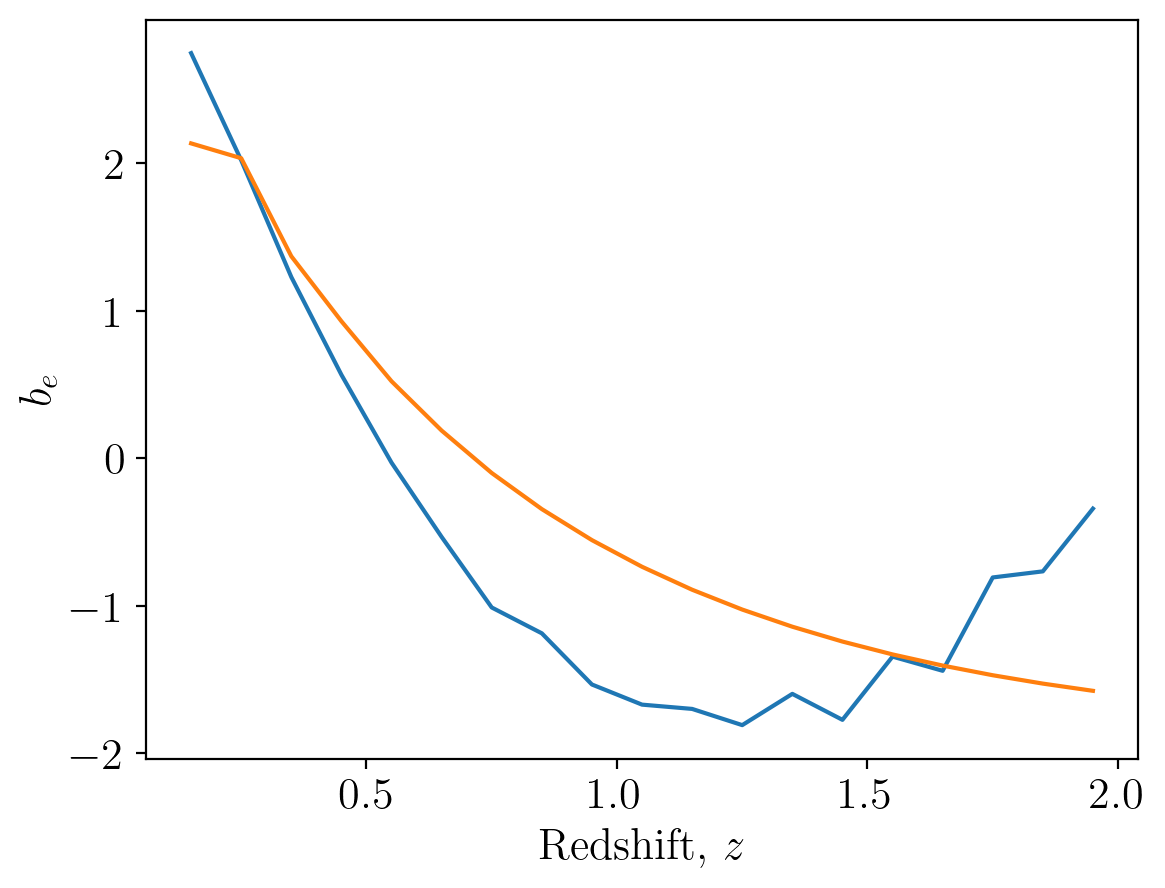

In [209]:
# Check be in R. Maartens et a.l. (2022)

rHterm_ = (1+zSKA)/(r(zSKA) * H(zSKA))

dlogH_ = (1+zSKA) * dlogH_f(zSKA)

Qterm_ = 2 * (1 + rHterm_) * 5/2 * smodel(zSKA)

dLogN = dlogN_dz(zSKA, Sc_z(zSKA), eps=0.0001)

dLogNb = (1+zSKA) * stencil_derivative(fun=LogN_z, x=zSKA, h=0.0001)

fevol = - dLogN - dlogH_ + 2 * rHterm_ - Qterm_
fevolb = - dLogNb - dlogH_ + 2 * rHterm_ - Qterm_

plt.plot(zSKA, fevol)
plt.plot(zSKA, fevolb)
plt.xlabel(r'Redshift, $z$')
#plt.xscale('log')
plt.ylabel(r'$b_e$')

Text(0, 0.5, '$b_e$ error')

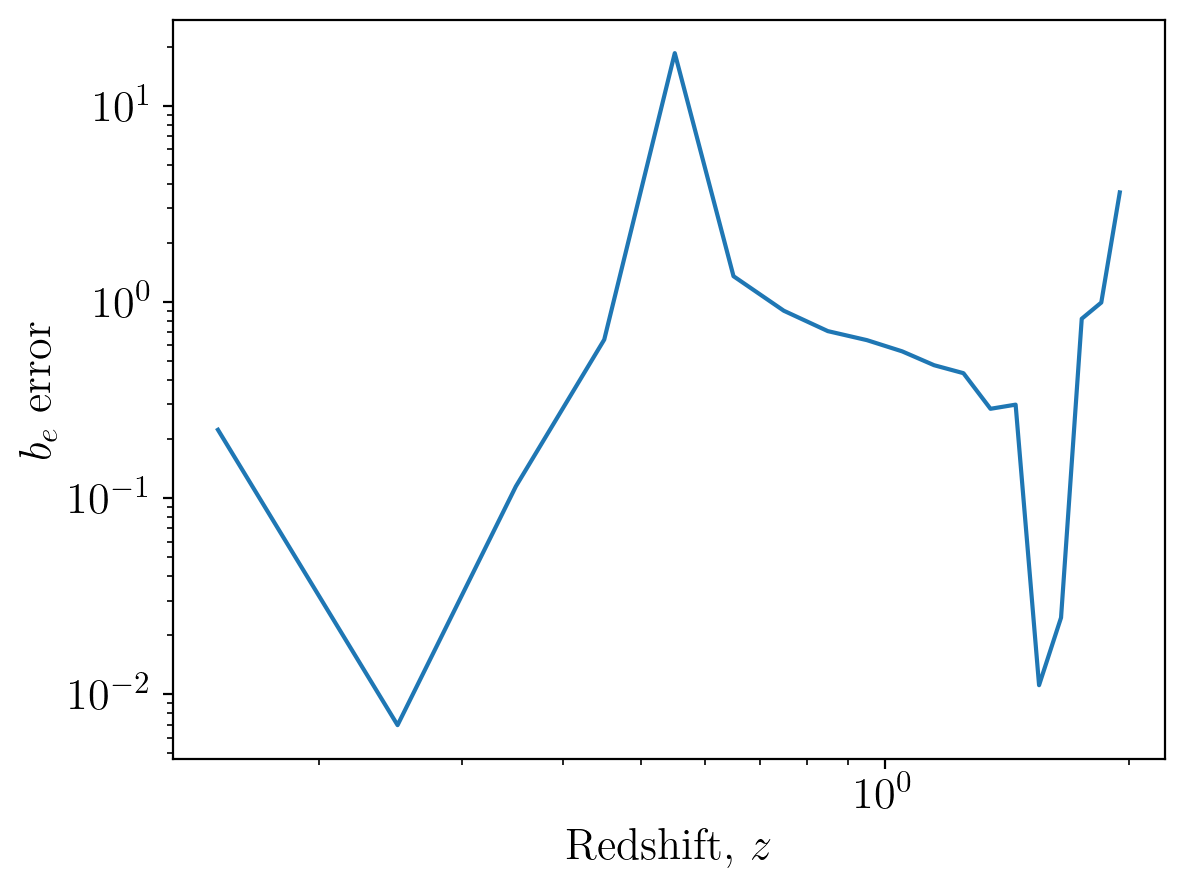

In [210]:
plt.plot(zSKA, np.abs(1-fevolb/fevol))
plt.xlabel(r'Redshift, $z$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$b_e$ error')

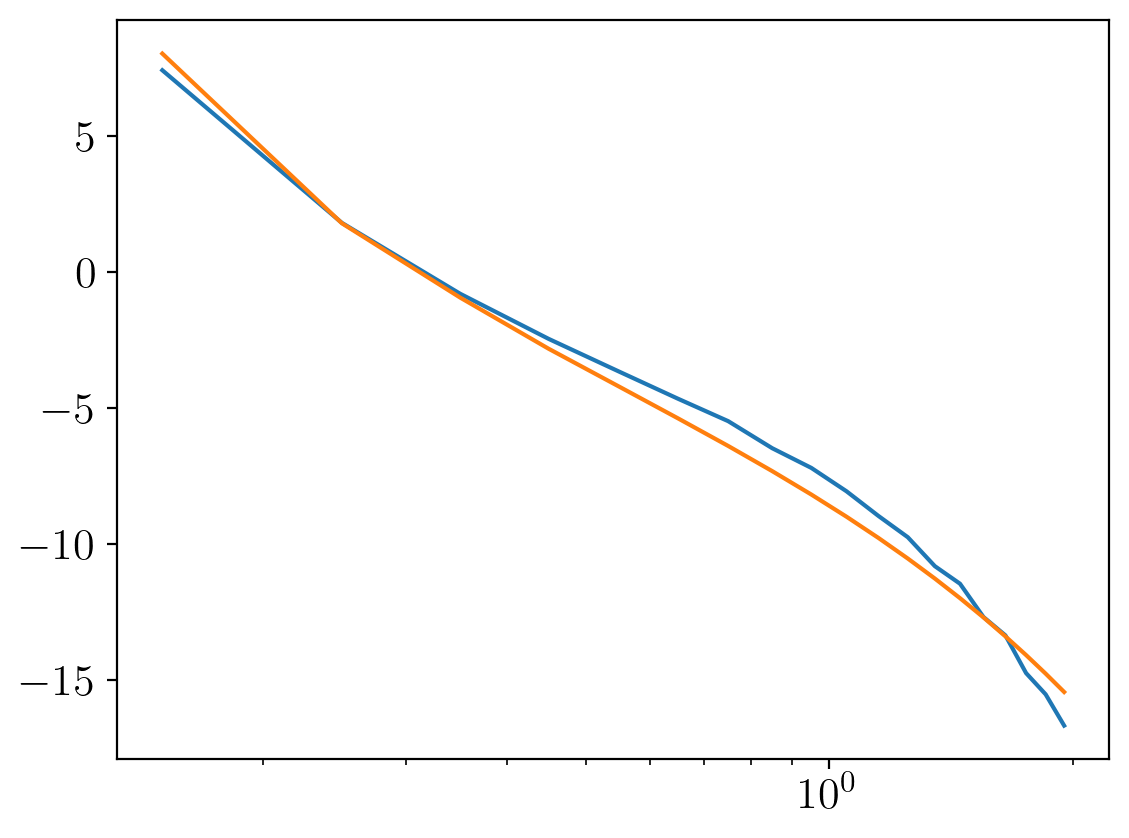

In [211]:
plt.plot(zSKA, dLogN)
plt.plot(zSKA, dLogNb)
plt.xscale('log')


Text(0, 0.5, '$d\\log{N}$ error')

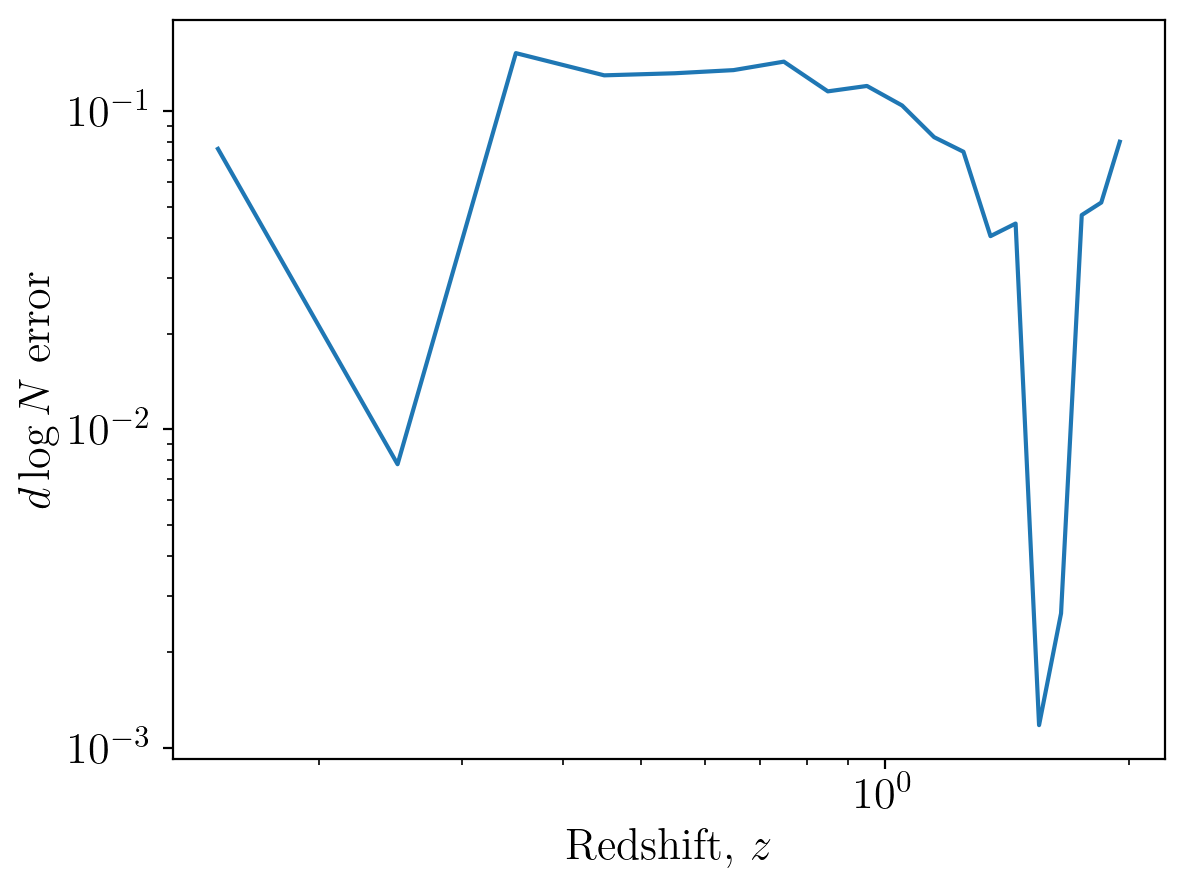

In [212]:
plt.plot(zSKA, np.abs(1 - dLogN/dLogNb))
plt.xlabel(r'Redshift, $z$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$d\log{N}$ error')


In [213]:
dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

dLogNB = (1+zSKA) * stencil_derivative(LogNB_z, zSKA)
dLogNF = (1+zSKA) * stencil_derivative(LogNF_z, zSKA)

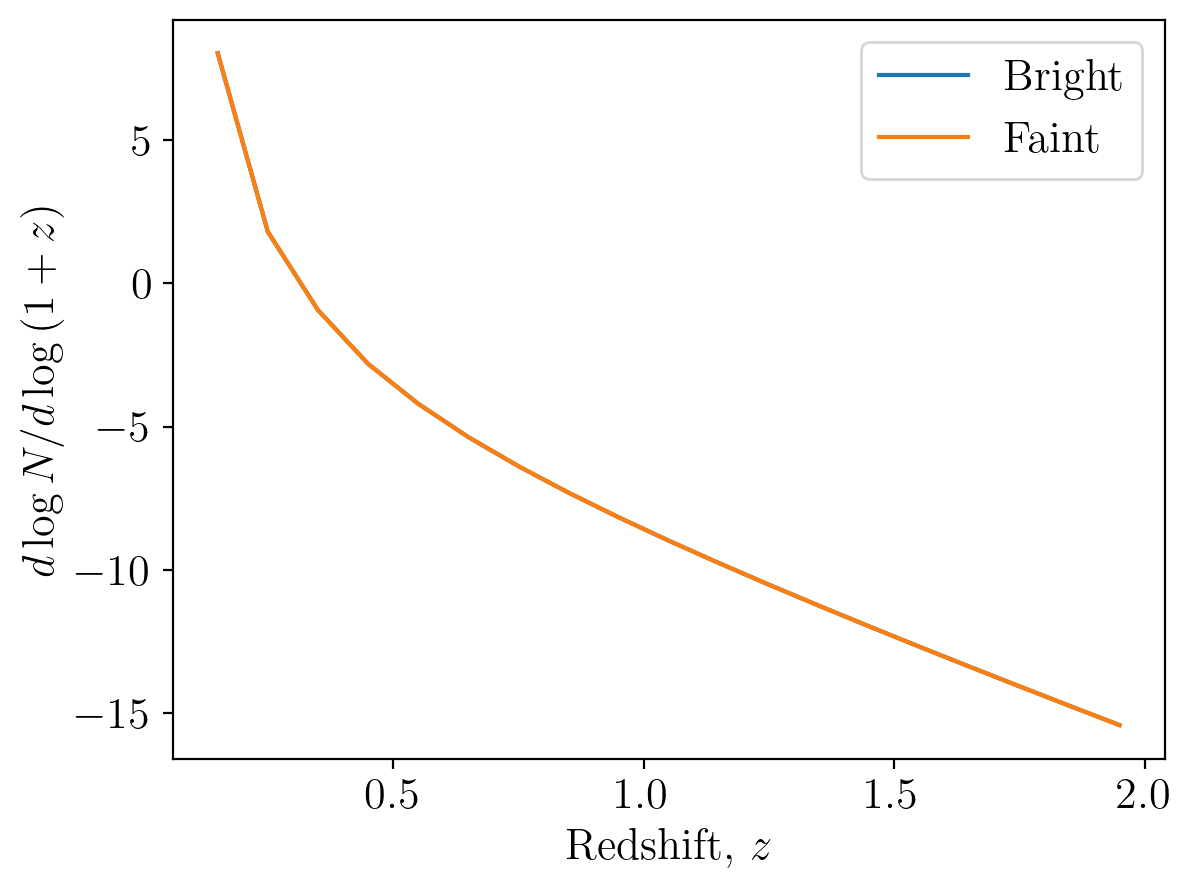

In [214]:
plt.plot(zSKA, dLogNB, label = 'Bright')
plt.plot(zSKA, dLogNF, label = 'Faint')

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$d\log{N}/d\log{(1+z)}$')
plt.legend()
plt.show()

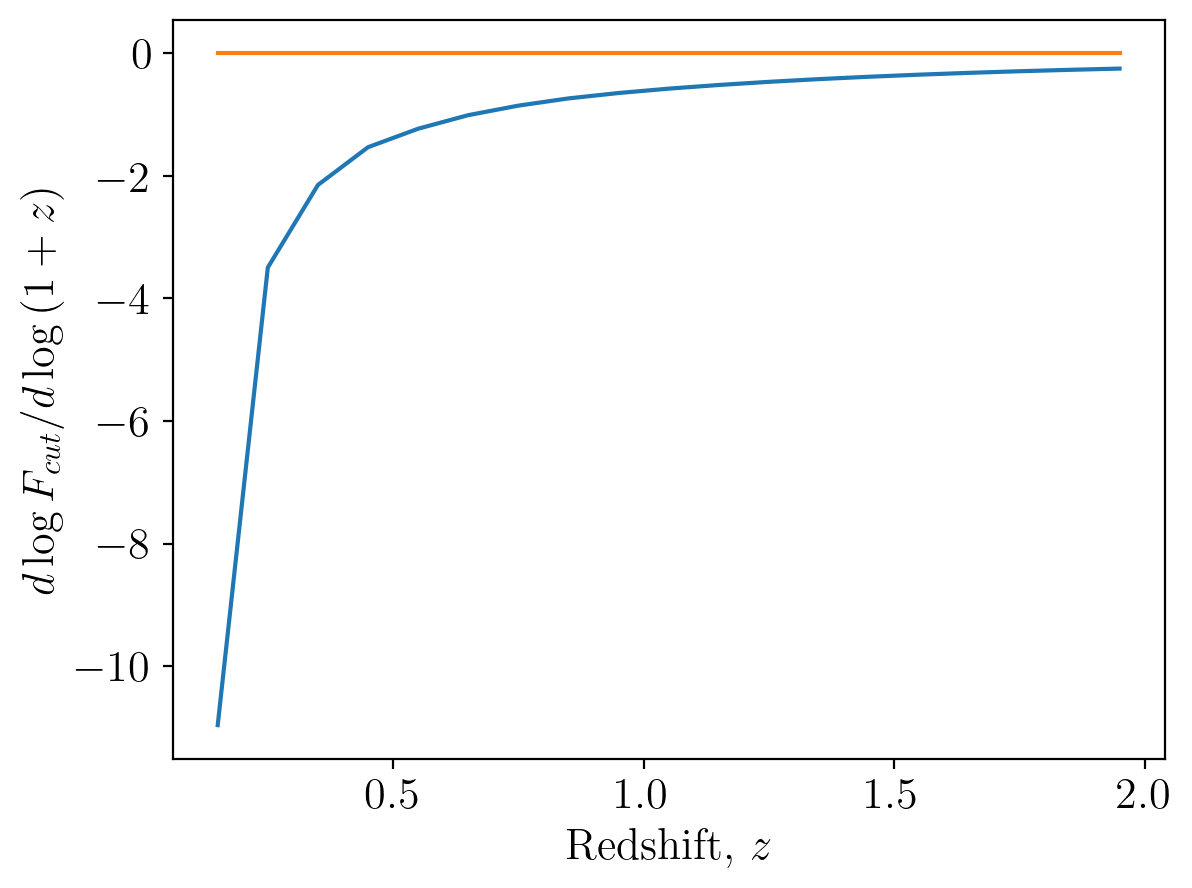

In [215]:
LogFcut = interp.interp1d(z_data, np.log(Sc_bright), kind='cubic', fill_value='extrapolate')
LogFstar = interp.interp1d(z_data, np.log(Sc_data), kind = 'cubic', fill_value='extrapolate')

dLogFcut = (1+zSKA) * stencil_derivative(LogFcut, zSKA)
dLogFstar = (1+zSKA) * stencil_derivative(LogFstar, zSKA)


plt.plot(zSKA, dLogFcut)
plt.plot(zSKA, dLogFstar)

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$d\log{F_{cut}}/d\log{(1+z)}$')
plt.show()

In [216]:
# Evolution bias

sB = smodelB(zSKA)
sF = n_split*smodel(zSKA) - smodelB(zSKA)

dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

dLogNB = (1+zSKA) * stencil_derivative(LogNB_z, zSKA)
dLogNF = (1+zSKA) * stencil_derivative(LogNF_z, zSKA)
dLogN = (1+zSKA) * stencil_derivative(fun=LogN_z, x=zSKA, h=0.0001)


dLogFcut = (1+zSKA) * stencil_derivative(LogFcut, zSKA)
dLogFstar = (1+zSKA) * stencil_derivative(LogFstar, zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB - 5/2*sB*dLogFcut
fevolF = - dLogNF - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar)



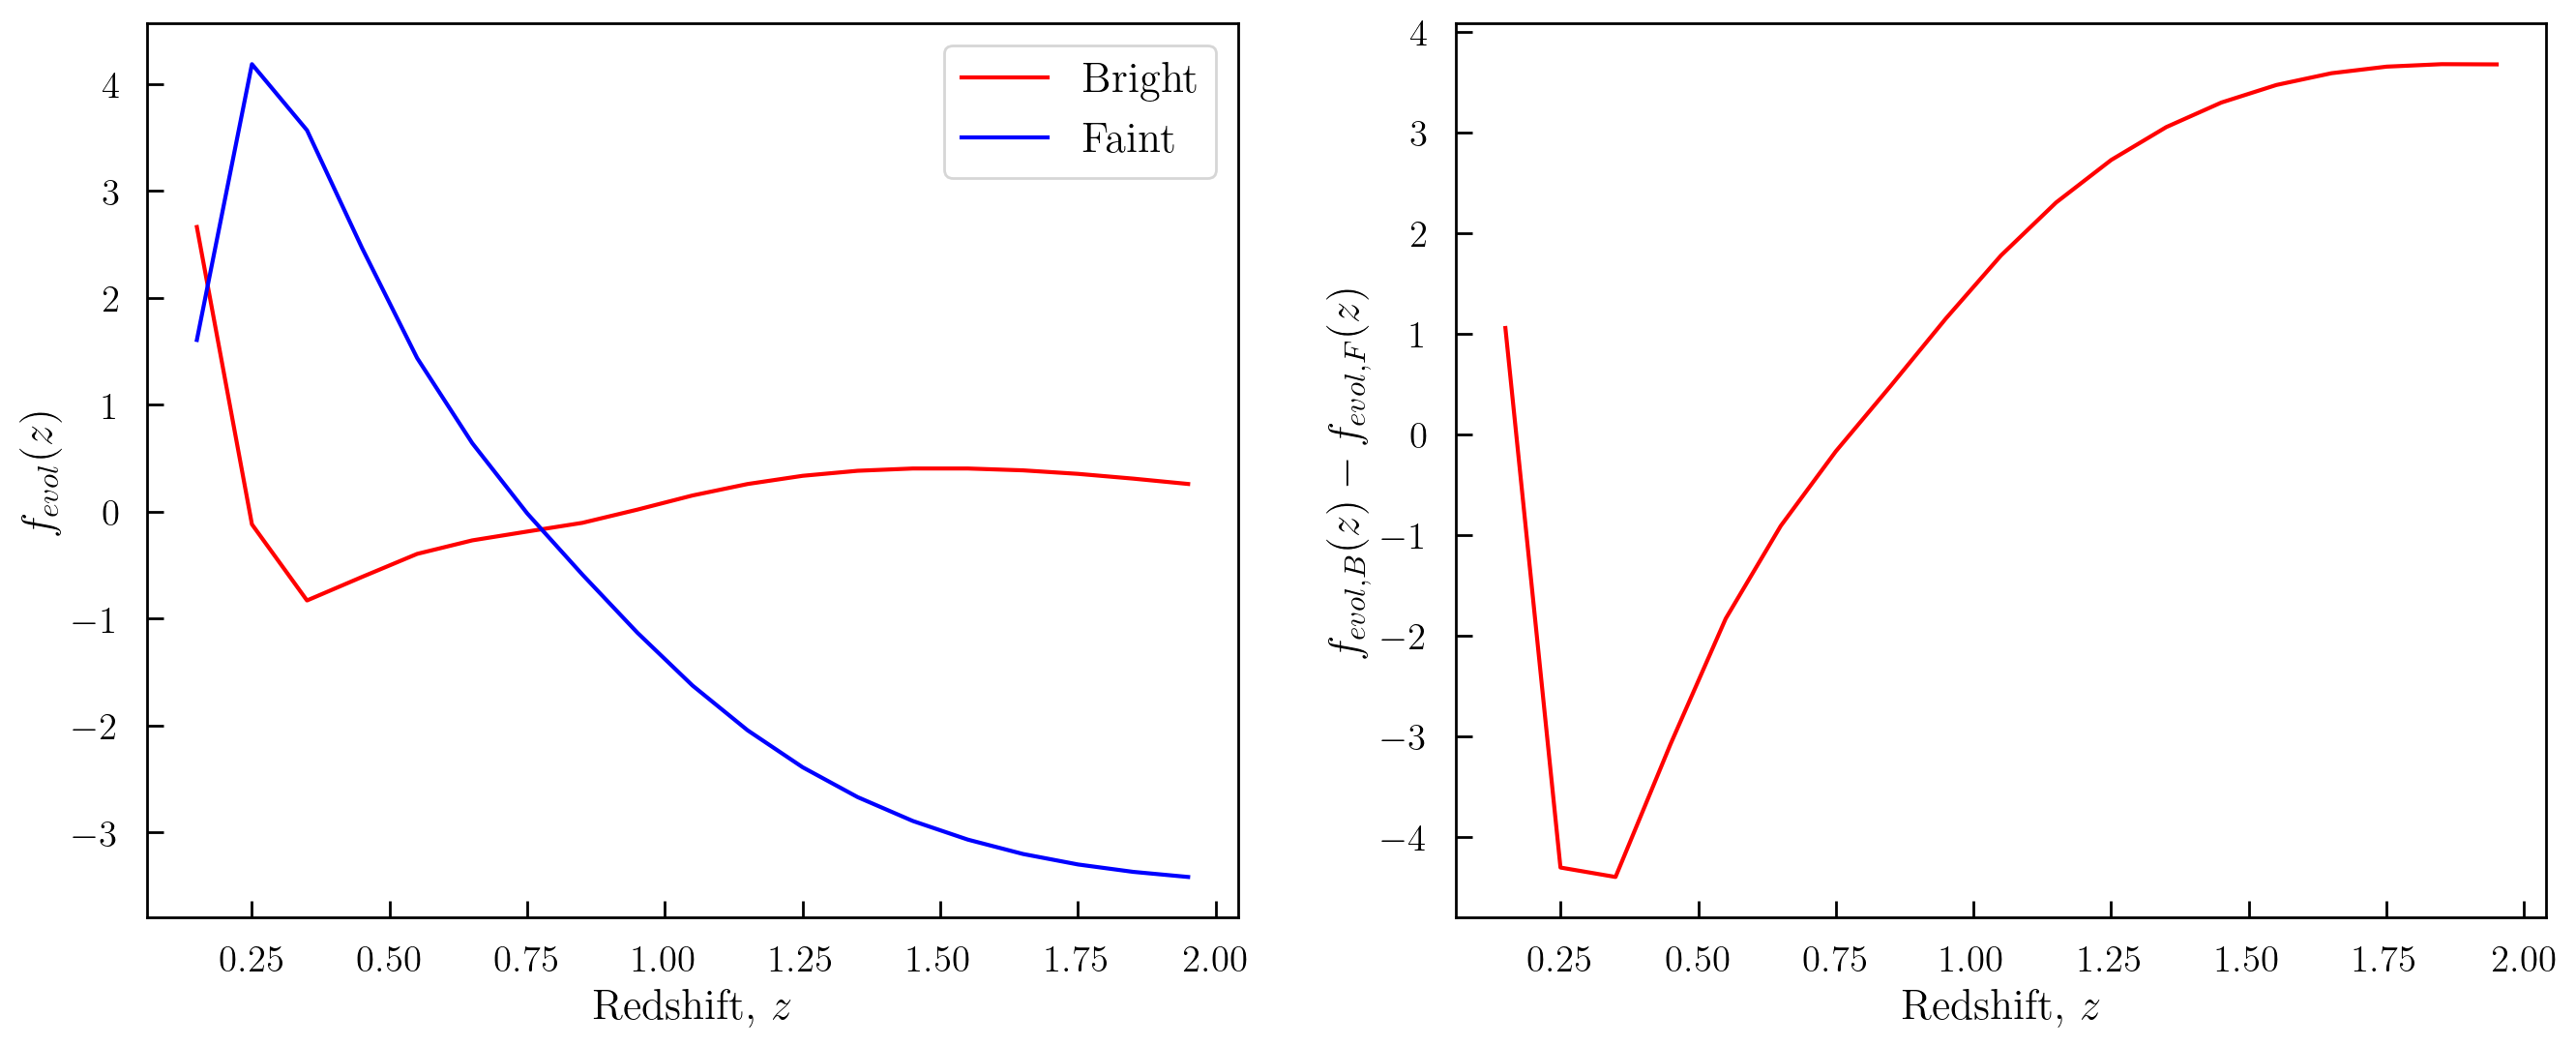

In [217]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fevolB, color = 'r', label = 'Bright')
ax[0].plot(zSKA, fevolF, color = 'b', label = 'Faint')
#ax[0].plot(z_data, smodelF(z_data), '.', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{evol}(z)$');
ax[0].legend();

ax[1].plot(zSKA, fevolB-fevolF, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

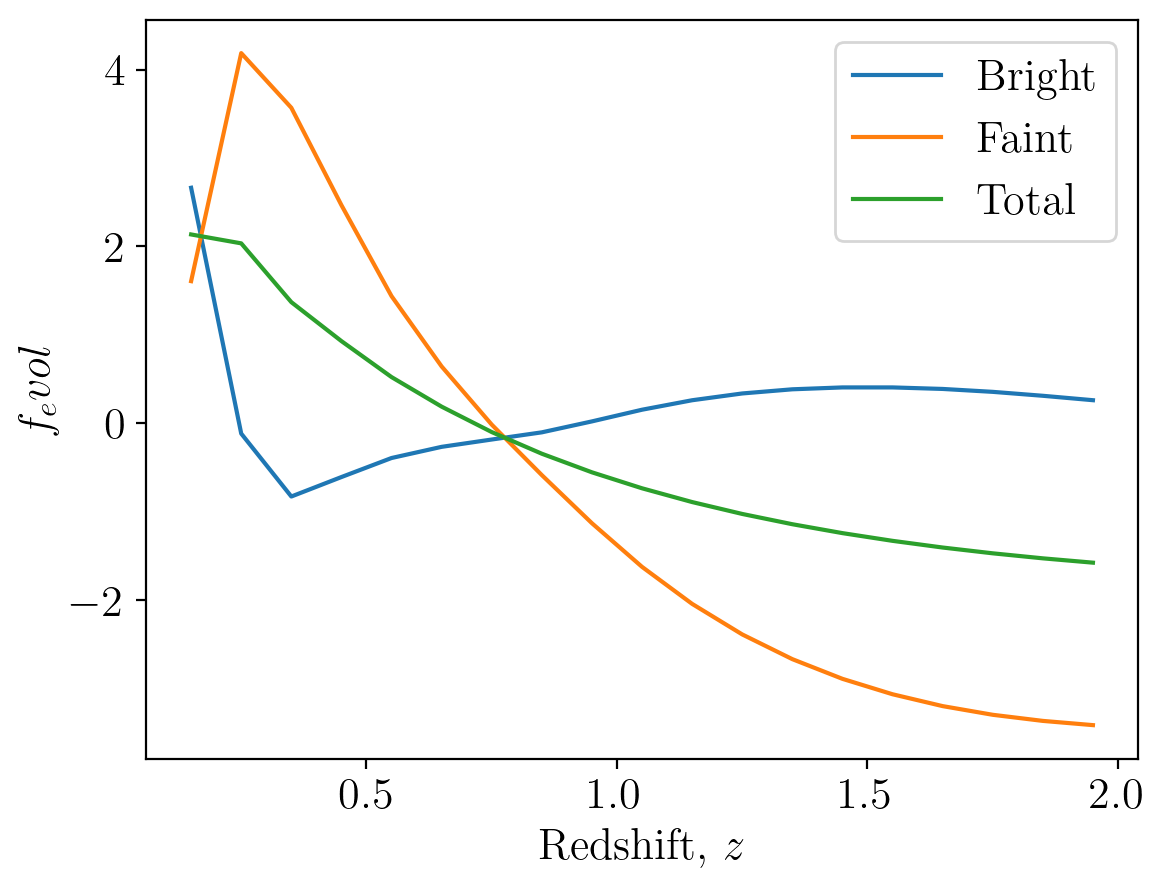

In [218]:
s = smodel(zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB  - 5/2*sB*dLogFcut
fevolF = - dLogNF - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar) 
fevol = - dLogN - dlogH + (2 - 5*s)*rHterm - 5*s - 5/2*sB*dLogFstar

plt.plot(zSKA, fevolB, label='Bright')
plt.plot(zSKA, fevolF, label ='Faint')
plt.plot(zSKA, fevol, label='Total')
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$f_evol$')
plt.legend();

### Using the total derivative:

In [138]:
#zSKA = np.array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95])
zSKA = np.linspace(start=0.25, stop=2.0, num=200)

In [139]:
def dlogN_dz(z, Sc, eps=0.0001):
    res = (1+z)*(c2_int(Sc)/z - c3_int(Sc) 
                 + (stencil_derivative(c1_int, x=Sc, h=eps)*np.log(10) + stencil_derivative(c2_int, x=Sc, h=eps)*np.log(z) - stencil_derivative(c3_int, x=Sc, h=eps)*z)*stencil_derivative(Sc_z, x=z, h=eps))
    return res

Text(0, 0.5, '$b_e$')

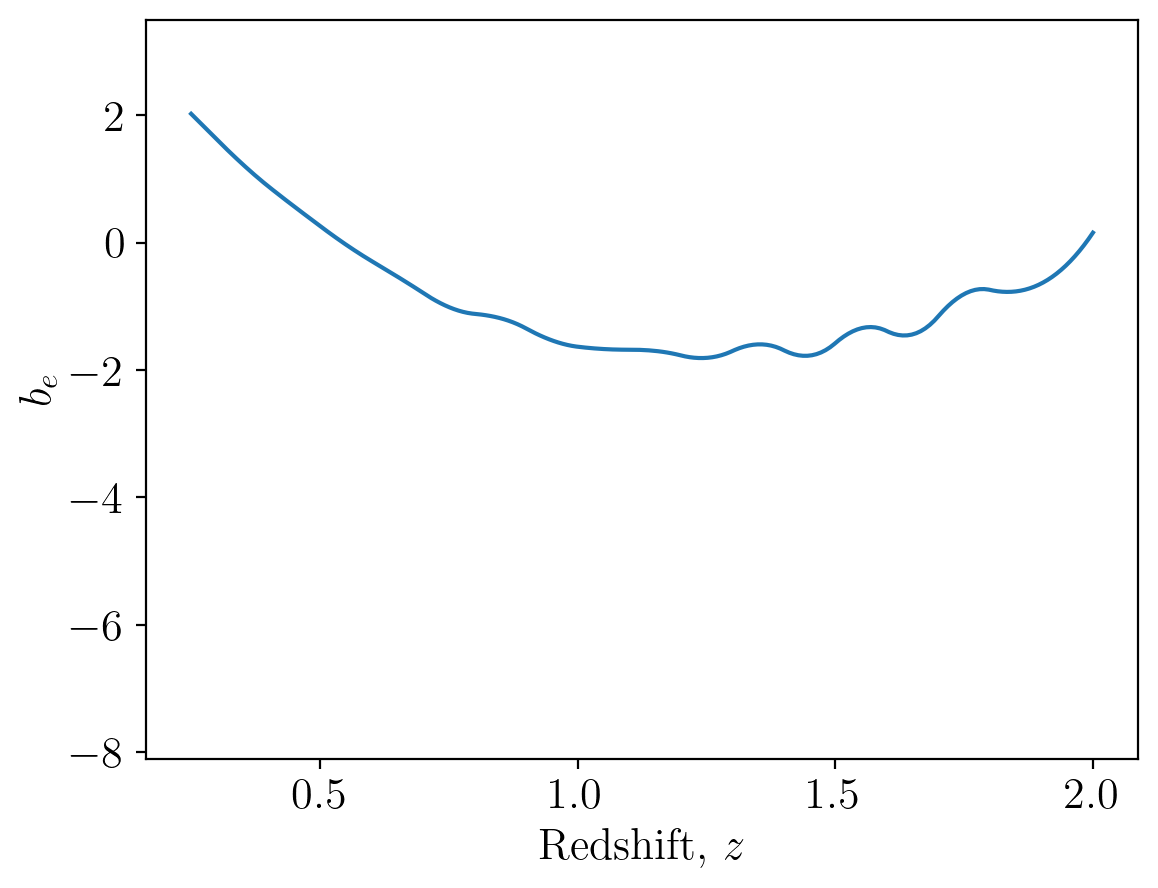

In [140]:
# Check be in R. Maartens et a.l. (2022)

rHterm_ = (1+zSKA)/(r(zSKA) * H(zSKA))

dlogH_ = (1+zSKA) * dlogH_f(zSKA)

Qterm_ = 2 * (1 + rHterm_) * 5/2 * smodel(zSKA)

dLogN = dlogN_dz(zSKA, Sc_z(zSKA), eps=0.0001)

fevol = - dLogN - dlogH_ + 2 * rHterm_ - Qterm_

plt.plot(zSKA, fevol)
plt.ylim([-8.1, 3.5])
#plt.xlim([0.0, 2.1])
plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$b_e$')

In [141]:
def Sc_z(z, Ncut=10):
    return Srms_fitz(z) * Ncut/10

Sc_bright_z = interp.interp1d(z_data, Sc_bright)

Sc_data, Sc_bright_z(z_data)

(array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5.]),
 array([41.83835016, 15.70635984, 11.56282931,  9.86939176,  8.86353797,
         8.18463913,  7.69553358,  7.32702727,  7.0394408 ,  6.8080472 ,
         6.61801099,  6.45974109,  6.32648749,  6.21325412,  6.11623103,
         6.03245853,  5.95960929,  5.8958419 ,  5.8396718 ,  5.78989002]))

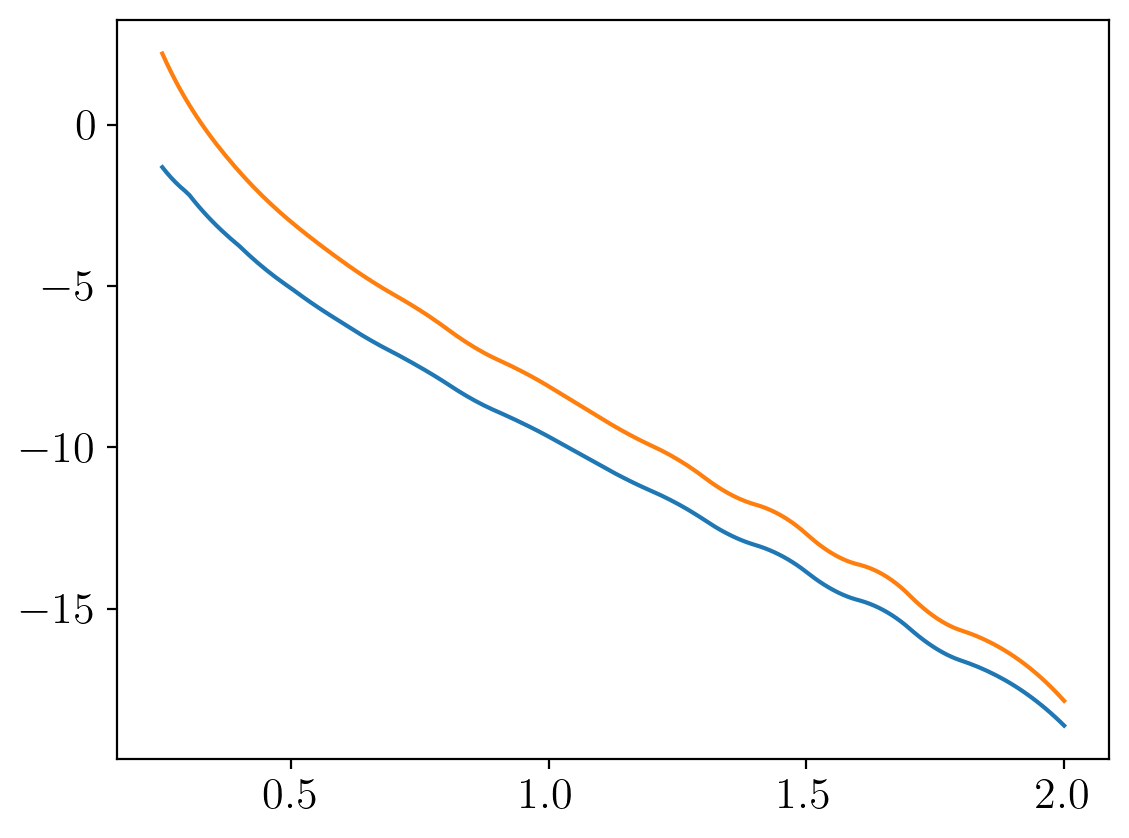

In [142]:
dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

dLogNB = dlogN_dz(z=zSKA, Sc=Sc_bright_z(zSKA))

dLogNF = dlogN_dz(z=zSKA, Sc=5.)

plt.plot(zSKA, dLogNB)
plt.plot(zSKA, dLogNF)

In [143]:
LogFcut = interp.interp1d(z_data, np.log(Sc_bright), kind='cubic', fill_value='extrapolate')
LogFstar = interp.interp1d(z_data, np.log(Sc_data), kind = 'cubic', fill_value='extrapolate')

dLogFcut = (1+zSKA) * stencil_derivative(LogFcut, zSKA)
dLogFstar = (1+zSKA) * stencil_derivative(LogFstar, zSKA)

In [144]:
# Evolution bias

sB = smodelB(zSKA)
sF = n_split*smodel(zSKA) - smodelB(zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB - 5/2*sB*dLogFcut
fevolF = - dLogNF - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar)

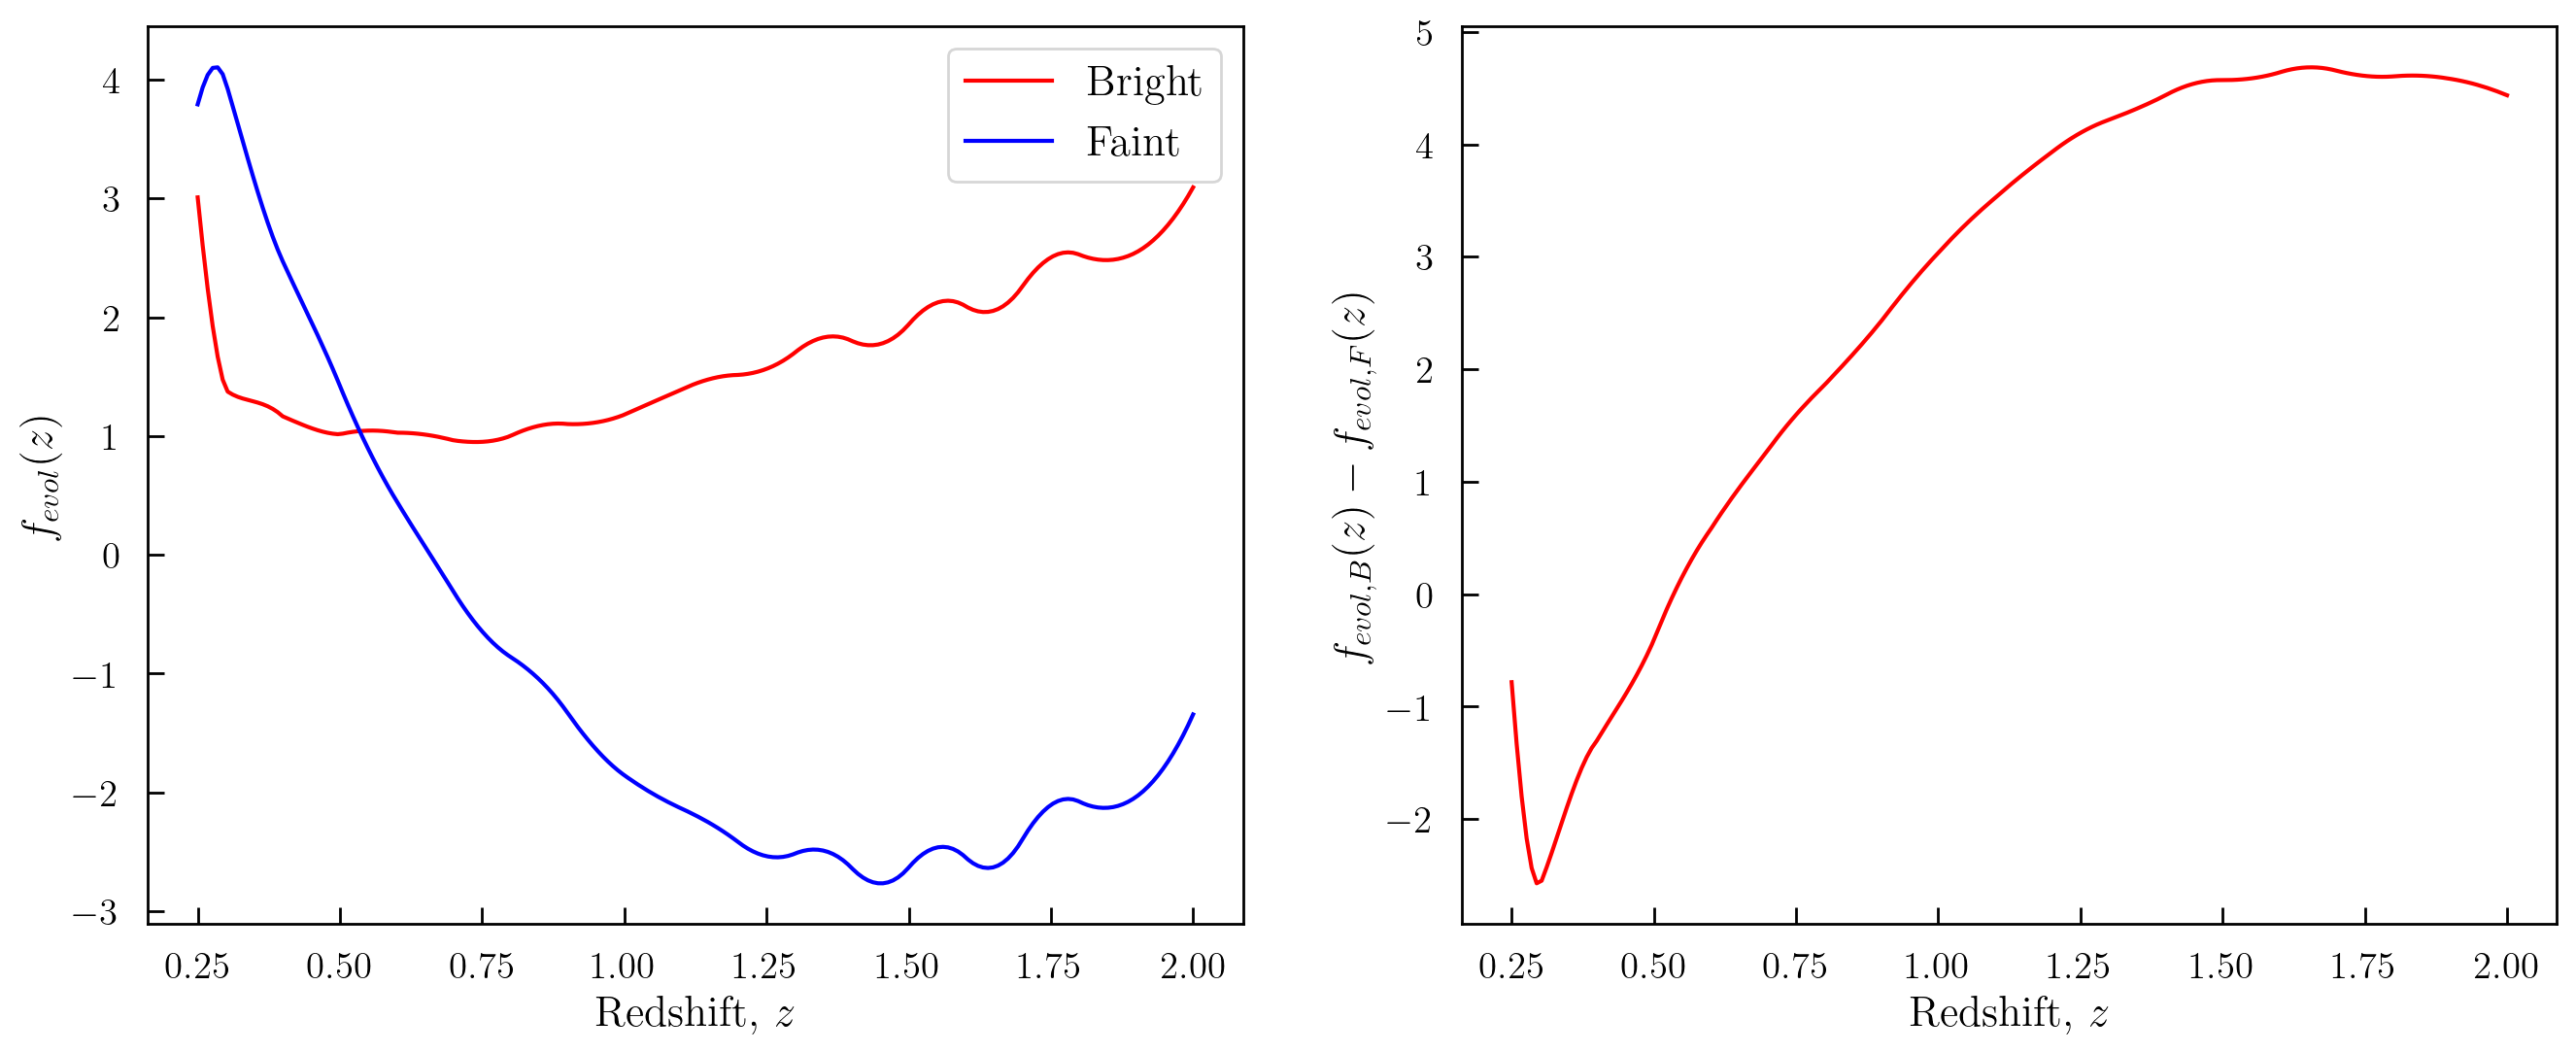

In [145]:
fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fevolB, color = 'r', label = 'Bright')
ax[0].plot(zSKA, fevolF, color = 'b', label = 'Faint')
#ax[0].plot(z_data, smodelF(z_data), '.', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{evol}(z)$');
ax[0].legend();

ax[1].plot(zSKA, fevolB-fevolF, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();

Text(0, 0.5, '$b_e$')

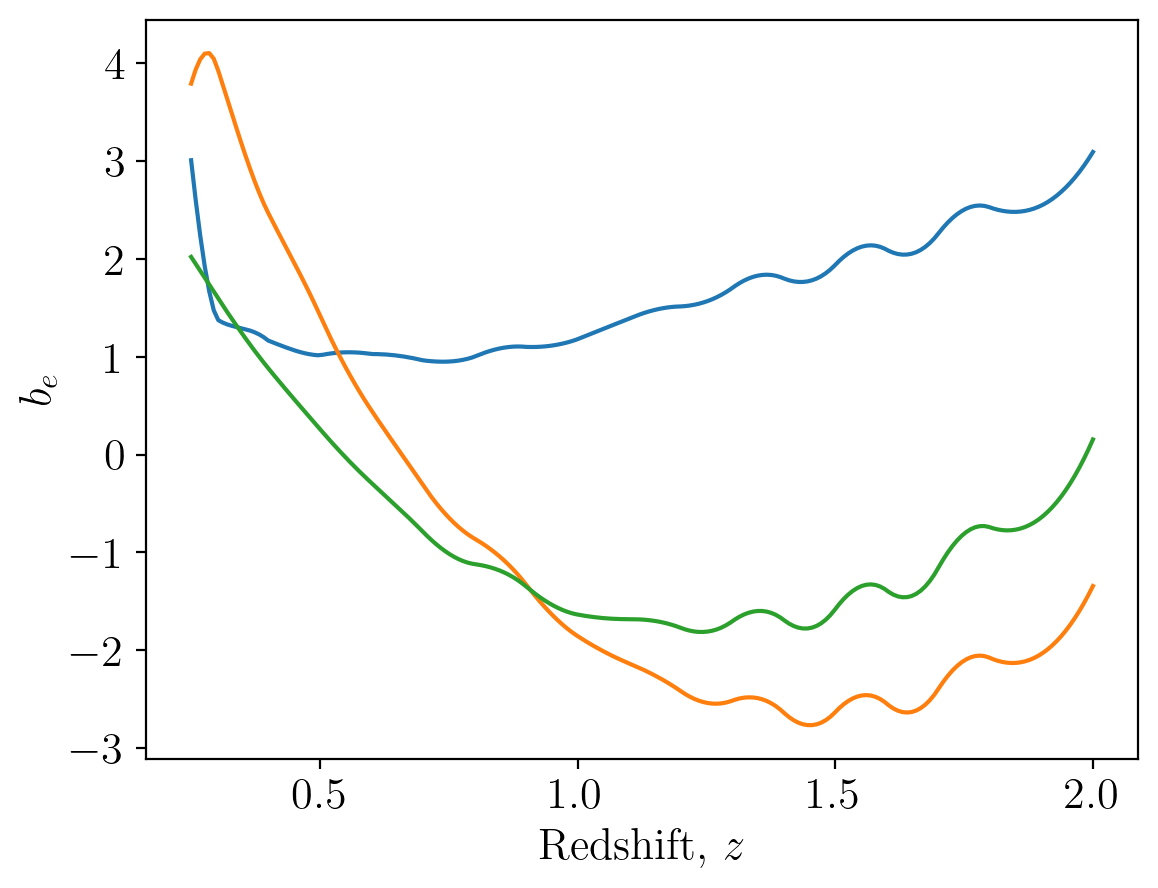

In [146]:
s = smodel(zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB  - 5/2*sB*dLogFcut
fevolF = - dLogNF - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar) 
fevol = - dLogN - dlogH + (2 - 5*s)*rHterm - 5*s 

plt.plot(zSKA, fevolB)
plt.plot(zSKA, fevolF)
plt.plot(zSKA, fevol)

plt.xlabel(r'Redshift, $z$')
plt.ylabel(r'$b_e$')

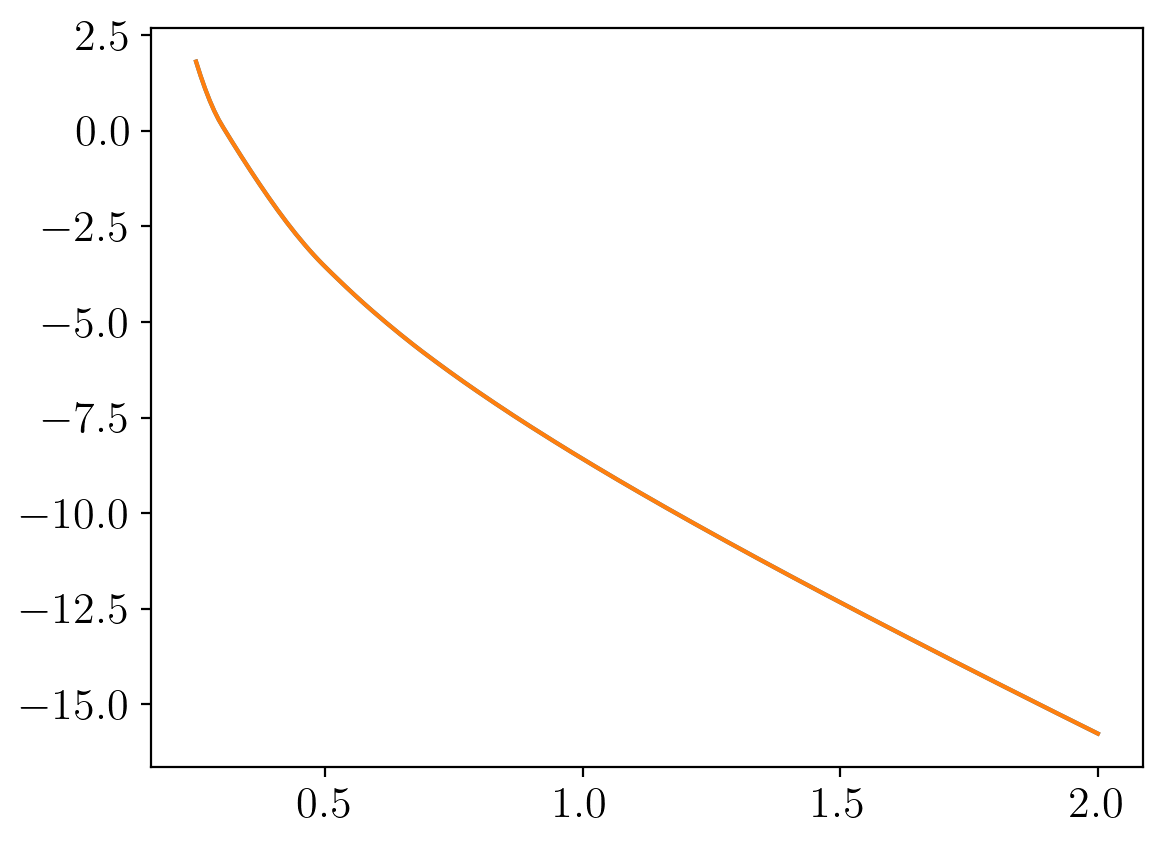

In [147]:
dLogNB = (1+zSKA) * stencil_derivative(LogNB_z, zSKA)
dLogNF = (1+zSKA) * stencil_derivative(LogNF_z, zSKA)

plt.plot(zSKA, dLogNB)
plt.plot(zSKA, dLogNF)

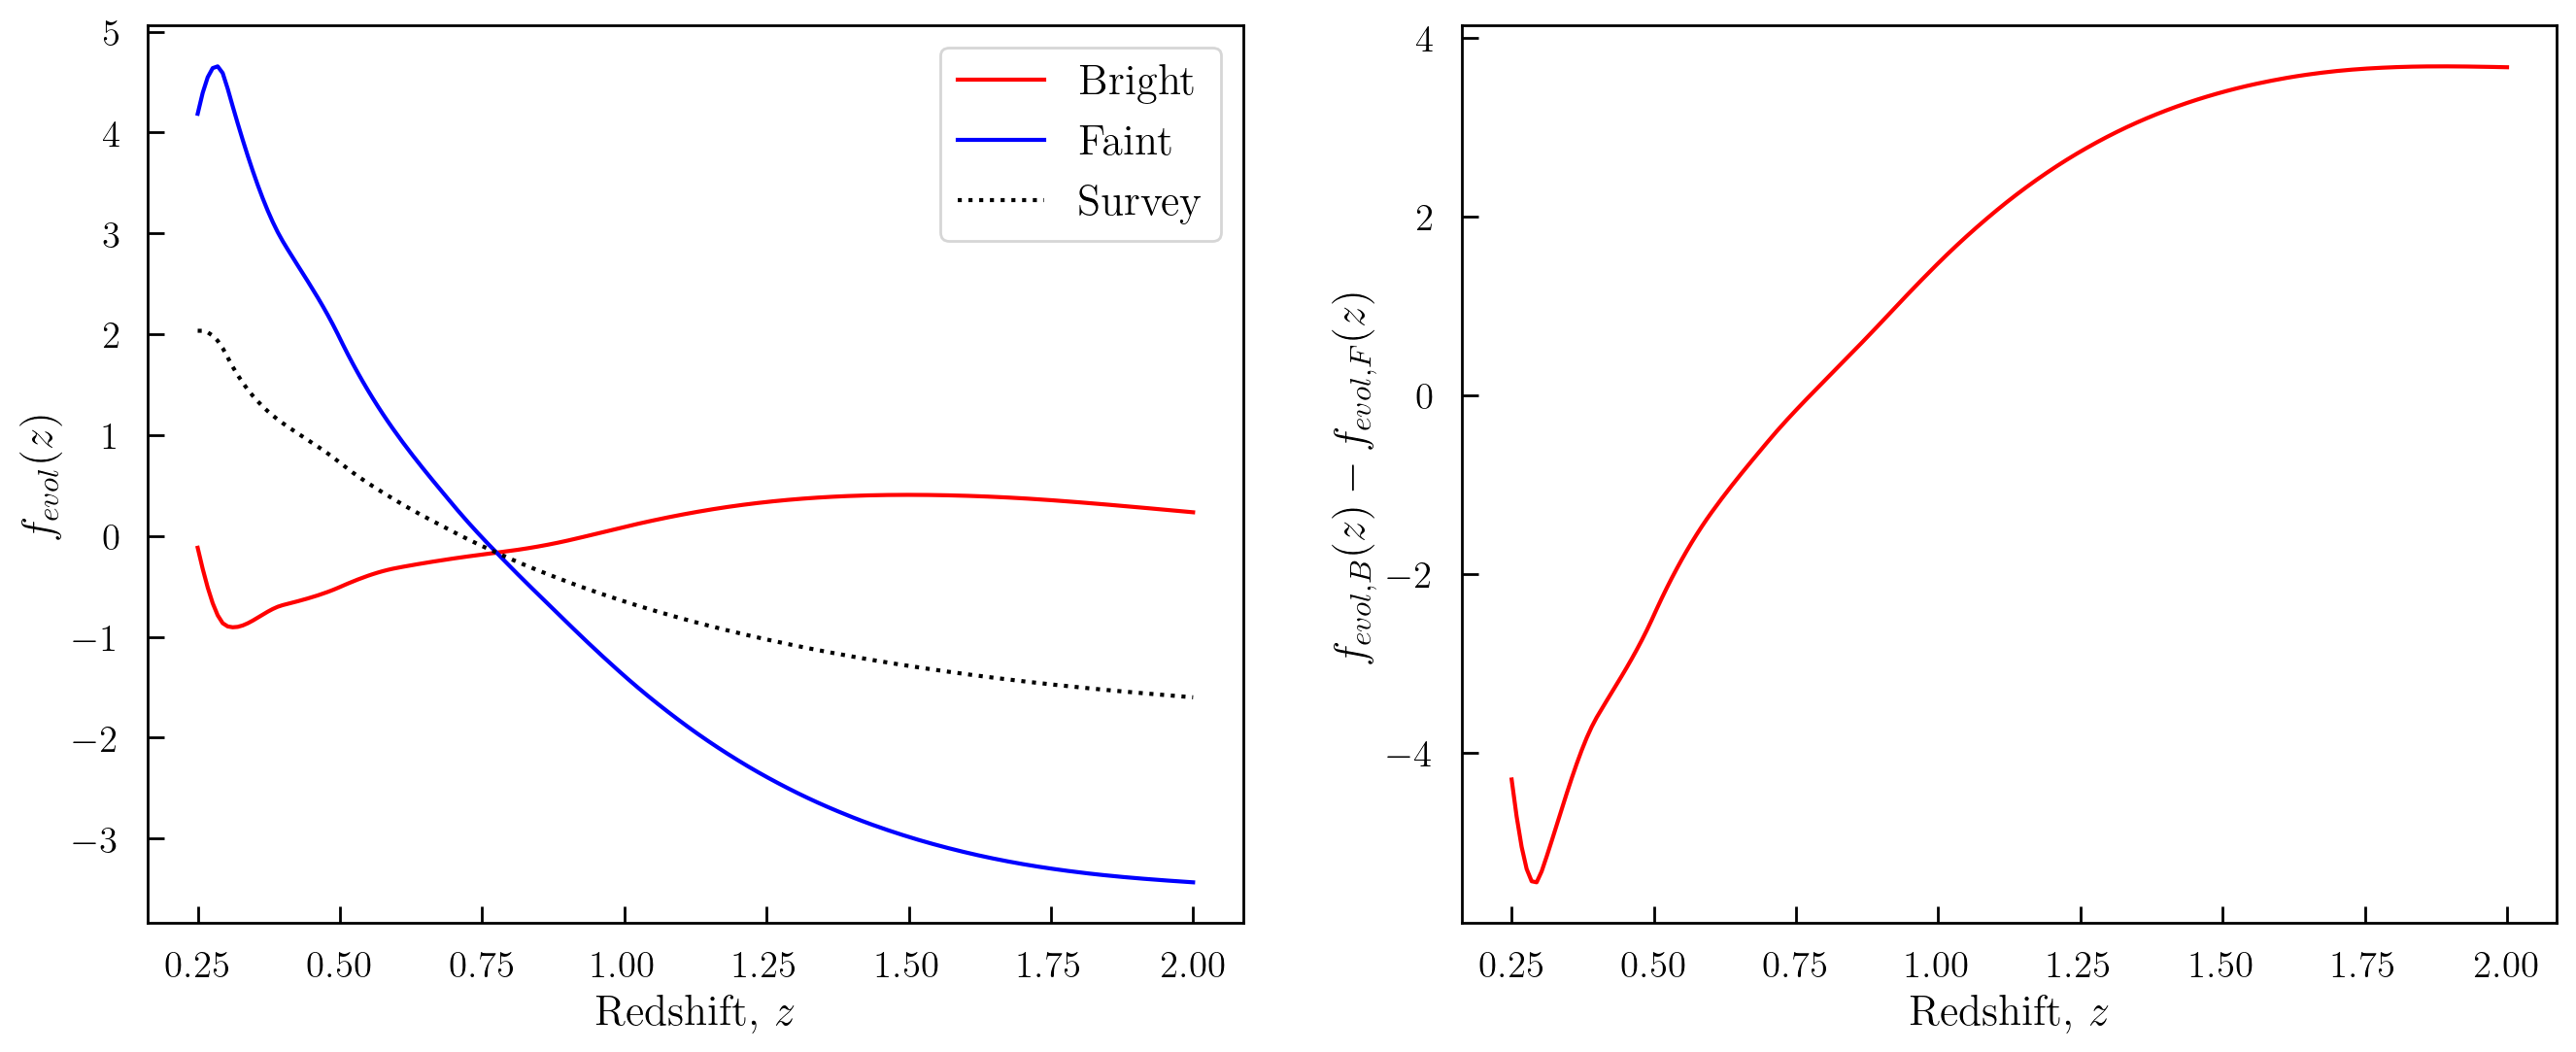

In [148]:
# Evolution bias

sB = smodelB(zSKA)
s = smodel(zSKA)
sF = n_split*smodel(zSKA) - smodelB(zSKA)

dlogH = (1+zSKA) * dlogH_f(zSKA)

rHterm = (1+zSKA)/(r(zSKA) * H(zSKA))

dLogNB = (1+zSKA) * stencil_derivative(LogNB_z, zSKA)
dLogNF = (1+zSKA) * stencil_derivative(LogNF_z, zSKA)
dLogN = (1+zSKA) * stencil_derivative(LogN_z, zSKA)

dLogFcut = (1+zSKA) * stencil_derivative(LogFcut, zSKA)
dLogFstar = (1+zSKA) * stencil_derivative(LogFstar, zSKA)

fevolB = - dLogNB - dlogH + (2 - 5*sB)*rHterm - 5*sB - 5/2*sB*dLogFcut
fevolF = - dLogN - dlogH + (2 - 5*sF)*rHterm - 5*sF + 5/2*(sB*dLogFcut - n_split*smodel(zSKA)*dLogFstar)
fevol = - dLogN - dlogH + (2 - 5*s)*rHterm - 5*s #- 5/2*(s*dLogFstar)

fig, ax = plt.subplots(1, 2, figsize = (16,6))

for axis in ['top','bottom','left','right']:
        ax[0].spines[axis].set_linewidth(1);
        ax[1].spines[axis].set_linewidth(1);

ax[0].plot(zSKA, fevolB, color = 'r', label = 'Bright')
ax[0].plot(zSKA, fevolF, color = 'b', label = 'Faint')
ax[0].plot(zSKA, fevol, ':', color = 'k', label='Survey')

ax[0].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[0].set_xlabel(r'Redshift, $z$');
ax[0].set_ylabel(r'$f_{evol}(z)$');
ax[0].legend();

ax[1].plot(zSKA, fevolB-fevolF, color = 'r')
ax[1].tick_params(labelsize = 14, axis = 'both', pad=10, direction='in', length = 6, width = 1);
ax[1].set_xlabel(r'Redshift, $z$');
ax[1].set_ylabel(r'$f_{evol, B}(z)-f_{evol, F}(z)$');
ax[1].set_ylim();